### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import math
import datetime
import pandas as pd  
import numpy as np  
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor,)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
from poc.functions import State_Timer
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-12-22T13:33:08.200 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [3]:
def load_data(filename):
    # load data
    df_input = pd.read_csv(filename, parse_dates=['RCV_TIMESTAMP_UTC'], comment='#')
    #df_input = df_input.asfreq('H')
    df_input = df_input.sort_values(by='RCV_TIMESTAMP_UTC').\
                    rename(columns={'RCV_TIMESTAMP_UTC':'timestamp', 'DEVICEID': 'entity'}).\
                    drop(columns=['DEVICETYPE','ID','FORMAT','UPDATED_UTC','LOGICALINTERFACE_ID','PUMP_MODE',\
                                  'DEVICE_ID','FIRMWARE_VER','PTS_COUNT','SERIAL_NUMBER', 'HARDWARE_VER',\
                                  'TAG_NUMBER','PWR','HW_VER','DQ','FW_VER','PTS','PERF_OPTION']).\
                    drop(columns=['VIBRATION_N_XAXIS','VIBRATION_N_YAXIS','VIBRATION_N_ZAXIS','REATED_POWER',\
                                  'RATED_SPEED','RATED_CURRENT','RMSN_X','RMSN_Y','RMSN_Z','RUN_QTY',\
                                  'DESIGN_HEAD','DESIGN_FLOW','RMS_X_AVG'])

    df_input = df_input[df_input['VERSION'] != 0].drop(columns=['VERSION'])
    
    
    return df_input


    
def prep_data(df_input):
    entity = df_input['entity'].values[0]
    
    list_ac_vx = []
    cnt = 0
    for idx,row in df_input[['timestamp','VIBRATIONS_XAXIS','ACCEL_POWER']].iterrows():
        if isinstance(row['timestamp'], str):
            ts = datetime.datetime.strptime(row['timestamp'], '%Y-%m-%d-%H.%M.%S.%f')
        else:
            ts = row['timestamp']
            
        rvibs = row['VIBRATIONS_XAXIS']
        racc = row['ACCEL_POWER']
        print (racc)
        if isinstance(racc, str):
            racc = eval(racc)
            
        if isinstance(rvibs, str):
            list_ac = []
           
            for ac in racc:
                #print(ac)
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                #print (list_ac)

            list_vx = []
            for vx in eval(rvibs):
                list_vx.append(vx)
                #print (list_vx)

            #print(list_ac, list_vx)
            cnt2 = 0
            for p in zip(list_ac, list_vx):
                #print(ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1])
                list_ac_vx.append([ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1]])
                cnt2 += 1
        cnt += 1

    df_clean = pd.DataFrame(list_ac_vx, columns=['timestamp','Ap','Vx'])
    df_clean['entity'] = entity
    
    return df_clean.set_index(['entity','timestamp'])
    

In [4]:
df_clean = prep_data(load_data('./IOT_PUMP_DE_GEN5_202012141519.csv'))

df_clean.head(2)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0,21,23,25,26,27,28,31,41) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


nan
["3.336600","3.284000","3.326400","3.325400","3.223600"]
nan
["3.318000","3.364200","3.380400","3.275800","3.125200"]
nan
["3.074600","3.038400","3.261000","3.213800","3.210000"]
nan
["3.084600","3.009800","2.953600","3.170400","3.057200"]
nan
["3.067200","3.066800","3.107000","3.133800","3.146600"]
nan
["2.959000","3.073800","3.319000","3.332200","3.413600"]
nan
["3.440800","3.006600","2.962000","3.151600","3.301400"]
nan
["3.509000","3.367000","3.438600","3.446400","3.415600"]
nan
["3.475400","3.400400","3.421200","3.412400","3.251400"]
nan
["3.159600","3.017800","2.981400","3.134400","3.132200"]
nan
["3.254400","3.205200","3.091200","3.023200","2.950400"]
nan
["3.107800","3.165000","3.046600","3.049000","3.009000"]
nan
["3.052400","3.290800","3.182800","3.381200","3.168000"]
nan
["3.267600","3.383600","3.320000","3.457200","3.536000"]
nan
["3.652400","3.565400","3.619200","3.564400","3.667600"]
nan
["3.961600","4.099401","4.296200","4.167000","4.045400"]
nan
["3.945200","3.71840

["2.227800","2.235000","2.170200","2.193600","2.226200"]
nan
["2.200200","2.235800","2.368400","2.315000","2.353000"]
nan
["2.370400","2.310600","2.325800","2.299200","2.292400"]
nan
["2.283000","2.310000","2.312800","2.340800","2.266600"]
nan
["2.323400","2.344800","2.311000","2.251600","2.242800"]
nan
["2.175600","2.209600","2.225400","2.159000","2.142800"]
nan
["2.147600","2.211800","2.146600","2.194800","2.196000"]
nan
["2.133200","2.120600","2.125800","2.189400","2.209000"]
nan
["2.193800","2.143000","2.204000","2.213000","2.278200"]
nan
["2.292600","2.315600","2.322800","2.318200","2.370000"]
nan
["2.339000","2.352000","2.289400","2.281400","2.262200"]
nan
["2.221200","2.231200","2.267200","2.240600","2.273200"]
nan
["2.335200","2.399600","2.424200","2.475200","2.383200"]
nan
["2.406400","2.395200","2.364800","2.312200","2.302000"]
nan
["2.224800","2.309200","2.224200","2.254800","2.239800"]
nan
["2.224200","2.349200","2.352200","2.427000","2.499800"]
nan
["2.546600","2.554200","

nan
["2.803000","2.797000","2.751600","2.731800","2.717800"]
nan
["2.752200","2.736800","2.800800","2.837400","2.746400"]
nan
["2.775800","2.962200","3.101800","3.032200","2.915000"]
nan
["2.941800","2.916200","2.905600","2.965600","2.924000"]
nan
["2.776400","2.703600","2.697000","2.607800","2.506400"]
nan
["2.452600","2.513400","2.547600","2.410600","2.348600"]
nan
["2.384000","2.389600","2.416800","2.519800","2.490000"]
nan
["2.550600","2.573600","2.646600","2.551400","2.543400"]
nan
["2.547400","2.566600","2.589800","2.664200","2.743000"]
nan
["2.725800","2.658600","2.707800","2.724400","2.743200"]
nan
["2.756600","2.720400","2.681200","2.775200","2.808200"]
nan
["2.913600","2.829000","2.968800","2.797800","2.851000"]
nan
["2.883000","2.837200","2.687200","2.696600","2.842200"]
nan
["2.890200","2.748400","2.781600","2.784200","2.792800"]
nan
["2.612200","2.633800","2.631600","2.518000","2.624400"]
nan
["2.584000","2.707000","2.701800","2.714600","2.720000"]
nan
["2.804400","2.78220

["2.903200","2.852000","2.992000","2.975800","3.230800"]
nan
["3.276000","3.294400","3.082400","3.069600","3.072600"]
nan
["3.072000","3.066200","2.953000","2.978800","2.949200"]
nan
["2.877200","2.889800","2.688000","2.688800","2.628600"]
nan
["2.653400","2.655200","2.650200","2.635000","2.778000"]
nan
["2.804000","2.646400","2.699600","2.815400","2.887000"]
nan
["2.915600","2.764600","2.665800","2.612000","2.577000"]
nan
["2.700000","2.706000","2.703000","2.664800","2.667400"]
nan
["2.629600","2.648600","2.704800","2.637200","2.796600"]
nan
["2.831800","2.732000","2.686800","2.604600","2.602200"]
nan
["2.662600","2.695000","2.781400","2.848800","2.922000"]
nan
["2.772200","2.768400","2.878400","2.739000","2.673800"]
nan
["2.639000","2.544400","2.500600","2.568600","2.585000"]
nan
["2.635000","2.779000","2.827800","2.830000","2.967200"]
nan
["2.837000","2.830800","2.727600","2.869600","2.747200"]
nan
["2.731600","2.695600","2.695600","2.604800","2.612600"]
nan
["2.584400","2.622600","

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
["2.519200","2.430200","2.360200","2.372800","2.360400"]
nan
["2.308000","2.209800","2.241400","2.262200","2.307200"]
nan
["2.310000","2.267200","2.279200","2.242000","2.286200"]
nan
["2.300400","2.301600","2.418400","2.413400","2.381000"]
nan
["2.386200","2.519800","2.497800","2.507800","2.535200"]
nan
["2.572000","2.475400","2.466600","2.385600","2.323400"]
nan
["2.315600","2.415000","2.505200","2.440800","2.425800"]
nan
["2.606800","2.485400","2.417800","2.407000","2.318800"]
nan
["2.342600","2.261400","2.188400","2.168600","2.122200"]
nan
["2.073400","2.106000","2.069400","2.168800","2.283200"]
nan
["2.242000","2.237800","2.409000","2.473200","2.553200"]
nan
["2.482200","2.571600","2.661400","2.482200","2.452000"]


["3.030000","3.030000","2.805600","2.820600","2.722000"]
nan
["2.685600","2.681000","2.750800","2.735600","2.840200"]
nan
["2.689400","2.779400","2.784400","2.808000","2.961400"]
nan
["3.144800","2.925000","2.978400","3.004400","2.913600"]
nan
["2.954800","2.925200","2.959600","3.031400","2.943600"]
nan
["3.164800","3.108800","3.075800","2.955600","2.732800"]
nan
["2.758200","2.876800","2.813200","2.918800","2.860200"]
nan
["2.870800","2.970600","3.011200","2.932400","2.964600"]
nan
["3.113200","3.131600","3.059800","3.062400","3.092800"]
nan
["3.112600","3.092600","3.225200","3.297800","3.363200"]
nan
["3.327600","3.203200","3.103800","3.084600","2.954000"]
nan
["2.921400","2.632800","2.598400","2.621600","2.698800"]
nan
["2.768400","2.698800","2.736800","2.975400","3.056800"]
nan
["3.078000","2.980200","2.846800","2.747400","2.743600"]
nan
["2.705200","2.595800","2.636200","2.644600","2.737800"]
nan
["2.818400","2.883600","2.906000","2.916800","2.956400"]
nan
["2.941800","3.116600","

["3.132800","3.180200","3.190000","3.287000","3.426000"]
nan
["3.282000","3.163200","2.954600","2.947800","2.741400"]
nan
["2.737600","2.820800","2.807200","2.814400","2.853000"]
nan
["2.874800","2.995400","3.047200","3.143800","3.147200"]
nan
["2.950400","3.053800","2.983800","2.984800","3.121600"]
nan
["3.127000","3.001000","3.000400","2.850600","2.781000"]
nan
["2.890800","2.908800","2.863800","3.065000","3.104600"]
nan
["3.038800","2.876800","2.848400","2.866200","2.894200"]
nan
["2.935000","2.982000","3.005600","3.007200","3.000400"]
nan
["2.840600","2.805400","2.701000","2.692200","2.611600"]
nan
["2.729200","2.911000","2.781200","2.870000","2.822800"]
nan
["2.830600","2.830800","2.960400","2.994800","3.058800"]
nan
["2.910600","2.810600","2.876800","2.899200","2.926000"]
nan
["3.175000","3.181600","3.179400","3.218600","3.131600"]
nan
["3.059600","2.948800","2.878000","2.978600","2.939400"]
nan
["3.023000","3.070800","3.177000","3.092000","3.145400"]
nan
["3.142600","3.010200","

["1.825400","1.809000","1.808200","1.820800","1.810000"]
nan
["1.813200","1.801000","1.808600","1.787400","1.816200"]
nan
["1.804200","1.787600","1.827200","1.857400","1.857000"]
nan
["1.865200","1.855000","1.849400","1.859600","1.887800"]
nan
["1.864400","1.893600","1.887000","1.828000","1.798800"]
nan
["1.771200","1.762600","1.752400","1.779800","1.789800"]
nan
["1.801400","1.796400","1.809800","1.800800","1.828400"]
nan
["1.869000","1.854600","1.858600","1.853200","1.860800"]
nan
["1.843200","1.864000","1.886800","1.873200","1.868800"]
nan
["1.876200","1.818000","1.817400","1.804200","1.819600"]
nan
["1.820600","1.827400","1.849600","1.798400","1.810800"]
nan
["1.829600","1.836600","1.819400","1.793200","1.775800"]
nan
["1.736000","1.729400","1.703800","1.726800","1.785800"]
nan
["1.786200","1.773000","1.747200","1.773000","1.774400"]
nan
["1.831600","1.872600","1.855400","1.866600","1.858800"]
nan
["1.840400","1.883800","1.892200","1.880000","1.874400"]
nan
["1.858800","1.863400","

["1.978400","1.912000","1.911200","1.904000","2.023600"]
nan
["2.034200","2.052000","2.022200","2.023400","2.064000"]
nan
["2.109200","2.118600","2.096000","2.082200","2.069800"]
nan
["1.994400","1.951000","2.006600","2.019200","1.974400"]
nan
["1.979800","1.981600","1.978600","1.996000","1.986600"]
nan
["1.999200","2.023800","2.025400","2.071000","2.081800"]
nan
["2.116400","2.159000","2.188400","2.132200","2.133400"]
nan
["2.121800","2.110200","2.112800","2.089400","2.093400"]
nan
["2.050000","2.105400","2.075600","2.083600","2.072800"]
nan
["2.005200","2.014200","2.005600","1.974600","1.993600"]
nan
["1.984800","1.987000","2.040000","2.077400","2.096200"]
nan
["2.119800","2.138200","2.158600","2.076200","2.025200"]
nan
["2.020400","2.029600","2.001200","1.976200","2.028200"]
nan
["2.108200","2.101400","2.087200","2.145800","2.170400"]
nan
["2.139800","2.140000","2.137200","2.091200","2.104200"]
nan
["2.053000","2.049200","2.025400","2.024600","2.031400"]
nan
["2.012800","2.026600","

nan
["1.878600","1.893200","1.882400","1.875200","1.883400"]
nan
["1.898600","1.905200","1.892400","1.893200","1.903400"]
nan
["1.894200","1.865000","1.851800","1.833200","1.852000"]
nan
["1.818000","1.804000","1.813800","1.832200","1.822800"]
nan
["1.879200","1.890200","1.910400","1.884400","1.831200"]
nan
["1.855200","1.828600","1.835000","1.895400","1.894400"]
nan
["1.920000","1.888800","1.890800","1.913800","1.943800"]
nan
["1.910000","1.906600","1.879200","1.862800","1.831400"]
nan
["1.797800","1.800400","1.774000","1.788000","1.780600"]
nan
["1.769400","1.698000","1.675400","1.694000","1.700400"]
nan
["1.692400","1.710200","1.748400","1.760600","1.776800"]
nan
["1.793000","1.880200","1.884800","1.868800","1.824600"]
nan
["1.794400","1.837400","1.830400","1.863000","1.842600"]
nan
["1.824200","1.826200","1.885400","1.881800","1.899200"]
nan
["1.879400","1.847000","1.851400","1.859600","1.885400"]
nan
["1.889000","1.902400","1.919400","1.906200","1.903400"]
nan
["1.913600","1.90480

nan
["1.721600","1.838400","1.901000","1.910600","1.917400"]
nan
["1.861600","1.814200","1.786200","1.778000","1.747000"]
nan
["1.725800","1.741800","1.729400","1.734000","1.741200"]
nan
["1.735000","1.745200","1.729600","1.757400","1.771000"]
nan
["1.789400","1.828400","1.847200","1.857000","1.855400"]
nan
["1.897800","1.891800","1.895600","1.839800","1.856400"]
nan
["1.897200","1.908400","1.892600","1.913200","1.929400"]
nan
["1.918800","1.829400","1.867200","1.847200","1.791600"]
nan
["1.756400","1.767200","1.731000","1.741800","1.756200"]
nan
["1.736400","1.723800","1.686800","1.699600","1.758200"]
nan
["1.773400","1.782600","1.774000","1.828600","1.875000"]
nan
["1.822400","1.800000","1.780400","1.761800","1.744800"]
nan
["1.737600","1.761400","1.808200","1.874600","1.859000"]
nan
["1.817000","1.838600","1.872800","1.834600","1.831400"]
nan
["1.830000","1.806600","1.787000","1.830000","1.861000"]
nan
["1.822200","1.800800","1.790400","1.763800","1.763000"]
nan
["1.821600","1.87440

["4.018800","4.146800","4.204000","4.158600","4.035800"]
nan
["4.240000","4.259400","4.389600","4.472600","4.528399"]
nan
["4.518200","4.450000","4.345000","4.201600","4.131000"]
nan
["4.133400","4.024199","4.139600","4.080200","4.097600"]
nan
["4.153800","4.162800","4.156800","4.068800","4.220800"]
nan
["4.086400","4.149800","3.957800","3.897200","3.875000"]
nan
["3.902200","3.967400","3.889800","3.887400","3.953600"]
nan
["3.869200","3.771000","3.853000","3.913800","4.262200"]
nan
["4.568400","4.719000","4.638800","4.330200","4.300000"]
nan
["4.121400","4.311200","4.311600","4.520200","4.246000"]
nan
["4.086000","3.835800","3.794800","3.903800","4.255600"]
nan
["4.579600","4.610200","4.746000","4.747600","4.778600"]
nan
["4.561600","4.491000","4.352000","4.250200","4.253800"]
nan
["4.188800","4.270200","4.509600","4.419800","4.237600"]
nan
["4.334000","4.486000","4.429400","4.636800","4.341800"]
nan
["4.335200","4.075400","4.005400","3.923600","3.838800"]
nan
["3.940400","4.255200","

["3.584200","3.694000","3.722400","3.663000","3.608800"]
nan
["3.723200","3.978200","4.150000","4.163400","4.083600"]
nan
["4.264400","4.398600","4.171400","4.285200","4.220600"]
nan
["4.124000","4.010600","3.802200","3.813400","4.073800"]
nan
["4.061200","3.954400","3.900600","3.974800","4.023600"]
nan
["3.937400","3.856800","3.786600","3.703600","3.618000"]
nan
["3.709200","3.797600","3.955800","3.615600","3.574000"]
nan
["3.524200","3.513600","3.722800","3.809400","3.936800"]
nan
["3.889600","3.706400","3.779200","3.779200","3.588000"]
nan
["3.603000","3.424400","3.574800","3.589400","3.599800"]
nan
["3.810800","4.022400","3.897400","4.114600","4.043400"]
nan
["4.100200","3.956600","4.028200","3.926000","4.186600"]
nan
["4.250000","3.900600","3.759400","3.755400","3.759600"]
nan
["3.687400","3.789800","3.652600","3.484600","3.597600"]
nan
["3.674000","3.812600","4.009000","3.998200","3.894200"]
nan
["3.728000","3.767200","3.657800","3.681400","3.759400"]
nan
["3.547800","3.592200","

nan
["3.296200","3.111800","3.057000","3.012800","3.021800"]
nan
["3.091000","3.342000","3.485400","3.607200","3.548000"]
nan
["3.496000","3.629000","3.610600","3.445800","3.278200"]
nan
["3.401600","3.345800","3.353800","3.118200","2.986800"]
nan
["3.021600","3.064200","3.048400","3.223800","3.207400"]
nan
["3.389800","3.321600","3.182400","3.128200","3.157800"]
nan
["3.109600","3.307000","3.397400","3.376000","3.369800"]
nan
["3.199800","3.050200","2.989200","3.064000","3.189400"]
nan
["3.063600","2.919600","2.951800","2.950600","3.157200"]
nan
["3.297200","3.246000","3.017600","2.847000","2.901000"]
nan
["2.841200","2.861800","2.852600","2.688400","2.805000"]
nan
["3.057000","2.971800","3.108400","2.874800","2.941800"]
nan
["2.877000","2.708600","2.625200","2.712800","2.928600"]
nan
["2.851400","3.039200","2.989200","2.935400","2.837400"]
nan
["2.819400","2.748000","2.763200","2.780800","2.742600"]
nan
["2.884200","2.955600","2.753400","2.880200","2.947200"]
nan
["2.908400","2.77040

nan
["2.148400","2.132600","2.139200","2.077400","2.072600"]
nan
["2.242800","2.272400","2.250200","2.208600","2.237000"]
nan
["2.302000","2.347600","2.440000","2.486200","2.543400"]
nan
["2.398800","2.422600","2.347000","2.279400","2.235800"]
nan
["2.275800","2.211000","2.189000","2.167600","2.173600"]
nan
["2.183400","2.165800","2.237000","2.243000","2.300600"]
nan
["2.374400","2.418600","2.416000","2.449200","2.275200"]
nan
["2.397600","2.370200","2.310800","2.301400","2.237600"]
nan
["2.199000","2.208400","2.227800","2.286800","2.270600"]
nan
["2.287400","2.236800","2.228200","2.232600","2.257600"]
nan
["2.240400","2.276400","2.253200","2.251800","2.212000"]
nan
["2.155200","2.042600","2.118800","2.157600","2.169200"]
nan
["2.255800","2.288600","2.176400","2.059800","2.197200"]
nan
["2.240400","2.246600","2.286000","2.256200","2.324000"]
nan
["2.331400","2.339800","2.338400","2.339600","2.422600"]
nan
["2.440600","2.385600","2.478200","2.403800","2.446000"]
nan
["2.467600","2.45820

nan
["3.257400","3.100200","3.195400","3.107600","2.948600"]
nan
["3.088000","3.165400","3.251800","3.185800","3.202200"]
nan
["3.173000","3.110000","3.122400","3.166800","3.379800"]
nan
["3.457200","3.585400","3.370200","3.272200","3.293800"]
nan
["3.291800","3.214800","3.165800","3.380800","3.458000"]
nan
["3.390200","3.458000","3.670200","3.938800","3.970000"]
nan
["4.015200","3.753200","3.579600","3.650400","3.698800"]
nan
["3.752200","3.653600","3.597800","3.766200","3.714600"]
nan
["3.603800","3.603000","3.670400","3.727800","3.719200"]
nan
["3.600000","3.392400","3.376600","3.280200","3.367600"]
nan
["3.505800","3.456200","3.517400","3.689000","3.625200"]
nan
["3.718800","3.785000","3.709600","3.750200","4.061800"]
nan
["4.102201","4.266200","4.265000","4.454600","4.299400"]
nan
["3.879800","3.822800","3.791800","3.967000","3.979600"]
nan
["3.905200","3.727800","3.506600","3.444400","3.485200"]
nan
["3.490400","3.591200","3.711400","3.645600","3.809200"]
nan
["3.954200","4.21180

["3.728000","3.788400","4.021000","4.137800","3.945000"]
nan
["3.848600","3.810600","3.776800","3.940800","3.933800"]
nan
["3.975600","4.066200","3.810800","3.772200","3.772000"]
nan
["3.718000","3.801200","3.700400","3.786000","3.789600"]
nan
["3.905400","3.917400","3.651800","3.519400","3.838000"]
nan
["4.124000","4.056800","4.064800","4.004200","3.999400"]
nan
["4.015399","3.772000","3.795200","3.761400","3.568600"]
["3.398000","3.516400","3.381600","3.313600","3.445000"]
nan
["3.467200","3.767600","3.986400","4.185000","4.248200"]
nan
["4.019800","4.088201","4.023400","4.276600","4.491600"]
nan
["4.599800","4.540200","4.372600","4.268600","3.948800"]
nan
["3.916000","4.119800","4.111800","3.995400","3.725600"]
nan
["3.791800","3.988000","3.937000","3.803400","3.756200"]
nan
["3.552200","3.664400","3.575800","3.428800","3.691600"]
nan
["3.631200","3.638800","3.670800","3.638200","3.592600"]
nan
["3.654600","3.747400","3.947400","4.026800","4.257800"]
nan
["4.089200","4.267600","4.11

["3.178000","3.264600","3.176400","3.303600","3.296200"]
nan
["3.415800","3.483000","3.612200","3.672600","3.535200"]
nan
["3.546000","3.459800","3.481200","3.181800","3.031800"]
nan
["2.993200","2.871600","2.990400","3.089800","3.005000"]
nan
["3.121200","3.086000","3.232000","3.376400","3.391600"]
nan
["3.484400","3.418600","3.273600","3.056000","3.110600"]
nan
["2.926200","2.794800","2.771800","2.556800","2.685600"]
nan
["2.700200","2.683000","2.793400","2.929400","3.021200"]
nan
nan
["3.165600","3.222200","3.242800","3.405200","3.544000"]
nan
nan
["3.351600","3.234200","3.144800","3.004800","2.900800"]
["2.855200","2.852200","3.041400","3.035400","2.974800"]
nan
nan
["2.877600","2.771400","2.764200","2.748000","2.804800"]
nan
["2.784000","2.725600","2.914800","2.847800","2.847400"]
nan
["3.038400","3.056800","3.262200","2.993800","2.916200"]
nan
["2.810200","2.934400","3.202200","3.265200","3.255200"]
nan
["3.050800","3.128200","3.059400","3.027400","3.144600"]
nan
["2.982200","3.0

["2.607600","2.607200","2.643600","2.680000","2.614000"]
nan
["2.536800","2.638200","2.727600","2.759400","2.762000"]
nan
["2.772600","2.810600","2.778600","2.762000","2.781400"]
nan
["2.839400","2.804200","2.817800","2.896200","2.937400"]
nan
["3.008200","2.990800","2.850600","2.822800","2.850000"]
nan
["2.789600","2.795000","2.582200","2.569800","2.570000"]
nan
["2.570600","2.614200","2.623600","2.743600","2.808600"]
nan
["2.941200","3.043600","3.151400","3.235600","3.213000"]
nan
["3.242800","3.264400","3.184000","2.971800","3.014200"]
nan
["2.735800","2.679200","2.518800","2.481000","2.522400"]
nan
["2.541000","2.530000","2.512800","2.466200","2.520000"]
nan
["2.480800","2.575000","2.527600","2.533800","2.743600"]
nan
["2.843600","2.665200","2.567000","2.562400","2.666400"]
nan
["2.643000","2.632400","2.802800","2.864600","2.857800"]
nan
["2.823200","2.798600","2.832000","2.741200","2.697600"]
nan
["2.665600","2.664000","2.843600","3.029200","2.967200"]
nan
["3.029800","3.015400","

["2.637000","2.622400","2.638600","2.656600","2.697000"]
nan
["2.636800","2.816200","2.766800","2.855000","2.928800"]
nan
["2.940800","3.092400","3.075400","2.843200","2.830600"]
nan
["2.903400","2.849000","2.825200","2.731400","2.707400"]
nan
["2.597400","2.537000","2.545200","2.559000","2.574200"]
nan
["2.530200","2.591000","2.579600","2.575800","2.673600"]
nan
["2.758200","2.729800","2.745200","2.618400","2.523600"]
nan
["2.574600","2.586400","2.615600","2.750000","2.745200"]
nan
["2.831400","2.918800","3.032800","3.097800","3.034800"]
nan
["2.935000","2.941400","2.945800","2.783400","2.694400"]
nan
["2.587600","2.522800","2.661000","2.623400","2.699600"]
nan
["2.692800","2.740600","2.560000","2.607800","2.682600"]
nan
["2.692000","2.541400","2.503400","2.445200","2.490400"]
nan
["2.444800","2.412600","2.481400","2.459600","2.528400"]
nan
["2.606200","2.654800","2.661800","2.648200","2.516400"]
nan
["2.586800","2.532200","2.494400","2.487600","2.436400"]
nan
["2.524600","2.662800","

nan
["2.699200","2.768600","2.806200","2.660400","2.630000"]
nan
["2.689000","2.846200","2.866000","2.928400","3.017400"]
nan
["2.970000","2.832200","2.755000","2.665000","2.701200"]
nan
["2.697200","2.701000","2.736000","2.560600","2.472400"]
nan
["2.476000","2.621000","2.607200","2.578200","2.541400"]
nan
["2.522000","2.549600","2.534400","2.436800","2.490000"]
nan
["2.380600","2.273600","2.315400","2.338200","2.300000"]
nan
["2.295200","2.267000","2.289600","2.245000","2.276400"]
nan
["2.380400","2.452000","2.474400","2.525400","2.554800"]
nan
["2.669000","2.596400","2.488200","2.408400","2.365400"]
nan
["2.429600","2.384800","2.336600","2.308800","2.339800"]
nan
["2.381600","2.420800","2.499600","2.479400","2.398400"]
nan
["2.446800","2.381000","2.367800","2.324200","2.383400"]
nan
["2.464600","2.500600","2.540000","2.541600","2.397000"]
nan
["2.496000","2.597200","2.488800","2.434800","2.401600"]
nan
["2.464200","2.545800","2.582400","2.651600","2.705800"]
nan
["2.612200","2.52760

nan
["3.607200","3.811400","3.937400","3.996600","3.864000"]
nan
["3.895800","3.898600","3.922400","3.891800","4.064600"]
nan
["4.215800","4.182200","4.217800","4.234200","4.365200"]
nan
["4.245600","4.081600","3.967000","3.974600","4.009600"]
nan
["4.051000","3.971000","3.806800","3.596400","3.556600"]
nan
["3.366600","3.400000","3.360400","3.474000","3.478400"]
nan
["3.839400","3.894400","3.779800","4.022000","4.207600"]
nan
["4.272799","4.279800","3.938400","4.000400","3.981600"]
nan
["4.032800","3.841000","3.864000","3.653200","3.667000"]
nan
["3.842600","3.933000","3.722600","3.787600","3.819800"]
nan
["3.459400","3.744800","3.773400","3.773000","4.032599"]
nan
["4.112600","4.106200","4.211400","4.039600","4.226200"]
nan
["4.294000","4.237600","4.078400","3.834000","3.954200"]
nan
["3.902600","3.905600","3.863400","3.767200","3.840800"]
nan
["3.702200","3.708800","3.924800","3.873800","3.786800"]
nan
["3.814400","3.566600","3.385000","3.554200","3.493000"]
nan
["3.545000","3.45240

["3.617600","3.696200","3.651600","3.800400","3.803600"]
nan
["4.080600","4.024600","4.099600","4.327000","4.430200"]
nan
["4.455600","4.288600","4.080200","4.091600","4.128000"]
nan
["3.937400","4.133600","4.206400","4.356800","4.007800"]
nan
["3.943000","3.770800","3.559600","3.553000","3.524000"]
nan
["3.365000","3.261400","3.292800","3.627200","3.774600"]
nan
["3.653600","3.745600","4.098001","4.141600","4.095000"]
nan
["4.077400","4.293200","4.419600","4.284000","4.175600"]
nan
["3.863800","3.791600","3.816000","3.902800","3.927600"]
nan
["3.688200","3.681200","3.700800","3.887000","4.044000"]
nan
["3.879600","3.945400","3.702400","3.791400","3.673400"]
nan
["3.624600","3.670200","3.665800","3.444000","3.645200"]
nan
["3.708800","3.629600","3.788200","3.929000","4.070000"]
nan
["4.033800","3.912400","4.043200","4.191400","4.200000"]
nan
["3.970000","3.758200","3.433200","3.599000","3.634200"]
nan
["3.608600","3.778400","3.600200","3.623400","3.624200"]
nan
["3.729400","3.546400","

["3.209800","3.380800","3.550000","3.517000","3.668200"]
nan
["3.759800","3.856000","3.628200","3.475600","3.501600"]
nan
["3.436000","3.363200","3.624200","3.667400","3.451400"]
nan
["3.467600","3.386600","3.504200","3.474800","3.198200"]
nan
["3.100800","2.760800","2.745400","2.619200","2.895000"]
nan
["2.845000","2.876000","2.986200","3.043800","3.134200"]
nan
["3.252200","3.487000","3.557600","3.440000","3.425000"]
nan
["3.652200","3.781200","3.709800","3.436000","3.361800"]
nan
["3.516000","3.327000","3.328000","3.190800","3.325400"]
nan
["3.159800","3.204000","3.188400","3.174600","3.081600"]
nan
["3.032200","3.003600","2.924800","2.944800","3.190600"]
nan
["3.197200","3.077400","3.150000","3.159800","3.344400"]
nan
["3.401400","3.375200","3.278800","3.510200","3.526600"]
nan
["3.431400","3.374600","3.447200","3.518600","3.567800"]
nan
["3.548400","3.354000","3.471400","3.498400","3.400600"]
nan
["3.311400","3.191600","3.140000","3.224200","3.219800"]
nan
["3.196200","3.226800","

nan
["2.386000","2.533400","2.479600","2.560600","2.668600"]
nan
["2.706600","2.675000","2.677200","2.559000","2.614200"]
nan
["2.488600","2.318600","2.411400","2.527000","2.556200"]
nan
["2.513000","2.609800","2.514200","2.504000","2.556800"]
nan
["2.475400","2.609800","2.585000","2.613600","2.586200"]
nan
["2.593800","2.501600","2.414200","2.314000","2.314600"]
nan
["2.287200","2.453000","2.399600","2.463400","2.505600"]
nan
["2.370200","2.338000","2.383400","2.582200","2.703200"]
nan
["2.611200","2.502800","2.535200","2.463400","2.484400"]
nan
["2.527000","2.609800","2.505600","2.512400","2.341000"]
nan
["2.344800","2.417400","2.624600","2.663000","2.694000"]
nan
["2.824800","2.786800","2.913200","2.810200","2.579800"]
nan
["2.664200","2.635800","2.626400","2.677600","2.524200"]
nan
["2.563200","2.530600","2.568000","2.512000","2.519400"]
nan
["2.501800","2.565600","2.658800","2.646800","2.634800"]
nan
["2.598400","2.605200","2.524400","2.646000","2.655200"]
nan
["2.689200","2.80120

nan
["2.377400","2.367000","2.373800","2.424200","2.452800"]
nan
["2.440400","2.403400","2.321600","2.227800","2.142400"]
nan
["2.141400","2.172800","2.154200","2.194800","2.348400"]
nan
["2.460400","2.593200","2.544600","2.519200","2.410200"]
nan
["2.390200","2.378200","2.565600","2.533400","2.493000"]
nan
["2.427400","2.374400","2.356000","2.346400","2.300800"]
nan
["2.319800","2.371000","2.339600","2.355400","2.431400"]
nan
["2.447400","2.411200","2.384600","2.281200","2.307400"]
nan
["2.326200","2.324000","2.409000","2.327200","2.356200"]
nan
["2.326800","2.341000","2.235200","2.285800","2.296000"]
nan
["2.339800","2.315400","2.410600","2.342000","2.366600"]
nan
["2.185600","2.117200","2.168200","2.217200","2.289600"]
nan
["2.371400","2.436600","2.521200","2.424400","2.325200"]
nan
["2.411800","2.364800","2.397800","2.366400","2.252000"]
nan
["2.236800","2.181600","2.237800","2.282400","2.287400"]
nan
["2.247400","2.268800","2.268600","2.339200","2.279600"]
nan
["2.227400","2.20420

nan
["2.791800","2.810400","2.852200","2.697600","2.673400"]
nan
["2.771600","2.736200","2.818000","2.908200","2.897200"]
nan
["2.920000","3.077400","2.997600","2.973000","2.913800"]
nan
["2.815800","2.754200","2.769200","2.835200","2.991800"]
nan
["3.074400","2.821200","2.972000","2.904600","2.995000"]
nan
["3.049000","2.965400","2.947000","2.872200","2.933800"]
nan
["3.030200","3.124800","3.230400","3.106800","3.040000"]
nan
["2.940200","2.926000","2.851200","2.898400","3.021800"]
nan
["3.120600","3.097000","3.027600","3.030200","2.867200"]
nan
["2.911200","3.033600","2.879600","3.028200","3.280200"]
nan
["3.302800","3.187800","3.046800","2.983800","2.930200"]
nan
["2.765000","2.684600","2.655400","2.732200","2.738000"]
nan
["2.748000","2.788200","3.024800","2.970600","2.864800"]
nan
["2.946800","2.947600","2.892000","2.854400","2.869400"]
nan
["2.904200","2.830400","2.780800","2.838600","2.907200"]
nan
["2.867400","2.967600","3.009200","2.952600","3.069600"]
nan
["3.040800","3.01060

["3.502400","3.520800","3.533600","3.469600","3.343600"]
nan
["3.300000","3.252800","3.424200","3.769400","4.009600"]
nan
["4.193400","4.073400","4.188000","4.087200","4.031000"]
nan
["3.777200","3.745000","3.652800","3.473800","3.412600"]
nan
["3.506200","3.596000","3.512000","3.394000","3.231800"]
nan
["3.315000","3.519000","3.570800","3.673400","3.531800"]
nan
["3.490400","3.512000","3.532400","3.467600","3.651200"]
nan
["3.588600","3.666200","3.622000","3.428000","3.444000"]
nan
["3.384200","3.440200","3.434800","3.512600","3.686800"]
nan
["3.637600","3.440200","3.310000","3.473400","3.449200"]
nan
["3.355800","3.348200","3.326000","3.478200","3.620200"]
nan
["3.552200","3.509000","3.601600","3.663400","3.709000"]
nan
["3.784800","3.688000","3.507000","3.359400","3.191600"]
nan
["3.230600","3.119800","3.094800","3.026400","2.935600"]
nan
["2.685200","2.821400","2.907800","3.059400","3.157800"]
nan
["3.266000","3.318400","3.391800","3.402000","3.364800"]
nan
["3.296800","3.290800","

["2.912800","2.891000","2.815200","2.807800","2.803200"]
nan
["2.638400","2.571400","2.559200","2.584800","2.719000"]
nan
["2.606800","2.698800","2.909000","2.823600","2.834000"]
nan
["2.729800","2.587000","2.624000","2.613600","2.550000"]
nan
["2.439400","2.485800","2.468400","2.435800","2.358200"]
nan
["2.267800","2.303200","2.387200","2.451600","2.445600"]
nan
["2.390600","2.487200","2.544400","2.466400","2.514600"]
nan
["2.600800","2.589600","2.607800","2.613600","2.639000"]
nan
["2.885600","2.918000","2.913200","2.764200","2.744800"]
nan
["2.634000","2.541600","2.749200","2.672400","2.586000"]
nan
["2.607000","2.599600","2.684200","2.454000","2.477600"]
nan
["2.664800","2.675400","2.921000","2.711000","2.833600"]
nan
["2.700800","2.782400","2.932600","3.121200","3.141600"]
nan
["3.071200","3.034800","2.764600","2.703000","2.671800"]
nan
["2.592600","2.643400","2.694200","2.780400","2.981200"]
nan
["3.032200","2.952000","2.885000","2.663200","2.545400"]
nan
["2.454800","2.387000","

nan
["2.847400","2.770600","2.735400","2.858000","3.163000"]
nan
["3.345000","3.346000","3.403800","3.424400","3.440200"]
nan
["3.511000","3.664800","4.061400","4.122600","4.287400"]
nan
["4.154000","4.239200","4.178200","3.993200","3.910600"]
nan
["3.927000","3.945000","3.973800","3.897800","3.870400"]
nan
["3.750800","3.959200","4.231200","4.313400","4.310800"]
nan
["4.273800","4.002000","3.870800","3.914600","3.794000"]
nan
["3.556600","3.455800","3.571600","3.556400","3.561600"]
nan
["3.386200","3.590800","3.782600","3.765200","3.485000"]
nan
["3.534200","3.504200","3.425000","3.716600","3.541200"]
nan
["3.534200","3.240200","3.397800","3.512400","3.575800"]
nan
["3.559200","3.611800","3.652000","3.705400","3.723400"]
nan
["3.682400","3.627800","3.554800","3.356000","3.516000"]
nan
["3.343400","3.182600","3.166400","3.086000","3.075400"]
nan
["3.061800","3.183000","3.219600","3.211600","3.198200"]
nan
["3.088000","3.315800","3.350400","3.593200","3.592800"]
nan
["3.681200","3.49340

["4.779600","4.587600","4.422200","4.627200","4.545400"]
nan
["4.444200","4.488000","4.518200","4.838400","4.979200"]
nan
["4.994800","4.770800","4.850200","4.960000","4.844400"]
nan
["4.926400","4.973600","4.959600","5.032800","5.075600"]
nan
["5.051400","5.139200","5.158200","5.214400","5.164000"]
nan
["5.068601","5.065000","4.964400","4.906000","5.274000"]
nan
["5.122000","4.971400","4.701800","4.547000","4.450000"]
nan
["4.571599","4.920400","5.040400","5.038200","4.993000"]
nan
["4.949600","4.808000","4.642800","4.505600","4.495600"]
nan
["4.628000","4.634000","4.571400","4.634800","4.854400"]
nan
["4.740201","5.041400","5.067200","5.169000","5.120600"]
nan
["5.000000","4.841200","4.930600","4.954000","4.623600"]
nan
["4.483800","4.337600","4.225000","4.359400","4.610800"]
nan
["4.719400","4.695000","4.523800","4.585600","4.605800"]
nan
["4.742600","4.783400","4.586200","4.590199","4.871400"]
nan
["4.723400","4.808400","4.775000","4.927200","5.176800"]
nan
["5.071000","4.942000","

nan
["3.107000","3.241000","3.193600","3.256600","3.243600"]
nan
["3.056200","3.155800","3.313800","3.189600","3.254600"]
nan
["3.286200","3.251200","3.003800","3.015400","2.861000"]
nan
["2.800000","2.881200","2.829600","2.885400","2.895000"]
nan
["2.835600","2.883200","3.011600","3.020800","3.012200"]
nan
["2.945000","3.060400","2.931400","2.973400","3.082200"]
nan
["3.321200","3.386600","3.302400","3.312800","3.257600"]
nan
["3.094600","3.029200","2.864400","2.738800","2.798600"]
nan
["2.765800","2.865400","2.866000","3.011200","3.057800"]
nan
["2.966400","2.812200","2.884000","2.883200","2.816400"]
nan
["2.812200","2.914000","2.789800","2.846200","2.954200"]
nan
["2.924000","2.830800","2.679800","2.725600","2.838600"]
nan
["2.881200","2.893600","2.873200","2.762400","2.892200"]
nan
["2.932400","3.042000","3.125400","3.090600","3.034000"]
nan
["2.807000","2.873800","2.947200","2.914600","2.913400"]
nan
["2.937000","3.074600","3.050000","3.355600","3.217800"]
nan
["3.153200","3.04140

nan
["2.742200","2.821200","2.665000","2.472000","2.481200"]
nan
["2.518600","2.515600","2.473600","2.488400","2.574800"]
nan
["2.497400","2.569000","2.465200","2.471000","2.421800"]
nan
["2.426800","2.434800","2.406000","2.361400","2.311200"]
nan
["2.269200","2.263800","2.434800","2.448200","2.396000"]
nan
["2.437000","2.457400","2.391600","2.471800","2.478200"]
nan
["2.514600","2.430200","2.371400","2.425400","2.468600"]
nan
["2.400800","2.465800","2.334000","2.410400","2.416800"]
nan
["2.421000","2.335800","2.280200","2.228800","2.152200"]
nan
["2.105800","2.133200","2.183400","2.217600","2.157800"]
nan
["2.166800","2.254800","2.272200","2.131200","2.162600"]
nan
["2.134400","2.117000","2.094200","2.116600","2.122000"]
nan
["2.149800","2.172400","2.146600","2.179000","2.137600"]
nan
["2.156000","2.195000","2.189400","2.200600","2.164400"]
nan
["2.104800","2.153600","2.099200","2.128000","2.137600"]
nan
["2.201000","2.297000","2.298400","2.300000","2.309200"]
nan
["2.238000","2.21800

nan
["2.500200","2.618800","2.666800","2.796600","2.809200"]
nan
["2.712600","2.751200","3.001800","2.931200","2.860400"]
nan
["2.757600","2.679000","2.676400","2.620400","2.609200"]
nan
["2.603800","2.639000","2.501600","2.445200","2.515000"]
nan
["2.419600","2.365200","2.296400","2.358000","2.341600"]
nan
["2.288600","2.260600","2.313600","2.427000","2.370800"]
nan
["2.443600","2.454000","2.499000","2.472000","2.542200"]
nan
["2.436400","2.452400","2.478400","2.511000","2.520000"]
nan
["2.483800","2.384600","2.221800","2.216200","2.201200"]
nan
["2.220200","2.179400","2.140600","2.123400","2.223600"]
nan
["2.222000","2.186800","2.185000","2.229400","2.343600"]
nan
["2.456000","2.463600","2.562400","2.707200","2.721000"]
nan
["2.641400","2.524000","2.595800","2.480200","2.351000"]
nan
["2.320600","2.306600","2.357000","2.359800","2.265200"]
nan
["2.271200","2.267200","2.425400","2.566400","2.484200"]
nan
["2.448600","2.529600","2.475200","2.410600","2.515000"]
nan
["2.525800","2.51720

nan
["4.017400","4.147400","4.408999","4.138800","4.186200"]
nan
["4.207400","4.245200","4.114400","4.233000","3.956000"]
nan
["4.126600","4.142000","3.875800","3.860200","3.850200"]
nan
["3.995000","4.072200","4.334400","4.402400","4.559800"]
nan
["4.551000","4.632600","4.579000","4.553600","4.523600"]
nan
["4.452800","4.452400","4.653600","4.752200","4.640600"]
nan
["4.722200","4.774200","4.731200","4.879800","4.942200"]
nan
["5.029800","5.036400","5.071000","4.739000","4.521600"]
nan
["4.499400","4.844000","4.968400","4.898800","4.812600"]
nan
["4.597400","4.506000","4.569000","4.661200","4.652800"]
nan
["4.672000","4.654000","4.897400","4.890600","4.903800"]
nan
["4.855800","4.694800","4.810200","4.720600","4.735200"]
nan
["4.713400","4.769800","4.770400","5.033400","5.038600"]
nan
["5.202600","5.129200","4.992400","5.092000","4.842000"]
nan
["4.850000","4.978001","4.971800","4.671400","4.537000"]
nan
["4.559200","4.573800","4.589200","4.638200","4.626400"]
nan
["4.606200","4.62760

["5.168800","4.870200","4.782800","4.649199","4.821600"]
nan
["5.000600","5.227201","5.453400","5.374000","5.540200"]
nan
["5.498800","5.294200","5.793600","5.747200","5.261600"]
nan
["5.010400","4.806400","4.779200","4.813200","5.097400"]
nan
["5.378200","5.598400","5.693800","5.319000","5.469000"]
nan
["5.424800","5.154600","5.021000","5.300400","5.069000"]
nan
["5.130600","5.032000","4.825600","4.603601","4.445400"]
nan
["4.428800","4.414200","4.620000","4.563400","4.597400"]
nan
["4.724000","4.876000","4.832400","4.710000","4.666200"]
nan
["4.667600","4.773200","5.235400","5.315800","5.291200"]
nan
["5.191800","5.363000","5.483800","5.593000","5.328600"]
nan
["5.215400","5.321600","5.300200","5.324400","5.467400"]
nan
["5.590000","5.672400","5.421200","5.571800","5.636600"]
nan
["5.517800","5.520600","5.572400","5.454200","5.553200"]
nan
["5.247400","5.167400","4.778400","4.667600","4.713600"]
nan
["4.789600","4.848800","4.978000","5.050800","5.111000"]
nan
["5.005199","4.884600","

nan
["2.928800","2.959000","2.815000","2.870200","2.959200"]
nan
["2.970400","2.979600","2.959600","3.030000","2.997400"]
nan
["3.215400","3.170400","3.162200","3.248600","3.372600"]
nan
["3.331600","3.194800","3.247800","3.183600","3.196600"]
nan
["3.147800","3.220400","3.114400","3.054200","3.070600"]
nan
["3.183400","3.273200","3.310400","3.256000","3.448200"]
nan
["3.659200","3.501000","3.490600","3.492400","3.760400"]
nan
["3.730800","3.647000","3.802600","3.705600","3.772600"]
nan
["3.940800","3.662200","3.732000","3.926800","3.722000"]
nan
["3.577600","3.390400","3.346000","3.352400","3.384400"]
nan
["3.156800","3.112800","3.330800","3.277800","3.243400"]
nan
["3.159000","3.162200","3.270800","3.225400","3.334200"]
nan
["3.314000","3.276800","3.334000","3.249200","3.306800"]
nan
["3.171600","3.205200","3.039400","2.982400","2.845000"]
nan
["3.162800","3.089000","3.034600","3.088000","3.138400"]
nan
["3.222800","3.161000","3.188800","3.053400","3.131200"]
nan
["3.037800","3.11760

nan
["1.963400","1.949200","1.975000","1.955800","1.960000"]
nan
["1.966400","1.957200","1.997200","2.034200","2.004200"]
nan
["2.030400","2.049400","2.079800","2.154600","2.089200"]
nan
["2.072000","2.038200","2.017800","2.043800","2.095600"]
nan
["2.107200","2.112000","2.171800","2.232800","2.206800"]
nan
["2.291800","2.294200","2.323400","2.295200","2.273600"]
nan
["2.229200","2.240200","2.219800","2.257200","2.344200"]
nan
["2.308600","2.280200","2.328800","2.384800","2.509200"]
nan
["2.557800","2.500800","2.486800","2.568600","2.736000"]
nan
["2.568200","2.503200","2.552600","2.647400","2.682600"]
nan
["2.820000","3.054600","3.089800","2.994400","3.000800"]
nan
["3.050400","3.026200","3.046600","2.869400","2.783800"]
nan
["2.612600","2.587600","2.554600","2.600400","2.655800"]
nan
["2.648600","2.627200","2.556800","2.583600","2.508800"]
nan
["2.457600","2.500000","2.426200","2.394400","2.408800"]
nan
["2.379400","2.358400","2.408000","2.310000","2.366400"]
nan
["2.370800","2.28240

nan
["1.754400","1.755000","1.757200","1.755400","1.758400"]
nan
["1.759200","1.762400","1.759200","1.757600","1.757400"]
nan
["1.758200","1.756000","1.758600","1.756200","1.756200"]
nan
["1.754600","1.759000","1.759400","1.762000","1.758800"]
nan
["1.761200","1.781000","1.785600","1.793200","1.798200"]
nan
["1.792800","1.795000","1.791200","1.800200","1.788000"]
nan
["1.776200","1.760200","1.788600","1.791000","1.797400"]
nan
["1.796000","1.772000","1.772400","1.762600","1.759400"]
nan
["1.762200","1.765600","1.768200","1.771200","1.754800"]
nan
["1.758000","1.761400","1.759000","1.757800","1.757000"]
nan
["1.756600","1.759200","1.809600","1.837400","1.836200"]
nan
["1.833200","1.835600","1.796400","1.794800","1.807800"]
nan
["1.755000","1.753000","1.752600","1.751600","1.755200"]
nan
["1.757400","1.744000","1.740000","1.776200","1.801400"]
nan
["1.806400","1.808600","1.802600","1.829800","1.836600"]
nan
["1.852200","1.850800","1.841800","1.826200","1.820800"]
nan
["1.821800","1.80000

["1.885600","1.814200","1.801200","1.779200","1.771800"]
nan
["1.768800","1.781000","1.817800","1.811800","1.808000"]
nan
["1.811800","1.815000","1.814200","1.807000","1.801800"]
nan
["1.799600","1.807000","1.808000","1.811600","1.810200"]
nan
["1.812800","1.807200","1.817600","1.779200","1.779800"]
nan
["1.800800","1.810600","1.813000","1.837600","1.864600"]
nan
["1.848400","1.853600","1.836800","1.815400","1.762000"]
nan
["1.763200","1.758000","1.768200","1.759600","1.821400"]
nan
["1.816400","1.808000","1.807000","1.832000","1.852800"]
nan
["1.873000","1.883200","1.903400","1.870200","1.868200"]
nan
["1.868800","1.823000","1.835000","1.838400","1.831000"]
nan
["1.854800","1.848600","1.847600","1.837600","1.859600"]
nan
["1.831400","1.788400","1.787000","1.790600","1.778600"]
nan
["1.779200","1.855200","1.851800","1.835200","1.830000"]
nan
["1.836000","1.831400","1.743000","1.740400","1.740200"]
nan
["1.742400","1.738200","1.732600","1.762800","1.813200"]
nan
["1.843400","1.872000","

["1.875600","1.953200","1.887400","1.918800","1.948800"]
nan
["1.946200","1.903000","1.852000","1.897200","1.966400"]
nan
["2.009400","2.101600","2.104800","2.091400","2.058000"]
nan
["1.986600","1.968000","1.918000","2.014200","2.038600"]
nan
["1.950800","1.960200","1.968000","1.917800","1.881800"]
nan
["1.842800","1.847600","1.848400","1.830600","1.867800"]
nan
["1.939000","1.985400","1.958600","1.955600","1.935600"]
nan
["1.904600","1.909200","1.853000","1.888800","1.873200"]
nan
["1.855400","1.861000","1.899400","1.892400","1.894200"]
nan
["1.919200","1.926200","1.971200","1.981200","1.996200"]
nan
["1.897200","1.926800","1.896000","1.848400","1.889800"]
nan
["1.908800","1.873200","1.943600","1.926200","1.912800"]
nan
["1.888400","1.908600","1.889400","1.888200","1.904400"]
nan
["1.888800","1.886000","1.910400","1.888800","1.848400"]
nan
["1.846200","1.818800","1.819800","1.802400","1.806000"]
nan
["1.801800","1.836000","1.863800","1.902200","1.951600"]
nan
["1.966400","1.936800","

nan
["1.950600","1.951400","1.932400","1.919600","1.907200"]
nan
["1.884800","1.864800","1.901600","1.919200","1.933400"]
nan
["1.936000","1.979000","2.015200","2.003000","1.953600"]
nan
["1.948600","1.922000","1.887800","1.878000","1.874000"]
nan
["1.857400","1.883800","1.886800","1.920400","1.847200"]
nan
["1.849800","1.836200","1.812600","1.889800","1.867400"]
nan
["1.861400","1.860800","1.878000","1.862800","1.877600"]
nan
["1.867400","1.882400","1.852200","1.831600","1.912000"]
nan
["1.905600","1.908400","1.917400","1.922200","1.880600"]
nan
["1.862200","1.864600","1.909000","1.933400","1.934800"]
nan
["1.901200","1.882400","1.855000","1.839000","1.852800"]
nan
["1.888400","1.887600","1.905800","1.905600","1.938200"]
nan
["1.919200","1.932600","1.999600","2.000000","1.963600"]
nan
["1.969000","1.955800","1.928200","1.957800","1.918400"]
nan
["1.924400","1.922800","1.888200","1.867800","1.864000"]
nan
["1.885200","1.951400","1.969600","1.959000","1.914600"]
nan
["1.930800","1.93340

nan
["1.810400","1.810200","1.809000","1.779800","1.812200"]
nan
["1.791800","1.807600","1.808600","1.805600","1.815200"]
nan
["1.829800","1.801400","1.786600","1.786800","1.812600"]
nan
["1.820800","1.863200","1.845800","1.825800","1.818600"]
nan
["1.796000","1.795000","1.775200","1.819200","1.834000"]
nan
["1.835600","1.832400","1.833800","1.833000","1.835200"]
nan
["1.798400","1.814800","1.798400","1.847600","1.839400"]
nan
["1.844600","1.815800","1.815200","1.812600","1.804000"]
nan
["1.761600","1.758400","1.776600","1.810000","1.812800"]
nan
["1.811800","1.782400","1.780600","1.818000","1.812200"]
nan
["1.820200","1.826000","1.834400","1.834200","1.809800"]
nan
["1.806600","1.820400","1.849800","1.818200","1.822600"]
nan
["1.818200","1.881200","1.856400","1.845800","1.877600"]
nan
["1.868200","1.854800","1.852400","1.853000","1.834600"]
nan
["1.828400","1.763400","1.762800","1.755800","1.757200"]
nan
["1.760200","1.759800","1.761000","1.764400","1.759200"]
nan
["1.760400","1.75940

["1.796800","1.792600","1.777600","1.812000","1.798000"]
nan
["1.792000","1.792600","1.791200","1.794800","1.797000"]
nan
["1.790400","1.802800","1.800000","1.801000","1.802000"]
nan
["1.818000","1.815800","1.807000","1.804600","1.835000"]
nan
["1.835200","1.837000","1.834200","1.799200","1.796400"]
nan
["1.818200","1.818400","1.790400","1.775600","1.774400"]
nan
["1.772800","1.773200","1.784600","1.806800","1.798600"]
nan
["1.777400","1.775400","1.776800","1.763000","1.792200"]
nan
["1.767000","1.773200","1.767400","1.737200","1.754200"]
nan
["1.751600","1.753600","1.764000","1.761400","1.761800"]
nan
["1.757800","1.758200","1.758000","1.777400","1.773600"]
nan
["1.774800","1.771800","1.777400","1.777200","1.772000"]
nan
["1.772000","1.742200","1.740200","1.756400","1.761000"]
nan
["1.765000","1.770600","1.814000","1.819200","1.836600"]
nan
["1.839000","1.842600","1.838600","1.838600","1.823400"]
nan
["1.786800","1.815000","1.847600","1.852400","1.849600"]
nan
["1.849800","1.891000","

nan
["1.798000","1.797000","1.827800","1.806800","1.821200"]
nan
["1.818600","1.820800","1.822200","1.800800","1.795600"]
nan
["1.798800","1.790800","1.810400","1.840800","1.837600"]
nan
["1.850400","1.855000","1.852000","1.839400","1.838000"]
nan
["1.813800","1.793000","1.763000","1.760400","1.759200"]
nan
["1.764400","1.762000","1.762000","1.766600","1.763800"]
nan
["1.772200","1.755400","1.757600","1.755400","1.781800"]
nan
["1.839200","1.837800","1.844600","1.810400","1.783000"]
nan
["1.778800","1.778600","1.778800","1.759200","1.787600"]
nan
["1.788400","1.801800","1.804200","1.805800","1.801400"]
nan
["1.791000","1.802000","1.801600","1.800800","1.790600"]
nan
["1.801800","1.808600","1.852400","1.885200","1.868200"]
nan
["1.866200","1.865200","1.828200","1.856200","1.851400"]
nan
["1.853200","1.811200","1.810000","1.808400","1.810800"]
nan
["1.814400","1.810600","1.810800","1.809200","1.841800"]
nan
["1.849000","1.850800","1.853200","1.847200","1.855200"]
nan
["1.857200","1.86100

nan
["1.758800","1.782600","1.782200","1.785400","1.785000"]
nan
["1.783400","1.766600","1.741400","1.785600","1.781200"]
nan
["1.784800","1.790200","1.801400","1.754800","1.769600"]
nan
["1.762800","1.760000","1.751400","1.775400","1.802200"]
nan
["1.801000","1.803800","1.777200","1.772400","1.772400"]
nan
["1.778000","1.770600","1.772400","1.740600","1.739600"]
nan
["1.773600","1.773400","1.804400","1.853000","1.873000"]
nan
["1.872800","1.850200","1.849200","1.778400","1.776600"]
nan
["1.762600","1.756200","1.784600","1.781000","1.787200"]
nan
["1.838800","1.917000","1.957400","1.957000","1.937600"]
nan
["1.841000","1.821200","1.819400","1.820000","1.857600"]
nan
["1.872800","1.814800","1.815800","1.813000","1.830000"]
nan
["1.870800","1.863600","1.848600","1.847200","1.805800"]
nan
["1.803800","1.804200","1.815000","1.813400","1.826000"]
nan
["1.832000","1.833000","1.836000","1.868600","1.863800"]
nan
["1.866200","1.864200","1.887600","1.852000","1.834200"]
nan
["1.831800","1.81240

["1.755800","1.802600","1.789600","1.790600","1.786600"]
nan
["1.790800","1.791600","1.812800","1.778400","1.778800"]
nan
["1.778600","1.754600","1.757400","1.757400","1.737200"]
nan
["1.745000","1.731600","1.740000","1.738800","1.754600"]
nan
["1.757600","1.756600","1.776800","1.779000","1.778000"]
nan
["1.773200","1.736200","1.738800","1.757200","1.752800"]
nan
["1.759400","1.759200","1.756200","1.753400","1.747400"]
nan
["1.738400","1.739200","1.740400","1.741200","1.742400"]
nan
["1.739200","1.739200","1.738000","1.738800","1.741400"]
nan
["1.742200","1.771200","1.773000","1.772000","1.738600"]
nan
["1.737200","1.739400","1.739400","1.761400","1.761600"]
nan
["1.771400","1.782600","1.773600","1.755800","1.744600"]
nan
["1.739600","1.743800","1.737400","1.736600","1.736200"]
nan
["1.735000","1.738000","1.739200","1.736200","1.738400"]
nan
["1.737000","1.738400","1.736000","1.739800","1.742600"]
nan
["1.736000","1.738200","1.738600","1.738000","1.758000"]
nan
["1.782200","1.782400","

nan
["1.744400","1.743200","1.729600","1.731600","1.734200"]
nan
["1.739400","1.737200","1.736400","1.729000","1.731800"]
nan
["1.726600","1.729000","1.731600","1.729600","1.727800"]
nan
["1.733200","1.730600","1.732800","1.732200","1.729400"]
nan
["1.729600","1.732400","1.732400","1.733800","1.735000"]
nan
["1.738400","1.735200","1.736800","1.734200","1.731000"]
nan
["1.730400","1.728600","1.726600","1.731800","1.732400"]
nan
["1.749200","1.749400","1.755200","1.763200","1.742200"]
nan
["1.742200","1.747000","1.747200","1.753200","1.752800"]
nan
["1.755800","1.750800","1.757400","1.751600","1.750800"]
nan
["1.748600","1.740600","1.751200","1.769600","1.765200"]
nan
["1.760600","1.744600","1.752800","1.752600","1.749000"]
nan
["1.776800","1.802000","1.823600","1.843400","1.816800"]
nan
["1.816600","1.818200","1.789000","1.768000","1.768600"]
nan
["1.769000","1.777000","1.796400","1.780200","1.780800"]
nan
["1.778000","1.784600","1.798000","1.784400","1.781400"]
nan
["1.799200","1.82120

nan
["1.729400","1.733800","1.759200","1.756800","1.768400"]
nan
["1.782400","1.782000","1.775600","1.774400","1.777200"]
nan
["1.752000","1.755000","1.746800","1.791000","1.788200"]
nan
["1.791800","1.781000","1.782800","1.783800","1.799200"]
nan
["1.829000","1.831200","1.795800","1.800400","1.792200"]
nan
["1.795600","1.821200","1.828000","1.829600","1.832800"]
nan
["1.797200","1.751800","1.751800","1.814600","1.817200"]
nan
["1.817200","1.896200","1.872800","1.854800","1.857000"]
nan
["1.837200","1.837400","1.838000","1.789000","1.791200"]
nan
["1.807600","1.800000","1.800400","1.802000","1.776200"]
nan
["1.740200","1.736000","1.735200","1.736600","1.772400"]
nan
["1.776600","1.774000","1.748800","1.752200","1.755600"]
nan
["1.752000","1.757800","1.834000","1.829200","1.875800"]
nan
["1.857600","1.892000","1.871200","1.868400","1.834400"]
nan
["1.834200","1.833200","1.818600","1.854400","1.900000"]
nan
["1.860400","1.796400","1.782000","1.777200","1.778200"]
nan
["1.779800","1.78240

nan
["1.880800","1.882200","1.837600","1.811400","1.828800"]
nan
["1.794400","1.788200","1.856400","1.901200","1.922200"]
nan
["1.966400","1.969200","1.982600","1.975600","1.910400"]
nan
["1.903200","1.923800","1.921800","1.905600","1.927600"]
nan
["1.922600","1.907400","1.849400","1.834600","1.839000"]
nan
["1.828200","1.830800","1.830600","1.827600","1.836400"]
nan
["1.871000","1.886800","1.886000","1.886400","1.917800"]
nan
["1.938400","1.949800","1.911400","1.851600","1.837400"]
nan
["1.836800","1.821400","1.846200","1.846200","1.808600"]
nan
["1.821200","1.820800","1.822800","1.800200","1.866200"]
nan
["1.952800","1.989200","1.956800","1.979800","2.046600"]
nan
["2.054400","2.058400","2.087400","2.074400","2.061400"]
nan
["1.982200","1.975400","1.941600","1.927400","1.836800"]
nan
["1.840800","1.840000","1.814800","1.838000","1.840200"]
nan
["1.817600","1.838800","1.852200","1.848600","1.878400"]
nan
["1.867200","1.863400","1.868000","1.936200","1.907000"]
nan
["1.933400","1.95420

nan
["2.183400","2.193600","2.179600","2.104200","2.085000"]
nan
["2.080400","2.093800","2.088200","2.097400","2.090200"]
nan
["2.077400","2.109400","2.044200","2.018200","2.032000"]
nan
["2.024000","2.086400","2.060000","2.041600","2.091200"]
nan
["2.068600","2.146000","2.172800","2.157200","2.124600"]
nan
["2.129200","2.089800","2.136800","2.091600","2.094400"]
nan
["2.065600","1.990600","2.108400","2.105800","2.134800"]
nan
["2.110800","2.132800","2.074000","2.045400","2.034200"]
nan
["1.968400","1.908200","1.882400","1.974000","2.016800"]
nan
["1.997400","1.987000","1.985200","2.030800","2.048200"]
nan
["2.073600","2.066400","1.959800","1.997800","2.081000"]
nan
["2.084200","2.108400","2.133800","2.117600","2.170800"]
nan
["2.181800","2.194200","2.207800","2.221200","2.230400"]
nan
["2.090800","2.100000","2.091400","2.049000","2.071400"]
nan
["2.077000","2.071400","2.088800","2.055600","2.044200"]
nan
["2.041000","2.059600","2.028800","2.009600","2.064600"]
nan
["2.151600","2.17580

nan
["2.008600","2.033800","2.066200","2.097800","2.061800"]
nan
["2.047600","2.046000","2.119400","2.075200","2.046800"]
nan
["1.947000","2.007000","2.061000","2.088400","2.093400"]
nan
["2.077200","2.067400","2.076400","2.120000","2.130400"]
nan
["2.053600","2.033600","1.998600","1.976000","1.938000"]
nan
["1.921000","1.939200","1.990800","1.979800","1.948400"]
nan
["1.963800","2.007200","1.976200","1.967800","1.990800"]
nan
["2.015600","2.059200","2.060400","2.053400","2.057400"]
nan
["2.113800","2.140800","2.177200","2.126200","2.078000"]
nan
["2.076200","1.980600","1.906400","1.967400","1.906400"]
nan
["1.892400","1.912600","1.952400","1.923800","1.872000"]
nan
["1.916800","1.905800","1.904200","1.979200","2.004600"]
nan
["2.021400","2.035200","2.031600","2.001600","1.994800"]
nan
["1.949200","1.943400","1.948800","1.945600","1.987000"]
nan
["2.009200","1.973800","1.993800","2.036200","1.963000"]
nan
["1.885600","1.848200","1.850600","1.845400","1.898200"]
nan
["1.922200","1.95680

["1.852200","1.865600","1.874800","1.895800","1.881200"]
nan
["1.872800","1.899800","1.872400","1.899800","1.931800"]
nan
["1.941800","1.913200","1.882400","1.823400","1.848000"]
nan
["1.845400","1.855400","1.919400","1.906600","1.902400"]
nan
["1.892800","1.899200","1.922400","1.901400","1.920800"]
nan
["1.952000","1.966200","1.987200","1.962600","1.944000"]
nan
["1.924800","1.902400","1.872600","1.890200","1.934000"]
nan
["1.916400","1.955000","1.971600","1.949200","1.920400"]
nan
["1.917600","1.881800","1.886800","1.898000","1.856200"]
nan
["1.896600","1.953800","1.931000","1.927200","1.936800"]
nan
["1.908200","1.846400","1.846600","1.850200","1.829200"]
nan
["1.832400","1.827800","1.857200","1.855800","1.856200"]
nan
["1.875600","1.911400","1.933200","1.952400","1.950200"]
nan
["1.950800","1.937400","1.939200","1.949000","1.922400"]
nan
["1.897800","1.864600","1.862600","1.865400","1.831600"]
nan
["1.809200","1.838800","1.836600","1.835800","1.836000"]
nan
["1.891400","1.907200","

nan
["1.849600","1.847000","1.847200","1.809400","1.854000"]
nan
["1.851000","1.851600","1.849000","1.829000","1.849800"]
nan
["1.904000","1.888800","1.880400","1.836400","1.837200"]
nan
["1.825800","1.821800","1.822600","1.808400","1.887600"]
nan
["1.886600","1.888400","1.888200","1.821000","1.823400"]
nan
["1.779800","1.856400","1.917600","1.957200","1.956000"]
nan
["1.958000","1.957800","1.899400","1.898400","1.920800"]
nan
["1.952600","1.921000","1.920200","1.917000","1.921000"]
nan
["1.925400","1.942400","1.908800","1.851400","1.871000"]
nan
["1.871200","1.856600","1.898200","1.881400","1.840600"]
nan
["1.792800","1.771400","1.784400","1.805000","1.871800"]
nan
["1.872200","1.856600","1.777600","1.766200","1.739000"]
nan
["1.756600","1.776000","1.779000","1.812400","1.810600"]
nan
["1.811600","1.811400","1.899400","1.919600","1.941400"]
nan
["1.920600","1.928000","1.904600","1.864600","1.861600"]
nan
["1.870600","1.902200","1.906600","2.011200","2.034000"]
nan
["2.012000","2.03200

nan
["1.865600","1.865800","1.876400","1.884800","1.866000"]
nan
["1.884000","1.887000","1.903000","1.883800","1.920800"]
nan
["1.917600","1.897600","1.884000","1.830600","1.834800"]
nan
["1.835600","1.820800","1.812200","1.831600","1.831000"]
nan
["1.887200","1.883200","1.867200","1.850000","1.847400"]
nan
["1.849200","1.847200","1.771000","1.773200","1.816200"]
nan
["1.820400","1.855200","1.866000","1.920600","1.960000"]
nan
["1.954800","1.973000","1.963600","1.945000","1.867800"]
nan
["1.865800","1.839400","1.846600","1.775000","1.739000"]
nan
["1.770800","1.804200","1.835800","1.830800","1.829800"]
nan
["1.849800","1.854800","1.844400","1.863000","1.815600"]
nan
["1.828200","1.827000","1.829000","1.885200","1.898200"]
nan
["1.869200","1.848400","1.854200","1.843800","1.814200"]
nan
["1.803600","1.807200","1.804600","1.773800","1.764600"]
nan
["1.769000","1.813400","1.840200","1.871400","1.885600"]
nan
["1.890000","1.890200","1.816600","1.865200","1.866600"]
nan
["1.815800","1.81900

["1.775400","1.779000","1.809800","1.810000","1.795400"]
nan
["1.790400","1.779600","1.758400","1.756200","1.755800"]
nan
["1.758000","1.759400","1.759200","1.732000","1.730800"]
nan
["1.768000","1.796600","1.801800","1.844600","1.818200"]
nan
["1.829200","1.836000","1.818000","1.817800","1.819200"]
nan
["1.799200","1.834800","1.837000","1.873800","1.905400"]
nan
["1.902400","1.883600","1.872400","1.874600","1.849400"]
nan
["1.803400","1.760800","1.782400","1.810400","1.808000"]
nan
["1.773000","1.768800","1.819400","1.835600","1.812000"]
nan
["1.792600","1.790400","1.762200","1.771200","1.796400"]
nan
["1.773800","1.769600","1.773600","1.776400","1.743800"]
nan
["1.820000","1.836600","1.830400","1.834200","1.857600"]
nan
["1.858200","1.796000","1.855200","1.834800","1.795600"]
nan
["1.817200","1.835600","1.839000","1.809000","1.810600"]
nan
["1.825000","1.831400","1.821200","1.839400","1.798200"]
nan
["1.806800","1.833600","1.840600","1.823400","1.819200"]
nan
["1.793400","1.811600","

nan
["1.815600","1.813000","1.800600","1.761600","1.754200"]
nan
["1.777000","1.788000","1.783200","1.778600","1.780000"]
nan
["1.758000","1.759200","1.756200","1.765000","1.794800"]
nan
["1.793800","1.796000","1.794000","1.812000","1.846000"]
nan
["1.848800","1.810000","1.810400","1.810400","1.830400"]
nan
["1.847800","1.814000","1.825400","1.783200","1.781000"]
nan
["1.820800","1.843200","1.836200","1.851600","1.831200"]
nan
["1.834600","1.778000","1.805400","1.840200","1.826800"]
nan
["1.821000","1.817800","1.793200","1.761200","1.756000"]
nan
["1.755600","1.756200","1.754400","1.732400","1.729200"]
nan
["1.727800","1.733200","1.733000","1.728400","1.728200"]
nan
["1.728400","1.725800","1.749800","1.782000","1.851200"]
nan
["1.848800","1.848600","1.838000","1.826800","1.800600"]
nan
["1.770600","1.770400","1.774200","1.770000","1.760600"]
nan
["1.761000","1.776800","1.792400","1.794400","1.813400"]
nan
["1.808800","1.812200","1.792800","1.790000","1.791400"]
nan
["1.793400","1.77340

nan
["1.745000","1.749200","1.729600","1.729400","1.723800"]
nan
["1.725600","1.728200","1.727600","1.728200","1.723600"]
nan
["1.725600","1.731200","1.730000","1.728000","1.732400"]
nan
["1.735800","1.734000","1.731000","1.731800","1.727600"]
nan
["1.730400","1.723600","1.728200","1.728200","1.756000"]
nan
["1.738800","1.741800","1.744600","1.745000","1.742400"]
nan
["1.730200","1.728000","1.729200","1.728000","1.726800"]
nan
["1.740600","1.740600","1.738200","1.725800","1.732000"]
nan
["1.727600","1.729200","1.728600","1.729400","1.726400"]
nan
["1.740600","1.744800","1.744800","1.749000","1.762000"]
nan
["1.758200","1.755600","1.772800","1.756400","1.758000"]
nan
["1.755000","1.761000","1.741800","1.742200","1.742600"]
nan
["1.742200","1.741000","1.738800","1.740400","1.741400"]
nan
["1.740000","1.742000","1.744400","1.744200","1.740600"]
nan
["1.730200","1.728000","1.728400","1.723800","1.730000"]
nan
["1.732600","1.756600","1.760600","1.776200","1.746400"]
nan
["1.742000","1.75980

["1.730000","1.734200","1.751800","1.755400","1.754800"]
nan
["1.752200","1.751600","1.739000","1.733600","1.735200"]
nan
["1.734800","1.735400","1.737200","1.742400","1.734600"]
nan
["1.737200","1.734400","1.737400","1.738200","1.737800"]
nan
["1.734000","1.732400","1.733400","1.736000","1.733800"]
nan
["1.734600","1.734200","1.732000","1.738200","1.738000"]
nan
["1.758800","1.754200","1.758200","1.759000","1.757800"]
nan
["1.735600","1.739000","1.737600","1.738800","1.732200"]
nan
["1.738800","1.733400","1.733200","1.738800","1.732200"]
nan
["1.731600","1.736600","1.732000","1.738600","1.737800"]
nan
["1.734000","1.735200","1.737200","1.735600","1.732600"]
nan
["1.733800","1.737200","1.733600","1.737000","1.735800"]
nan
["1.734400","1.735000","1.736200","1.731600","1.736000"]
nan
["1.736400","1.737400","1.735400","1.732200","1.735400"]
nan
["1.735400","1.732400","1.735400","1.737800","1.734200"]
nan
["1.734400","1.734400","1.735000","1.737800","1.734600"]
nan
["1.734600","1.737000","

nan
["1.736400","1.737000","1.736800","1.732600","1.734200"]
nan
["1.734400","1.736600","1.757400","1.756400","1.744400"]
nan
["1.740800","1.739000","1.736800","1.738000","1.739600"]
nan
["1.737000","1.734400","1.737400","1.733200","1.735800"]
nan
["1.731000","1.736400","1.732800","1.734400","1.736800"]
nan
["1.736000","1.731000","1.739000","1.732200","1.761800"]
nan
["1.771000","1.764400","1.770200","1.761400","1.764000"]
nan
["1.763400","1.768800","1.767000","1.764200","1.734800"]
nan
["1.733200","1.731800","1.735000","1.750600","1.751200"]
nan
["1.753000","1.733200","1.735600","1.734600","1.736200"]
nan
["1.735600","1.735200","1.740400","1.736200","1.733400"]
nan
["1.735400","1.732000","1.733000","1.734200","1.734400"]
nan
["1.734400","1.730600","1.736000","1.733000","1.727400"]
nan
["1.733400","1.729600","1.734600","1.728400","1.733200"]
nan
["1.736200","1.733400","1.736800","1.729400","1.732800"]
nan
["1.731600","1.737600","1.733000","1.733000","1.736800"]
nan
["1.737000","1.72980

nan
["1.732000","1.734400","1.731200","1.735800","1.734200"]
nan
["1.736000","1.736000","1.734600","1.734200","1.731400"]
nan
["1.730400","1.729000","1.735400","1.731400","1.732600"]
nan
["1.731800","1.736600","1.731200","1.731400","1.734600"]
nan
["1.733400","1.735800","1.734400","1.733600","1.739200"]
nan
["1.732800","1.733000","1.730000","1.730600","1.730600"]
nan
["1.734000","1.733800","1.733400","1.731200","1.734000"]
nan
["1.734600","1.734000","1.734600","1.737400","1.731000"]
nan
["1.734400","1.738200","1.733400","1.734800","1.732800"]
nan
["1.734000","1.736800","1.733200","1.734600","1.733800"]
nan
["1.739000","1.735000","1.734000","1.734400","1.735000"]
nan
["1.733000","1.737800","1.738200","1.734400","1.735400"]
nan
["1.732600","1.731000","1.732400","1.733400","1.733000"]
nan
["1.731800","1.732200","1.734000","1.734000","1.734200"]
nan
["1.731600","1.734000","1.736200","1.736200","1.729000"]
nan
["1.735600","1.737600","1.733600","1.734800","1.730200"]
nan
["1.729200","1.73360

nan
["1.737000","1.734400","1.737800","1.735400","1.733800"]
nan
["1.731800","1.733200","1.737800","1.735400","1.736000"]
nan
["1.733400","1.734400","1.739000","1.734600","1.740400"]
nan
["1.736000","1.735200","1.733200","1.735600","1.739200"]
nan
["1.736600","1.734600","1.733600","1.734800","1.735800"]
nan
["1.734400","1.732600","1.732400","1.731200","1.734800"]
nan
["1.734600","1.737200","1.737000","1.733800","1.738200"]
nan
["1.735200","1.732000","1.733400","1.735800","1.732600"]
nan
["1.735400","1.733000","1.737000","1.735600","1.733200"]
nan
["1.734400","1.764000","1.771200","1.765000","1.763400"]
nan
["1.769000","1.770800","1.736200","1.733200","1.734800"]
nan
["1.734400","1.734400","1.736400","1.734200","1.738200"]
nan
["1.735600","1.733400","1.727000","1.731400","1.734400"]
nan
["1.731000","1.732000","1.737000","1.731200","1.736400"]
nan
["1.733200","1.736000","1.732000","1.733800","1.732400"]
nan
["1.735400","1.733800","1.734600","1.736600","1.736000"]
nan
["1.733600","1.73020

nan
["1.731200","1.729200","1.732800","1.733800","1.730600"]
nan
["1.730000","1.732000","1.732200","1.730000","1.730400"]
nan
["1.731000","1.734800","1.733000","1.732400","1.730400"]
nan
["1.730800","1.728800","1.732000","1.732000","1.732600"]
nan
["1.736000","1.730800","1.732000","1.737000","1.733000"]
nan
["1.729800","1.734800","1.732600","1.731800","1.733800"]
nan
["1.732800","1.729600","1.731000","1.731600","1.734600"]
nan
["1.732600","1.733600","1.733200","1.734600","1.732200"]
nan
["1.735400","1.734200","1.733200","1.731600","1.733800"]
nan
["1.733200","1.731800","1.730200","1.737600","1.733000"]
nan
["1.731600","1.731000","1.729200","1.733200","1.729800"]
nan
["1.736800","1.733400","1.733800","1.733000","1.735400"]
nan
["1.730400","1.729600","1.733800","1.731800","1.732800"]
nan
["1.731400","1.732600","1.731400","1.733400","1.729400"]
nan
["1.728400","1.730400","1.731200","1.732200","1.732000"]
nan
["1.730800","1.732200","1.732600","1.732000","1.732400"]
nan
["1.732000","1.73100

["1.726400","1.730400","1.728600","1.724800","1.721800"]
nan
["1.726600","1.728000","1.726600","1.752000","1.757400"]
nan
["1.752000","1.728400","1.726800","1.727600","1.724000"]
nan
["1.721400","1.724400","1.728600","1.728000","1.724600"]
nan
["1.728800","1.728600","1.725800","1.731400","1.726600"]
nan
["1.728800","1.725000","1.725600","1.725400","1.724000"]
nan
["1.725600","1.728800","1.729400","1.727400","1.732000"]
nan
["1.726600","1.722400","1.726200","1.720600","1.725200"]
nan
["1.725400","1.727000","1.728600","1.733200","1.727800"]
nan
["1.732200","1.727200","1.728800","1.721400","1.722800"]
nan
["1.729400","1.728000","1.728200","1.727200","1.729200"]
nan
["1.729800","1.726800","1.733400","1.726600","1.731600"]
nan
["1.726000","1.729400","1.726600","1.727400","1.724000"]
nan
["1.727600","1.728600","1.730800","1.731800","1.724600"]
nan
["1.730000","1.726400","1.724200","1.723800","1.723800"]
nan
["1.718200","1.728200","1.730600","1.728200","1.724600"]
nan
["1.726400","1.731400","

nan
["1.725200","1.728200","1.729200","1.732800","1.732200"]
nan
["1.725600","1.729000","1.730800","1.731800","1.730400"]
nan
["1.730800","1.729000","1.728800","1.730600","1.728800"]
nan
["1.727000","1.725200","1.729000","1.732000","1.731000"]
nan
nan
["1.729800","1.727200","1.731000","1.729600","1.727000"]
nan
["1.731400","1.728200","1.722800","1.729000","1.725800"]
nan
["1.729400","1.728400","1.732400","1.731000","1.727200"]
nan
["1.725000","1.727000","1.730000","1.727800","1.728400"]
nan
["1.729400","1.731200","1.729000","1.726000","1.727000"]
nan
["1.729400","1.729400","1.729400","1.731200","1.733000"]
nan
["1.731600","1.727200","1.725600","1.728400","1.729200"]
nan
["1.728800","1.727800","1.731200","1.729600","1.728800"]
nan
["1.719000","1.724600","1.725000","1.725200","1.729000"]
nan
["1.729000","1.729000","1.729600","1.724400","1.726200"]
nan
["1.719200","1.722200","1.729200","1.729200","1.726800"]
nan
["1.727600","1.732200","1.726200","1.726600","1.731200"]
nan
["1.729400","1.7

["1.720000","1.722200","1.725000","1.724400","1.716400"]
nan
["1.729800","1.726800","1.729600","1.719600","1.727800"]
nan
["1.728800","1.725600","1.730400","1.728600","1.728200"]
nan
["1.725800","1.729000","1.722200","1.725000","1.730800"]
nan
["1.726400","1.722800","1.727800","1.726200","1.722000"]
nan
["1.727800","1.723800","1.725200","1.722800","1.720800"]
nan
["1.719000","1.727800","1.722600","1.728600","1.728800"]
nan
["1.731000","1.730200","1.731600","1.728200","1.729000"]
nan
["1.731200","1.730000","1.733000","1.727400","1.723800"]
nan
["1.729200","1.721600","1.720000","1.720000","1.728400"]
nan
["1.743400","1.737400","1.739600","1.741600","1.739600"]
nan
["1.740200","1.738000","1.743200","1.740200","1.756400"]
nan
["1.757800","1.757600","1.761600","1.760400","1.740600"]
nan
["1.739000","1.740800","1.740800","1.741600","1.738600"]
nan
["1.741800","1.743000","1.734200","1.739800","1.739200"]
nan
["1.735000","1.741000","1.742200","1.742400","1.743200"]
nan
["1.742200","1.743000","

nan
["1.733000","1.730000","1.733200","1.730800","1.729800"]
nan
["1.731600","1.726200","1.726800","1.728200","1.720000"]
nan
["1.729000","1.727600","1.730800","1.726400","1.727200"]
nan
["1.734200","1.727400","1.731200","1.728200","1.726400"]
nan
["1.755600","1.740800","1.733200","1.734400","1.735200"]
nan
["1.733400","1.733600","1.733600","1.734600","1.733400"]
nan
["1.733600","1.731000","1.730000","1.733800","1.730800"]
nan
["1.734200","1.736600","1.729400","1.732600","1.728600"]
nan
["1.727600","1.728400","1.731600","1.731800","1.732400"]
nan
["1.730600","1.734200","1.732400","1.736800","1.731600"]
nan
["1.731600","1.732200","1.728000","1.733000","1.734600"]
nan
["1.732800","1.730600","1.731400","1.730400","1.730600"]
nan
["1.731000","1.729200","1.728600","1.727600","1.730400"]
nan
["1.729200","1.730000","1.727800","1.730400","1.729200"]
nan
["1.729200","1.731400","1.730400","1.730200","1.729000"]
nan
["1.729200","1.731000","1.731000","1.729600","1.730600"]
nan
["1.729800","1.72920

nan
["1.732800","1.730600","1.729000","1.726200","1.730800"]
nan
["1.728400","1.732600","1.731000","1.732200","1.731800"]
nan
["1.735800","1.729600","1.728400","1.727200","1.730600"]
nan
["1.731200","1.730000","1.730800","1.734000","1.730200"]
nan
["1.728600","1.730200","1.729800","1.730800","1.730200"]
nan
["1.733200","1.732200","1.733800","1.732600","1.733400"]
nan
["1.731600","1.731200","1.729600","1.732600","1.730600"]
nan
["1.727600","1.732600","1.730800","1.729800","1.731800"]
nan
["1.729600","1.728000","1.734600","1.730800","1.731800"]
nan
["1.728400","1.728400","1.734200","1.730400","1.727400"]
nan
["1.730600","1.730800","1.732800","1.730800","1.731800"]
nan
["1.727200","1.729000","1.728600","1.727600","1.720600"]
nan
["1.731400","1.728400","1.728400","1.727800","1.725800"]
nan
["1.728200","1.723400","1.725600","1.723800","1.728400"]
nan
["1.726800","1.724800","1.730000","1.726200","1.732600"]
nan
["1.729800","1.729200","1.732400","1.733600","1.731000"]
nan
["1.728800","1.72860

nan
["1.729600","1.729200","1.731600","1.728800","1.729400"]
nan
["1.731000","1.728000","1.730000","1.729600","1.731400"]
nan
["1.733800","1.729800","1.729000","1.726400","1.727400"]
nan
["1.728800","1.729800","1.729000","1.729800","1.730600"]
nan
["1.727200","1.733600","1.725400","1.727800","1.729400"]
nan
["1.730600","1.732600","1.732800","1.732200","1.729600"]
nan
["1.729000","1.731000","1.733000","1.727800","1.728600"]
nan
["1.728400","1.727400","1.729800","1.725400","1.729400"]
nan
["1.725400","1.729600","1.733000","1.726000","1.731000"]
nan
["1.727800","1.731800","1.727400","1.730000","1.728600"]
nan
["1.723400","1.725600","1.722200","1.725400","1.729400"]
nan
["1.729800","1.721600","1.726000","1.728000","1.731000"]
nan
["1.728000","1.730600","1.732600","1.728800","1.728800"]
nan
["1.729400","1.729200","1.731200","1.727600","1.725800"]
nan
["1.727800","1.726600","1.730200","1.733600","1.724600"]
nan
["1.725800","1.732200","1.731000","1.729000","1.726000"]
nan
["1.726000","1.72400

nan
["1.735200","1.737800","1.740600","1.739200","1.735000"]
nan
["1.734400","1.731800","1.731000","1.729200","1.734400"]
nan
["1.728000","1.729600","1.728400","1.731000","1.731000"]
nan
["1.726400","1.733000","1.729200","1.729400","1.733400"]
nan
["1.728000","1.733000","1.733400","1.732000","1.730800"]
nan
["1.730200","1.732000","1.730200","1.726600","1.728400"]
nan
["1.733000","1.730000","1.728400","1.729800","1.728800"]
nan
["1.731000","1.729000","1.727600","1.728000","1.726200"]
nan
["1.729600","1.729400","1.731600","1.729200","1.734800"]
nan
["1.730200","1.726400","1.730800","1.733200","1.731800"]
nan
["1.727800","1.729600","1.735200","1.736400","1.732200"]
nan
["1.727600","1.733400","1.729600","1.731600","1.730200"]
nan
["1.727600","1.729600","1.730200","1.730200","1.730200"]
nan
["1.734000","1.733600","1.729400","1.736000","1.729000"]
nan
["1.728200","1.730000","1.726600","1.730800","1.732400"]
nan
["1.733200","1.728200","1.728800","1.731800","1.729000"]
nan
["1.729200","1.72600

nan
["1.729600","1.727000","1.730600","1.727600","1.725800"]
nan
["1.727000","1.728200","1.732200","1.727600","1.726000"]
nan
["1.729400","1.727800","1.726200","1.726600","1.730200"]
nan
["1.727600","1.732000","1.732400","1.728000","1.731400"]
nan
["1.727200","1.726000","1.727400","1.727000","1.730200"]
nan
["1.727400","1.728800","1.728800","1.729000","1.727800"]
nan
["1.729200","1.729600","1.727000","1.726800","1.729000"]
nan
["1.727200","1.728600","1.731600","1.728200","1.735600"]
nan
["1.730400","1.748800","1.747600","1.751000","1.747200"]
nan
["1.742400","1.742600","1.751800","1.749400","1.749200"]
nan
["1.747200","1.744600","1.741600","1.739800","1.741800"]
nan
["1.738800","1.745400","1.735200","1.732600","1.730000"]
nan
["1.735800","1.727200","1.728800","1.730200","1.730800"]
nan
["1.733200","1.733200","1.727800","1.732400","1.732000"]
nan
["1.733600","1.732000","1.732200","1.730000","1.731000"]
nan
["1.732400","1.732200","1.729400","1.726800","1.732400"]
nan
["1.728400","1.73400

nan
["1.728400","1.726400","1.726000","1.728800","1.728000"]
nan
["1.728800","1.730200","1.727600","1.728600","1.730000"]
nan
["1.728000","1.727800","1.756600","1.753600","1.730000"]
nan
["1.730800","1.727400","1.729800","1.728800","1.726400"]
nan
["1.727800","1.728600","1.730200","1.758800","1.776200"]
nan
["1.777400","1.777800","1.755800","1.756400","1.760000"]
nan
["1.757800","1.758800","1.758200","1.762200","1.753800"]
nan
["1.761000","1.759000","1.755800","1.756200","1.754000"]
nan
["1.759600","1.729000","1.726600","1.727200","1.728000"]
nan
["1.730600","1.729400","1.730800","1.730800","1.729200"]
nan
["1.732000","1.725600","1.724800","1.726200","1.726000"]
nan
["1.729200","1.729000","1.727600","1.724000","1.721200"]
nan
["1.728400","1.724200","1.726600","1.720600","1.721200"]
nan
["1.721800","1.715800","1.724200","1.724000","1.721200"]
nan
["1.728400","1.728800","1.729000","1.730400","1.728000"]
nan
["1.731800","1.734400","1.732600","1.727000","1.728400"]
nan
["1.729400","1.72800

["1.748000","1.747000","1.749200","1.746800","1.741800"]
nan
["1.740800","1.749800","1.746800","1.746400","1.747000"]
nan
["1.742600","1.740000","1.739000","1.739200","1.741000"]
nan
["1.743200","1.739200","1.743800","1.743800","1.747200"]
nan
["1.742000","1.743200","1.739000","1.730800","1.725200"]
nan
["1.728800","1.728600","1.728400","1.729600","1.730200"]
nan
["1.727400","1.718600","1.725000","1.729800","1.726400"]
nan
["1.728200","1.730200","1.727200","1.729400","1.725800"]
nan
["1.724200","1.720200","1.727800","1.727200","1.726400"]
nan
["1.728200","1.728400","1.730600","1.729200","1.726800"]
nan
["1.721600","1.728400","1.727400","1.729400","1.726000"]
nan
["1.728200","1.731200","1.728000","1.727800","1.721200"]
nan
["1.721200","1.730400","1.731600","1.729800","1.730200"]
nan
["1.727800","1.729200","1.730000","1.740800","1.741200"]
nan
["1.746000","1.745600","1.743800","1.744800","1.746400"]
nan
["1.747600","1.745400","1.743800","1.746400","1.741600"]
nan
["1.739400","1.739000","

nan
["1.730800","1.749600","1.746400","1.745600","1.750000"]
nan
["1.749600","1.750400","1.746600","1.743800","1.739200"]
nan
["1.739600","1.740400","1.739200","1.740800","1.739000"]
nan
["1.740800","1.738800","1.737000","1.736400","1.739600"]
nan
["1.740800","1.741200","1.740800","1.742800","1.743600"]
nan
["1.746600","1.744000","1.745000","1.750800","1.746200"]
nan
["1.743600","1.729600","1.727200","1.730400","1.751800"]
nan
["1.757200","1.752000","1.755400","1.755400","1.755000"]
nan
["1.750400","1.758200","1.755600","1.756200","1.753600"]
nan
["1.752400","1.771600","1.773800","1.776400","1.781200"]
nan
["1.773400","1.776200","1.777600","1.774800","1.756000"]
nan
["1.753200","1.757600","1.756000","1.754400","1.757600"]
nan
["1.757800","1.758600","1.756800","1.754800","1.754800"]
nan
["1.755200","1.772000","1.772600","1.771200","1.771400"]
nan
["1.774600","1.774000","1.776400","1.775800","1.758400"]
nan
["1.758200","1.756600","1.756800","1.759200","1.772800"]
nan
["1.773600","1.77160

["1.729600","1.729800","1.730600","1.729600","1.731600"]
nan
["1.729800","1.730000","1.729800","1.733200","1.727800"]
nan
["1.730600","1.730600","1.732600","1.728200","1.730800"]
nan
["1.729400","1.729200","1.729600","1.728400","1.728800"]
nan
["1.733200","1.731800","1.726600","1.724800","1.728200"]
nan
["1.729800","1.729000","1.730400","1.727800","1.725400"]
nan
["1.731200","1.728200","1.729600","1.729800","1.732600"]
nan
["1.732800","1.732200","1.730800","1.732800","1.728800"]
nan
["1.728600","1.725400","1.728200","1.728600","1.725400"]
nan
["1.728200","1.725800","1.724200","1.741600","1.744400"]
nan
["1.744800","1.742600","1.744600","1.747800","1.749400"]
nan
["1.747800","1.748600","1.750400","1.748800","1.750600"]
nan
["1.750800","1.747400","1.744800","1.743800","1.725800"]
nan
["1.729200","1.727400","1.721400","1.727800","1.725200"]
nan
["1.723400","1.719800","1.723200","1.726600","1.727400"]
nan
["1.727800","1.728800","1.728400","1.730200","1.731800"]
nan
["1.730000","1.730200","

["1.724800","1.733800","1.726800","1.730000","1.730000"]
nan
["1.728600","1.726200","1.732800","1.729400","1.725000"]
nan
["1.725400","1.725000","1.724800","1.725200","1.730000"]
nan
["1.730400","1.728600","1.729400","1.725800","1.729800"]
nan
["1.728400","1.725200","1.725800","1.726000","1.727200"]
nan
["1.728600","1.729400","1.728200","1.727600","1.714800"]
nan
["1.718200","1.726800","1.718200","1.726200","1.725000"]
nan
["1.728600","1.722200","1.726600","1.733800","1.725400"]
nan
["1.728800","1.727000","1.730000","1.728800","1.728800"]
nan
["1.730400","1.727600","1.728400","1.727000","1.722600"]
nan
["1.722200","1.727200","1.727600","1.727600","1.727800"]
nan
["1.729600","1.729000","1.729800","1.725800","1.727200"]
nan
["1.727000","1.729800","1.724800","1.733200","1.731200"]
nan
["1.730200","1.727400","1.723200","1.730000","1.730800"]
nan
["1.730200","1.726600","1.727800","1.729200","1.730400"]
nan
["1.726200","1.725600","1.729000","1.729000","1.729800"]
nan
["1.728400","1.729800","

nan
nan
["1.728000","1.724600","1.728200","1.722800","1.731000"]
nan
["1.729400","1.725200","1.726600","1.725600","1.725400"]
nan
["1.726400","1.726600","1.730400","1.728200","1.724600"]
nan
["1.725000","1.721600","1.724800","1.728400","1.724800"]
nan
["1.724400","1.722400","1.721800","1.720400","1.724600"]
nan
["1.722200","1.723400","1.720200","1.720400","1.720200"]
nan
["1.723000","1.729000","1.720000","1.726000","1.729400"]
nan
["1.723200","1.724200","1.731400","1.730400","1.718600"]
nan
["1.728400","1.728200","1.722800","1.724800","1.725400"]
nan
["1.720000","1.726200","1.722800","1.728600","1.725800"]
nan
["1.728200","1.723400","1.720200","1.722800","1.719000"]
nan
["1.727000","1.721200","1.721600","1.725200","1.720000"]
nan
["1.723400","1.721600","1.720400","1.719200","1.718200"]
nan
["1.728400","1.721400","1.723000","1.722200","1.719800"]
nan
["1.719800","1.726600","1.727200","1.723800","1.725800"]
nan
["1.723800","1.724200","1.728200","1.725800","1.723200"]
nan
["1.726200","1.7

nan
["1.726000","1.728200","1.729800","1.722600","1.728000"]
nan
["1.724800","1.720800","1.719600","1.720800","1.725400"]
nan
["1.722000","1.739400","1.739400","1.739600","1.735600"]
nan
["1.736800","1.740000","1.737000","1.743600","1.740000"]
nan
["1.738800","1.739200","1.740200","1.737200","1.737800"]
nan
["1.736800","1.740400","1.739200","1.741400","1.720400"]
nan
["1.728000","1.719400","1.724800","1.718400","1.729200"]
nan
["1.729400","1.727600","1.729800","1.725200","1.724000"]
nan
["1.722000","1.722800","1.722200","1.729400","1.728000"]
nan
["1.721400","1.723400","1.724400","1.716800","1.720000"]
nan
["1.729800","1.729800","1.722200","1.724400","1.725200"]
nan
["1.725200","1.727400","1.719800","1.716600","1.717000"]
nan
["1.717600","1.720600","1.726600","1.724000","1.728200"]
nan
["1.729600","1.726000","1.725000","1.725800","1.726400"]
nan
["1.729200","1.727600","1.725200","1.727400","1.721200"]
nan
["1.727600","1.726000","1.730000","1.727600","1.724400"]
nan
["1.724400","1.71840

nan
["1.722200","1.730400","1.728200","1.731400","1.732600"]
nan
["1.730800","1.726200","1.726000","1.729600","1.730200"]
nan
nan
nan
["1.726600","1.728200","1.732200","1.727600","1.728200"]
nan
["1.726600","1.726400","1.728000","1.728600","1.728600"]
nan
["1.726800","1.728200","1.728800","1.730800","1.730400"]
nan
["1.722800","1.722800","1.729000","1.727800","1.727400"]
nan
["1.731800","1.726800","1.729200","1.729000","1.729000"]
nan
["1.726000","1.728800","1.729800","1.727400","1.728600"]
nan
["1.725400","1.727600","1.724800","1.732000","1.731600"]
nan
["1.728000","1.729400","1.726000","1.725000","1.727000"]
nan
["1.728800","1.729400","1.729000","1.730200","1.726400"]
nan
["1.727800","1.723200","1.726200","1.727000","1.725000"]
nan
["1.731000","1.729800","1.728800","1.727600","1.725000"]
nan
["1.729000","1.726800","1.730600","1.726800","1.729200"]
nan
["1.733400","1.729400","1.732400","1.729600","1.732000"]
nan
["1.733200","1.728000","1.732400","1.733600","1.729600"]
nan
["1.726800",

nan
["1.748000","1.742600","1.747200","1.749600","1.741600"]
nan
["1.740400","1.743000","1.740600","1.739200","1.725600"]
nan
["1.724000","1.727800","1.731400","1.728400","1.728600"]
nan
["1.726800","1.727200","1.725600","1.723600","1.730000"]
nan
["1.725000","1.729800","1.730600","1.728200","1.724000"]
nan
["1.717600","1.727400","1.731000","1.727400","1.726200"]
nan
["1.726800","1.727400","1.733800","1.729000","1.728800"]
nan
["1.724800","1.725800","1.728800","1.727800","1.728000"]
nan
["1.729200","1.734000","1.730200","1.730200","1.729600"]
nan
["1.730200","1.726000","1.725200","1.728600","1.729400"]
nan
["1.728000","1.729600","1.728200","1.727800","1.730000"]
nan
["1.730600","1.729200","1.722800","1.727800","1.727600"]
nan
["1.726200","1.727800","1.728200","1.734000","1.728000"]
nan
["1.728800","1.725200","1.729400","1.725200","1.726200"]
nan
["1.727600","1.722000","1.729400","1.727800","1.733000"]
nan
["1.727400","1.729800","1.729400","1.729600","1.725400"]
nan
["1.725800","1.73240

nan
["1.726600","1.729800","1.728800","1.747200","1.749800"]
nan
["1.743800","1.744000","1.742000","1.749600","1.751400"]
nan
["1.743600","1.750000","1.753400","1.752600","1.732200"]
nan
["1.735000","1.729600","1.730400","1.728800","1.727400"]
nan
["1.726800","1.726600","1.724600","1.727400","1.724800"]
nan
["1.724600","1.720800","1.726800","1.720400","1.719000"]
nan
["1.721800","1.725000","1.719400","1.730200","1.729600"]
nan
["1.730600","1.728400","1.729800","1.730600","1.733400"]
nan
["1.730200","1.726600","1.723600","1.723600","1.725400"]
nan
["1.724800","1.725800","1.723600","1.729600","1.722200"]
nan
["1.726800","1.723400","1.725200","1.722400","1.731200"]
nan
["1.726000","1.727000","1.729600","1.725800","1.727600"]
nan
["1.727000","1.724800","1.729800","1.730200","1.729400"]
nan
["1.728400","1.725600","1.724800","1.723800","1.728000"]
nan
["1.725000","1.724600","1.726200","1.726200","1.723600"]
nan
["1.720800","1.725600","1.722000","1.719600","1.722000"]
nan
["1.723400","1.72780

nan
["1.753200","1.750200","1.751600","1.750000","1.755000"]
nan
["1.751400","1.754800","1.753600","1.747000","1.752000"]
nan
["1.752600","1.749600","1.750600","1.750800","1.751200"]
nan
["1.718400","1.729000","1.721600","1.722000","1.727800"]
nan
["1.719600","1.719800","1.724200","1.717000","1.720400"]
nan
["1.726000","1.718400","1.722400","1.723600","1.720400"]
nan
["1.717800","1.721200","1.726200","1.725800","1.719800"]
nan
["1.720200","1.716800","1.717200","1.716000","1.723400"]
nan
["1.719800","1.726800","1.719400","1.718000","1.719800"]
nan
["1.720200","1.725800","1.728600","1.726000","1.726800"]
nan
["1.720200","1.718800","1.720800","1.716400","1.722200"]
nan
["1.719400","1.718000","1.719400","1.722600","1.720400"]
nan
["1.720000","1.726200","1.720400","1.725400","1.722600"]
nan
["1.721200","1.726600","1.721400","1.720800","1.722200"]
nan
["1.720400","1.728000","1.728800","1.725800","1.725800"]
nan
["1.727200","1.726600","1.724000","1.719600","1.722800"]
nan
["1.727400","1.72440

nan
["1.728000","1.720600","1.727800","1.725000","1.727000"]
nan
["1.722000","1.728200","1.725200","1.730600","1.731800"]
nan
["1.721600","1.721600","1.728600","1.720600","1.729200"]
nan
["1.728000","1.727200","1.720800","1.725800","1.718200"]
nan
["1.727200","1.729000","1.725400","1.732000","1.727400"]
nan
["1.723600","1.720800","1.719800","1.729200","1.723200"]
nan
["1.723800","1.721800","1.722400","1.721000","1.719800"]
nan
["1.715600","1.724600","1.724000","1.729200","1.728000"]
nan
["1.730400","1.725800","1.726000","1.726000","1.727000"]
nan
["1.715400","1.716000","1.718600","1.724600","1.718000"]
nan
["1.715800","1.718800","1.722200","1.721600","1.717200"]
nan
["1.720800","1.723200","1.726400","1.724400","1.726800"]
nan
["1.731000","1.725400","1.730000","1.731400","1.726600"]
nan
["1.724200","1.718400","1.724400","1.725800","1.725600"]
nan
["1.730000","1.727800","1.724800","1.724800","1.728600"]
nan
["1.730000","1.726200","1.722000","1.719000","1.720000"]
nan
["1.725800","1.72280

nan
["1.727200","1.727200","1.726200","1.725600","1.719400"]
nan
["1.727200","1.721000","1.726000","1.726400","1.730200"]
nan
["1.729200","1.742200","1.736200","1.741000","1.741600"]
nan
["1.741600","1.741200","1.741000","1.740200","1.756800"]
nan
["1.759400","1.758000","1.756400","1.758000","1.747800"]
nan
["1.745000","1.741800","1.743600","1.743200","1.739600"]
nan
["1.741800","1.738200","1.738200","1.743600","1.740000"]
nan
["1.728200","1.728200","1.731000","1.724800","1.716800"]
nan
["1.717600","1.725400","1.719600","1.722800","1.726400"]
nan
["1.723200","1.721600","1.720400","1.727200","1.725200"]
nan
["1.728200","1.729200","1.725200","1.722400","1.726000"]
nan
["1.728200","1.724000","1.729800","1.725000","1.731000"]
nan
["1.724800","1.720000","1.728800","1.722800","1.721000"]
nan
["1.717800","1.718600","1.727000","1.727200","1.720400"]
nan
["1.730000","1.728400","1.725400","1.726200","1.741800"]
nan
["1.737200","1.737000","1.735800","1.736600","1.737800"]
nan
["1.737000","1.73860

nan
["1.784200","1.788800","1.788800","1.789000","1.768200"]
nan
["1.772800","1.768800","1.753000","1.753800","1.752600"]
nan
["1.747600","1.770000","1.772000","1.773200","1.773000"]
nan
["1.770800","1.771600","1.768200","1.744600","1.738400"]
nan
["1.725200","1.727200","1.727000","1.725200","1.723200"]
nan
["1.727000","1.720800","1.740000","1.739800","1.741800"]
nan
["1.735400","1.736600","1.737000","1.738800","1.741600"]
nan
["1.738600","1.721200","1.715800","1.720000","1.724800"]
nan
["1.731400","1.724600","1.724800","1.742400","1.741200"]
nan
["1.738800","1.739400","1.738800","1.738800","1.739000"]
nan
["1.733600","1.737400","1.715800","1.716200","1.718200"]
nan
["1.721200","1.725600","1.719400","1.725000","1.742200"]
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
["1.738000","1.742800","1.739800","1.742600","1.742600"]
nan
["1.741400","1.742600","1.740600","1.739800","1.742200"]
nan
["1.739000","1.738200","1.738200","1.743400","1.740000"]
nan
["1.741600","1.739800","1.743400","1.739200","1.735000"]
nan
["1.743800","1.741800","1.740800","1.737400","1.739000"]
nan
["1.738600","1.736200","1.737200","1.740600","1.740000"]
nan
["1.738800","1.737200","1.739600","1.737400","1.740000"]
nan
["1.738000","1.740600","1.742600","1.738000","1.739400"]
nan
["1.741000","1.757400","1.757200","1.757200","1.754800"]
nan
["1.757800","1.758800","1.758800","1.759400","1.758200"]
nan
["1.758600","1.756400","1.738400","1.739400","1.742600"]
nan
["1.741600","1.744400","1.744400","1.741800","1.740800"]
nan
["1.740200","1.758200","1.766400","1.764200","1.763600"]
nan
["1.765000","1.768600","1.761600","1.764600","1.760400"]
nan
["1.761600","1.764400","1.764400","1.766400","1.765000"]
nan
["1.743400","1.748000","1.749800","1.749200","1.748600"]
nan
["1.733600","1.72960

nan
["1.727000","1.729000","1.727800","1.726200","1.731800"]
nan
["1.728200","1.730400","1.730800","1.729000","1.729200"]
nan
["1.725400","1.732400","1.728000","1.732600","1.725200"]
nan
["1.723200","1.724400","1.725200","1.722400","1.726800"]
nan
["1.728000","1.721600","1.729600","1.726000","1.728400"]
nan
["1.739000","1.741400","1.741000","1.746000","1.739600"]
nan
["1.748800","1.747600","1.747400","1.739400","1.750400"]
nan
["1.743400","1.743000","1.743400","1.741200","1.739800"]
nan
["1.732600","1.731000","1.726200","1.725200","1.731000"]
nan
["1.725800","1.728200","1.728600","1.730600","1.729000"]
nan
["1.730600","1.728600","1.727800","1.726800","1.727800"]
nan
["1.728600","1.731800","1.726200","1.728000","1.728000"]
nan
["1.733000","1.727200","1.728000","1.729000","1.730000"]
nan
["1.729600","1.725400","1.727600","1.729000","1.720400"]
nan
["1.728200","1.738600","1.741600","1.740400","1.745800"]
nan
["1.742400","1.743600","1.736400","1.737600","1.748600"]
nan
["1.739600","1.74820

nan
["1.727600","1.730800","1.723400","1.728400","1.732000"]
nan
["1.729400","1.731000","1.728200","1.730400","1.729200"]
nan
["1.731800","1.731200","1.732000","1.731000","1.725000"]
nan
["1.731400","1.727600","1.728000","1.728800","1.728600"]
nan
["1.729600","1.724800","1.727400","1.731200","1.731600"]
nan
["1.727600","1.729400","1.729000","1.733600","1.729200"]
nan
["1.731200","1.730200","1.727400","1.729000","1.727000"]
nan
["1.727400","1.729400","1.730600","1.725200","1.729800"]
nan
["1.729000","1.729800","1.726000","1.730000","1.731600"]
nan
["1.728000","1.732000","1.726200","1.724800","1.726800"]
nan
["1.729800","1.729200","1.724600","1.729800","1.724200"]
nan
["1.727000","1.720400","1.723800","1.720800","1.722200"]
nan
["1.725800","1.728800","1.729600","1.725600","1.730200"]
nan
["1.726800","1.724800","1.726200","1.726600","1.726800"]
nan
["1.726600","1.729400","1.727000","1.732800","1.729400"]
nan
["1.729800","1.731800","1.730800","1.731600","1.730200"]
nan
["1.728200","1.73240

["1.729800","1.734600","1.730600","1.732000","1.734000"]
nan
["1.733600","1.731000","1.731200","1.730200","1.732000"]
nan
["1.729800","1.731800","1.728200","1.726000","1.729800"]
nan
["1.727800","1.724000","1.727800","1.729600","1.730200"]
nan
["1.729400","1.729200","1.726000","1.726000","1.727000"]
nan
["1.731000","1.728600","1.731200","1.734200","1.732800"]
nan
["1.729200","1.728000","1.731200","1.733000","1.726400"]
nan
["1.728200","1.728200","1.731200","1.731800","1.744800"]
nan
["1.741200","1.742600","1.743000","1.739800","1.726600"]
nan
["1.729200","1.727000","1.728600","1.729400","1.729400"]
nan
["1.731800","1.733000","1.730400","1.731800","1.730400"]
nan
["1.729800","1.728800","1.734200","1.727000","1.729600"]
nan
["1.728800","1.728800","1.727200","1.724000","1.730000"]
nan
["1.728000","1.741200","1.743000","1.740800","1.741000"]
nan
["1.742200","1.740000","1.742200","1.730200","1.727400"]
nan
["1.733600","1.731800","1.726400","1.732800","1.734000"]
nan
["1.729600","1.728800","

nan
["1.729600","1.727400","1.728400","1.730400","1.731200"]
nan
["1.729400","1.729800","1.731600","1.727000","1.730200"]
nan
["1.728400","1.726800","1.731800","1.724000","1.728200"]
nan
["1.724200","1.731600","1.731400","1.730000","1.729600"]
nan
["1.726800","1.729800","1.728200","1.726800","1.729400"]
nan
["1.726600","1.728200","1.730800","1.730800","1.724400"]
nan
["1.727600","1.730400","1.732000","1.732400","1.726600"]
nan
["1.727600","1.727000","1.727800","1.727200","1.729200"]
nan
["1.730800","1.726800","1.730000","1.728000","1.728600"]
nan
["1.730800","1.730000","1.730000","1.732200","1.732800"]
nan
["1.731400","1.729200","1.730200","1.729400","1.727400"]
nan
["1.730200","1.728600","1.728800","1.727800","1.734600"]
nan
["1.734800","1.726000","1.728400","1.726200","1.732200"]
nan
["1.728600","1.731600","1.728200","1.728000","1.728400"]
nan
["1.727400","1.727200","1.730000","1.729200","1.732400"]
nan
["1.732000","1.732600","1.727200","1.734600","1.729600"]
nan
["1.733000","1.72920

["1.736800","1.735000","1.733600","1.733000","1.732600"]
nan
["1.732200","1.734800","1.732800","1.728600","1.727200"]
nan
["1.729800","1.730800","1.729200","1.728800","1.728200"]
nan
["1.728800","1.732000","1.729800","1.729600","1.727800"]
nan
["1.730000","1.725800","1.725600","1.721600","1.721000"]
nan
["1.720600","1.726800","1.727000","1.725800","1.728600"]
nan
["1.729600","1.729000","1.729400","1.727800","1.729200"]
nan
["1.723200","1.727600","1.729800","1.728400","1.726000"]
nan
["1.730400","1.728200","1.727800","1.729000","1.729800"]
nan
["1.728800","1.726200","1.729200","1.729400","1.729800"]
nan
["1.724400","1.725800","1.722400","1.728000","1.723600"]
nan
["1.725800","1.725400","1.728800","1.730200","1.730600"]
nan
["1.728400","1.728800","1.730800","1.717800","1.725800"]
nan
["1.719400","1.722200","1.728400","1.729200","1.726400"]
nan
["1.723800","1.727600","1.727000","1.730400","1.727800"]
nan
["1.725600","1.728600","1.720400","1.725000","1.728000"]
nan
["1.728000","1.726200","

nan
["1.724200","1.730400","1.726200","1.730000","1.728000"]
nan
["1.729800","1.726600","1.725800","1.724200","1.720000"]
nan
["1.726000","1.724000","1.726400","1.728800","1.730800"]
nan
["1.731400","1.732400","1.729600","1.724800","1.721800"]
nan
["1.725400","1.729000","1.728800","1.732400","1.728400"]
nan
["1.733800","1.731000","1.728400","1.728000","1.725800"]
nan
["1.729000","1.726200","1.725200","1.729400","1.726200"]
nan
["1.732000","1.730000","1.730000","1.724200","1.724200"]
nan
["1.725000","1.728800","1.730000","1.731000","1.729800"]
nan
["1.731200","1.727600","1.728800","1.726400","1.729600"]
nan
["1.727000","1.730200","1.727600","1.730200","1.729800"]
nan
["1.730800","1.731000","1.726800","1.727800","1.726200"]
nan
["1.726400","1.728000","1.725000","1.728600","1.723400"]
nan
["1.728600","1.727600","1.726600","1.725000","1.726400"]
nan
["1.725400","1.723200","1.726200","1.726400","1.728800"]
nan
["1.732200","1.731000","1.727200","1.724400","1.725400"]
nan
["1.728200","1.72700

nan
["1.728400","1.725400","1.723400","1.723400","1.721000"]
nan
["1.728800","1.727800","1.726800","1.732400","1.726000"]
nan
["1.726600","1.723600","1.725000","1.722800","1.726400"]
nan
["1.728400","1.727600","1.723000","1.721800","1.720400"]
nan
["1.725800","1.725000","1.721200","1.720400","1.720000"]
nan
["1.726200","1.726800","1.726400","1.727600","1.732000"]
nan
["1.729800","1.750000","1.749600","1.751200","1.751400"]
nan
["1.746600","1.727000","1.731400","1.741400","1.738800"]
nan
["1.740800","1.743000","1.742400","1.741600","1.739800"]
nan
["1.740200","1.746600","1.726400","1.732400","1.727800"]
nan
["1.729800","1.730000","1.731000","1.728000","1.729600"]
nan
["1.726200","1.726000","1.730400","1.726600","1.725000"]
nan
["1.725600","1.719000","1.721800","1.723600","1.727200"]
nan
["1.718000","1.728800","1.724600","1.730600","1.725400"]
nan
["1.727800","1.728400","1.728600","1.726800","1.733400"]
nan
["1.726200","1.729400","1.731600","1.730200","1.733000"]
nan
["1.724600","1.73080

nan
["1.728800","1.728400","1.731800","1.730200","1.729800"]
nan
["1.727200","1.729200","1.727000","1.728600","1.729600"]
nan
["1.725800","1.724400","1.727400","1.726800","1.727600"]
nan
["1.730400","1.731000","1.729600","1.729800","1.727000"]
nan
["1.729800","1.733000","1.727800","1.725400","1.725800"]
nan
["1.726600","1.729200","1.728600","1.727000","1.727000"]
nan
["1.726600","1.729800","1.728800","1.729400","1.729600"]
nan
["1.722800","1.726400","1.725800","1.728800","1.727000"]
nan
["1.726000","1.729000","1.729000","1.728800","1.728200"]
nan
["1.729200","1.730000","1.728600","1.725400","1.727800"]
nan
["1.728600","1.724200","1.728400","1.729400","1.728800"]
nan
["1.727800","1.729200","1.729000","1.725800","1.726200"]
nan
["1.719600","1.729800","1.718000","1.723000","1.726400"]
nan
["1.728200","1.730200","1.729800","1.728000","1.726800"]
nan
["1.724000","1.730000","1.729200","1.724800","1.726400"]
nan
["1.730000","1.730000","1.727200","1.723800","1.721600"]
nan
["1.726200","1.72760

nan
["1.730400","1.728000","1.731200","1.728600","1.729000"]
nan
["1.724200","1.731000","1.726800","1.731400","1.729800"]
nan
["1.727800","1.729800","1.731400","1.728600","1.726600"]
nan
["1.725000","1.725800","1.728400","1.727600","1.730600"]
nan
["1.731400","1.726000","1.726200","1.727600","1.727800"]
nan
["1.727800","1.726200","1.728000","1.729200","1.728800"]
nan
["1.733800","1.730800","1.728800","1.729200","1.729000"]
nan
["1.726200","1.728800","1.728800","1.727600","1.727200"]
nan
["1.730800","1.727000","1.728400","1.728000","1.726200"]
nan
["1.725400","1.728200","1.727400","1.731000","1.728600"]
nan
["1.727200","1.722600","1.741400","1.741000","1.743000"]
nan
["1.743600","1.739800","1.739600","1.749400","1.740800"]
nan
["1.741400","1.741200","1.739000","1.745800","1.744800"]
nan
["1.749200","1.744400","1.741600","1.741400","1.741600"]
nan
["1.738400","1.739200","1.740400","1.743400","1.743200"]
nan
["1.742000","1.746400","1.743200","1.742000","1.745600"]
nan
["1.739200","1.74320

nan
["1.728000","1.728800","1.729800","1.731600","1.729200"]
nan
["1.732400","1.730600","1.755200","1.756000","1.754000"]
nan
["1.755600","1.753600","1.752200","1.754600","1.755600"]
nan
["1.756400","1.756600","1.752000","1.757800","1.753800"]
nan
["1.752600","1.753400","1.757600","1.758200","1.755400"]
nan
["1.757800","1.757600","1.758200","1.758200","1.758000"]
nan
["1.756200","1.759000","1.737600","1.731600","1.729600"]
nan
["1.727600","1.725000","1.729800","1.727800","1.728000"]
nan
["1.730400","1.729200","1.730200","1.726600","1.726600"]
nan
["1.727400","1.728800","1.723000","1.730000","1.730800"]
nan
["1.731400","1.728200","1.729600","1.731000","1.732000"]
nan
["1.727800","1.729000","1.730200","1.727400","1.729400"]
nan
["1.732000","1.732400","1.730200","1.731400","1.727000"]
nan
["1.729800","1.732400","1.730200","1.728000","1.728200"]
nan
["1.724600","1.726200","1.728400","1.726000","1.730600"]
nan
["1.731600","1.772400","1.771200","1.773000","1.797800"]
nan
["1.795800","1.80040

nan
["1.770800","1.769400","1.760400","1.748600","1.751400"]
nan
["1.752600","1.752200","1.749800","1.753400","1.750800"]
nan
["1.753000","1.761000","1.771000","1.769200","1.767600"]
nan
["1.770400","1.767600","1.749600","1.755200","1.751600"]
nan
["1.750200","1.750600","1.748200","1.754800","1.764400"]
nan
["1.798000","1.804000","1.801200","1.801400","1.773600"]
nan
["1.755400","1.751800","1.749200","1.748400","1.753400"]
nan
["1.752200","1.755800","1.751600","1.752200","1.751600"]
nan
["1.763400","1.767600","1.768400","1.772200","1.771200"]
nan
["1.772200","1.751400","1.762400","1.766400","1.769200"]
nan
["1.775200","1.771800","1.772000","1.771000","1.784400"]
nan
["1.783400","1.784600","1.785600","1.769600","1.766800"]
nan
["1.751000","1.755200","1.755600","1.754000","1.748400"]
nan
["1.751200","1.751400","1.754200","1.750600","1.751800"]
nan
["1.754000","1.749000","1.771400","1.770800","1.770200"]
nan
["1.769000","1.771400","1.751000","1.752600","1.746000"]
nan
["1.752400","1.75280

nan
["1.748200","1.749000","1.748600","1.747600","1.745800"]
nan
["1.742800","1.743400","1.752200","1.747400","1.749600"]
nan
["1.748600","1.749000","1.746200","1.750600","1.749800"]
nan
["1.749400","1.747400","1.749800","1.748600","1.740600"]
nan
["1.743600","1.745000","1.749800","1.745000","1.749800"]
nan
["1.745400","1.746800","1.747000","1.747600","1.748200"]
nan
["1.748800","1.746200","1.742400","1.741400","1.739400"]
nan
["1.747200","1.747600","1.750400","1.750200","1.744800"]
nan
["1.747800","1.748000","1.748600","1.740200","1.741000"]
nan
["1.742400","1.743800","1.743000","1.741600","1.744000"]
nan
["1.741800","1.743200","1.740200","1.741800","1.747200"]
nan
["1.750800","1.745400","1.746000","1.749800","1.750600"]
nan
["1.748800","1.750200","1.751400","1.744800","1.742400"]
nan
["1.743400","1.738200","1.740400","1.744000","1.743600"]
nan
["1.744400","1.742600","1.741800","1.742400","1.746800"]
nan
["1.746800","1.749000","1.745000","1.741200","1.743000"]
nan
["1.738200","1.74000

nan
["1.747000","1.750200","1.750200","1.745600","1.745600"]
nan
["1.743400","1.752400","1.743400","1.746400","1.740800"]
nan
["1.743800","1.742400","1.747200","1.747400","1.751400"]
nan
["1.752000","1.747600","1.752000","1.750200","1.746000"]
nan
["1.749600","1.750000","1.747800","1.747000","1.745200"]
nan
["1.749000","1.747000","1.743800","1.744600","1.748000"]
nan
["1.749800","1.749600","1.747800","1.746400","1.749000"]
nan
["1.764600","1.761000","1.765400","1.761600","1.761400"]
nan
["1.763000","1.765000","1.760000","1.761800","1.762800"]
nan
["1.751200","1.748600","1.751400","1.748000","1.743400"]
nan
["1.751200","1.747600","1.748200","1.750800","1.751800"]
nan
["1.749400","1.749800","1.750400","1.749600","1.747000"]
nan
["1.749400","1.748000","1.750200","1.743600","1.746400"]
nan
["1.740200","1.746000","1.743200","1.746000","1.742600"]
nan
["1.747200","1.744200","1.746800","1.752600","1.750400"]
nan
["1.751000","1.749600","1.751600","1.751000","1.755800"]
nan
["1.745800","1.74660

nan
["1.793000","1.797000","1.793000","1.814200","1.817600"]
nan
["1.815200","1.813600","1.815200","1.768800","1.766800"]
nan
["1.775000","1.780800","1.780400","1.780400","1.762800"]
nan
["1.759800","1.761600","1.762000","1.762600","1.758600"]
nan
["1.766800","1.776600","1.780600","1.781600","1.777000"]
nan
["1.778600","1.784600","1.784200","1.781800","1.779800"]
nan
["1.780200","1.766200","1.759800","1.766200","1.797600"]
nan
["1.799000","1.799200","1.797800","1.796800","1.799200"]
nan
["1.799400","1.783000","1.780400","1.777600","1.779600"]
nan
["1.748400","1.750400","1.753400","1.751800","1.748400"]
nan
["1.750800","1.741200","1.749200","1.746400","1.743600"]
nan
["1.748400","1.741800","1.746400","1.749600","1.747800"]
nan
["1.742600","1.747800","1.740800","1.750000","1.745600"]
nan
["1.744000","1.745800","1.777600","1.778200","1.779600"]
nan
["1.779800","1.778800","1.775600","1.755000","1.751800"]
nan
["1.751600","1.749800","1.746600","1.766200","1.770000"]
nan
["1.761800","1.76300

nan
["1.761400","1.761600","1.768400","1.763800","1.763200"]
nan
["1.759200","1.760600","1.760000","1.763200","1.760200"]
nan
["1.765000","1.762200","1.758600","1.762000","1.759400"]
nan
["1.795400","1.796000","1.779200","1.775600","1.780000"]
nan
["1.777200","1.776400","1.782200","1.779200","1.779400"]
nan
["1.777600","1.775600","1.779000","1.779000","1.753600"]
nan
["1.753200","1.751000","1.750200","1.748600","1.747400"]
nan
["1.751000","1.765000","1.768000","1.765600","1.764200"]
nan
["1.764200","1.763000","1.764000","1.778200","1.779200"]
nan
["1.777800","1.779600","1.796600","1.799200","1.795200"]
nan
["1.795800","1.799000","1.780200","1.764000","1.760200"]
nan
["1.760800","1.760400","1.770200","1.771200","1.748600"]
nan
["1.743600","1.744200","1.742600","1.744800","1.744000"]
nan
["1.748000","1.748200","1.739200","1.741400","1.742400"]
nan
["1.762200","1.757600","1.761000","1.762600","1.761200"]
nan
["1.763400","1.762400","1.765000","1.767000","1.767800"]
nan
["1.764000","1.75060

nan
["1.776200","1.777800","1.782200","1.779600","1.780000"]
nan
["1.775800","1.743200","1.743600","1.747200","1.746800"]
nan
["1.749000","1.747000","1.749200","1.761400","1.761600"]
nan
["1.763200","1.763000","1.760600","1.762600","1.762400"]
nan
["1.761000","1.763000","1.752000","1.753000","1.751800"]
nan
["1.744400","1.749600","1.748400","1.750600","1.752000"]
nan
["1.751400","1.748400","1.748800","1.747200","1.742400"]
nan
["1.741200","1.746000","1.748400","1.746800","1.752200"]
nan
["1.749600","1.750200","1.748000","1.747000","1.748200"]
nan
["1.749400","1.746400","1.748000","1.751600","1.750600"]
nan
["1.748200","1.750600","1.748800","1.745600","1.748600"]
nan
["1.743200","1.742400","1.748600","1.751200","1.741400"]
nan
["1.749600","1.747400","1.746600","1.743600","1.744600"]
nan
["1.746600","1.743000","1.747800","1.749600","1.748400"]
nan
["1.751000","1.749000","1.746200","1.742800","1.747400"]
nan
["1.748200","1.744200","1.749600","1.750800","1.748200"]
nan
["1.779800","1.77940

nan
["1.749200","1.750800","1.742000","1.753400","1.751400"]
nan
["1.751200","1.748600","1.749800","1.757600","1.753600"]
nan
["1.751200","1.754000","1.751400","1.749000","1.748600"]
nan
["1.749400","1.754400","1.752200","1.752400","1.751000"]
nan
["1.753600","1.753000","1.752000","1.755600","1.753000"]
nan
["1.752600","1.753200","1.751400","1.755200","1.755600"]
nan
["1.752200","1.753000","1.756200","1.751400","1.752600"]
nan
["1.752200","1.752800","1.752600","1.749800","1.753400"]
nan
["1.754600","1.757800","1.751800","1.752000","1.752600"]
nan
["1.750000","1.752600","1.750600","1.754600","1.750400"]
nan
["1.755400","1.753800","1.753400","1.752200","1.745800"]
nan
["1.746800","1.749400","1.750400","1.742200","1.750400"]
nan
["1.743200","1.744200","1.747000","1.748800","1.752200"]
nan
["1.749800","1.746400","1.754600","1.739800","1.741600"]
nan
["1.748000","1.746800","1.748000","1.748200","1.746600"]
nan
["1.747400","1.747600","1.743200","1.750800","1.749600"]
nan
["1.750400","1.75140

nan
["1.746800","1.749400","1.751800","1.749200","1.751200"]
nan
["1.752400","1.752600","1.741200","1.748200","1.749000"]
nan
["1.747800","1.749600","1.753400","1.749400","1.749600"]
nan
["1.751000","1.752200","1.751400","1.753000","1.750800"]
nan
["1.756800","1.752200","1.751600","1.750400","1.751800"]
nan
["1.753000","1.754800","1.754400","1.753000","1.754000"]
nan
["1.752000","1.749600","1.754000","1.750000","1.753200"]
nan
["1.753200","1.750600","1.752600","1.754000","1.752800"]
nan
["1.750600","1.750800","1.748400","1.752400","1.749800"]
nan
["1.751200","1.751600","1.753600","1.750600","1.750600"]
nan
["1.753200","1.752400","1.749800","1.753000","1.751400"]
nan
["1.750200","1.750600","1.751000","1.752400","1.753800"]
nan
["1.754000","1.747600","1.749000","1.748200","1.750000"]
nan
["1.751000","1.752800","1.751600","1.752800","1.748000"]
nan
["1.749200","1.749400","1.752400","1.753400","1.749800"]
nan
["1.750400","1.752400","1.752600","1.751200","1.749600"]
nan
["1.749600","1.75080

["1.749400","1.748200","1.749800","1.748400","1.750400"]
nan
["1.749400","1.752400","1.748400","1.752600","1.748400"]
nan
["1.745400","1.743200","1.748800","1.748200","1.748800"]
nan
["1.751200","1.749200","1.750400","1.746800","1.746800"]
nan
["1.749800","1.749200","1.750800","1.793600","1.792400"]
nan
["1.794400","1.797000","1.749000","1.752000","1.750000"]
nan
["1.749600","1.752000","1.748200","1.744400","1.748600"]
nan
["1.748800","1.747800","1.750400","1.750400","1.753200"]
nan
["1.749800","1.749600","1.750400","1.741400","1.744800"]
nan
["1.749600","1.746400","1.777600","1.770800","1.775200"]
nan
["1.777200","1.778400","1.770200","1.775400","1.776200"]
nan
["1.776000","1.777600","1.774200","1.774800","1.774600"]
nan
["1.778800","1.791000","1.787800","1.795400","1.790400"]
nan
["1.791800","1.793200","1.792400","1.793000","1.790600"]
nan
["1.791400","1.793000","1.791400","1.768000","1.763000"]
nan
["1.765800","1.761000","1.760000","1.764000","1.761800"]
nan
["1.763400","1.769000","

nan
["1.750000","1.748600","1.751400","1.750800","1.753200"]
nan
["1.750600","1.747800","1.749200","1.748200","1.752800"]
nan
["1.751400","1.747800","1.752200","1.749000","1.751000"]
nan
["1.746600","1.750000","1.747800","1.749400","1.752800"]
nan
["1.752200","1.750400","1.749400","1.751400","1.748200"]
nan
["1.750800","1.754000","1.754400","1.748400","1.749800"]
nan
["1.750600","1.746400","1.760400","1.758600","1.778800"]
nan
["1.782800","1.778600","1.783000","1.783000","1.784800"]
nan
["1.783400","1.783800","1.771000","1.769600","1.772800"]
nan
["1.769200","1.772800","1.771600","1.749600","1.754200"]
nan
["1.750400","1.750000","1.750600","1.750400","1.751000"]
nan
["1.748200","1.753200","1.753000","1.751600","1.751200"]
nan
["1.750000","1.750800","1.751400","1.751600","1.750000"]
nan
["1.752200","1.753400","1.750800","1.751400","1.750600"]
nan
["1.750200","1.747400","1.749000","1.753400","1.747800"]
nan
["1.749600","1.753000","1.750200","1.751000","1.749800"]
nan
["1.751600","1.75360

nan
["1.755800","1.750600","1.749400","1.749200","1.749800"]
nan
["1.751600","1.745400","1.748200","1.747400","1.750800"]
nan
["1.754200","1.751000","1.750000","1.749800","1.752600"]
nan
["1.753600","1.749400","1.766400","1.769200","1.766000"]
nan
["1.771000","1.770800","1.771600","1.768800","1.768600"]
nan
["1.764800","1.768600","1.768200","1.761800","1.750000"]
nan
["1.747000","1.746200","1.752000","1.754000","1.749200"]
nan
["1.754000","1.750400","1.748800","1.750400","1.747200"]
nan
["1.750800","1.753800","1.749600","1.749400","1.752400"]
nan
["1.752400","1.750200","1.749800","1.746800","1.750200"]
nan
["1.750600","1.750600","1.751200","1.750600","1.751600"]
nan
["1.753800","1.749200","1.751000","1.751200","1.752200"]
nan
["1.753000","1.751000","1.750000","1.755600","1.751600"]
nan
["1.751400","1.753600","1.765400","1.768000","1.763200"]
nan
["1.761200","1.765400","1.763200","1.763400","1.763800"]
nan
["1.764600","1.765600","1.766400","1.770400","1.771000"]
nan
["1.770600","1.76880

nan
["1.768200","1.770400","1.751800","1.751200","1.749600"]
nan
["1.749200","1.749800","1.747200","1.746200","1.749800"]
nan
["1.750000","1.750600","1.749400","1.748000","1.746800"]
nan
["1.749000","1.774600","1.770600","1.773800","1.764000"]
nan
["1.763600","1.769800","1.750600","1.749400","1.748000"]
nan
["1.752400","1.752000","1.752800","1.746000","1.751600"]
nan
["1.791200","1.806200","1.808400","1.809600","1.808200"]
nan
["1.811400","1.810200","1.807600","1.793600","1.793200"]
nan
["1.822400","1.819200","1.824200","1.823400","1.794400"]
nan
["1.793200","1.794000","1.797400","1.759200","1.749600"]
nan
["1.752800","1.763800","1.769800","1.763400","1.772600"]
nan
["1.773800","1.768600","1.770600","1.746000","1.746400"]
nan
["1.755200","1.749400","1.748200","1.748000","1.750200"]
nan
["1.750600","1.754200","1.755400","1.752400","1.749000"]
nan
["1.750600","1.748400","1.750000","1.765000","1.770000"]
nan
["1.767400","1.765800","1.771800","1.769800","1.750000"]
nan
["1.748800","1.75040

nan
["1.750400","1.753200","1.751000","1.750200","1.748400"]
nan
["1.751000","1.749400","1.743600","1.742400","1.748200"]
nan
["1.749200","1.749400","1.748600","1.749000","1.749000"]
nan
["1.748000","1.749200","1.749600","1.749800","1.748400"]
nan
["1.749800","1.747800","1.750000","1.752400","1.746000"]
nan
["1.751400","1.751000","1.748800","1.749000","1.746000"]
nan
["1.744600","1.762800","1.765600","1.764200","1.760200"]
nan
["1.770600","1.797400","1.796400","1.773200","1.750800"]
nan
["1.747200","1.748200","1.747200","1.753800","1.748800"]
nan
["1.749600","1.752400","1.748200","1.748800","1.752000"]
nan
["1.749800","1.746800","1.748200","1.750200","1.743400"]
nan
["1.750200","1.749000","1.761200","1.772400","1.769000"]
nan
["1.783400","1.780800","1.780800","1.764000","1.763600"]
nan
["1.749800","1.750600","1.775800","1.792200","1.789800"]
nan
["1.791600","1.792600","1.793800","1.786400","1.791000"]
nan
["1.790400","1.791000","1.792600","1.752000","1.752200"]
nan
["1.764200","1.76880

["1.750200","1.751200","1.749600","1.749600","1.751200"]
nan
["1.754000","1.750600","1.749400","1.750400","1.750800"]
nan
["1.749400","1.751400","1.749200","1.752600","1.752400"]
nan
["1.752600","1.752400","1.751400","1.751000","1.752600"]
nan
["1.751400","1.750000","1.746800","1.752000","1.750200"]
nan
["1.751600","1.756200","1.748400","1.750200","1.753600"]
nan
["1.749600","1.749000","1.753400","1.748600","1.752400"]
nan
["1.752200","1.752800","1.752400","1.752400","1.751000"]
nan
["1.751400","1.753200","1.755800","1.754800","1.751200"]
nan
["1.752800","1.749800","1.753400","1.747400","1.751800"]
nan
["1.748000","1.751600","1.752400","1.749200","1.748600"]
nan
["1.751400","1.750000","1.751600","1.752200","1.753600"]
nan
["1.750400","1.750000","1.751200","1.752800","1.755000"]
nan
["1.751800","1.752600","1.749600","1.751400","1.748800"]
nan
["1.752200","1.750800","1.750800","1.749000","1.746600"]
nan
["1.751200","1.753400","1.748400","1.750600","1.750400"]
nan
["1.752600","1.749400","

nan
["1.768800","1.774200","1.768600","1.770800","1.771800"]
nan
["1.774800","1.770000","1.771600","1.771600","1.764200"]
nan
["1.771600","1.773400","1.760200","1.762000","1.747200"]
nan
["1.750600","1.759800","1.760400","1.759200","1.759200"]
nan
["1.759000","1.762800","1.761800","1.760200","1.759200"]
nan
["1.759400","1.756800","1.761200","1.761400","1.763000"]
nan
["1.762000","1.763400","1.760400","1.761000","1.759400"]
nan
["1.762200","1.764800","1.751200","1.746600","1.747800"]
nan
["1.745000","1.749600","1.751400","1.763200","1.765200"]
nan
["1.759800","1.760200","1.763000","1.758800","1.761400"]
nan
["1.748000","1.749000","1.748200","1.747800","1.751000"]
nan
["1.745400","1.750000","1.752000","1.747600","1.747600"]
nan
["1.752000","1.748000","1.748200","1.750600","1.748200"]
nan
["1.741200","1.742400","1.744200","1.749400","1.751800"]
nan
["1.750600","1.751200","1.751600","1.753200","1.748400"]
nan
["1.746600","1.752000","1.751600","1.749400","1.746000"]
nan
["1.748000","1.74880

nan
["1.742200","1.741000","1.743000","1.743600","1.748600"]
nan
["1.747400","1.743000","1.746800","1.744800","1.762400"]
nan
["1.760000","1.759200","1.755800","1.743400","1.743600"]
nan
["1.752600","1.742400","1.749400","1.747000","1.746000"]
nan
["1.752200","1.744000","1.744200","1.742200","1.741600"]
nan
["1.744800","1.739600","1.740000","1.746200","1.749200"]
nan
["1.743000","1.761200","1.761000","1.759800","1.757600"]
nan
["1.759800","1.761000","1.759600","1.759400","1.761400"]
nan
["1.758600","1.760200","1.757200","1.760800","1.760400"]
nan
["1.758800","1.759400","1.756800","1.761400","1.760600"]
nan
["1.761600","1.762800","1.762600","1.763200","1.759800"]
nan
["1.760200","1.761600","1.760600","1.757000","1.761600"]
nan
["1.742200","1.748600","1.748000","1.777200","1.748600"]
nan
["1.750400","1.751200","1.747400","1.749800","1.746200"]
nan
["1.750400","1.750400","1.746000","1.752000","1.750800"]
nan
["1.746000","1.739400","1.743800","1.743800","1.745600"]
nan
["1.748200","1.74180

nan
["1.771000","1.771600","1.742000","1.745400","1.744800"]
nan
["1.746600","1.749400","1.745000","1.743400","1.761800"]
nan
["1.773600","1.763800","1.763400","1.763400","1.756800"]
nan
["1.760600","1.763000","1.761600","1.762200","1.764800"]
nan
["1.760400","1.745800","1.751000","1.744600","1.746800"]
nan
nan
["1.751400","1.751000","1.749000","1.749200","1.749800"]
nan
["1.750600","1.747200","1.752000","1.749200","1.747600"]
nan
["1.750200","1.747400","1.744200","1.750600","1.745400"]
nan
["1.753400","1.751200","1.752400","1.749600","1.749800"]
nan
["1.749400","1.748600","1.753800","1.754600","1.753600"]
nan
["1.753800","1.749800","1.751200","1.770400","1.756200"]
nan
["1.761000","1.760800","1.762400","1.759400","1.769800"]
nan
["1.760800","1.762000","1.763600","1.761600","1.760000"]
nan
["1.758800","1.763400","1.761200","1.763200","1.760000"]
nan
["1.749800","1.747400","1.746600","1.741800","1.742800"]
nan
["1.739600","1.740000","1.745000","1.751800","1.748200"]
nan
["1.763200","1.7

nan
["1.745600","1.748000","1.752200","1.745600","1.741600"]
nan
["1.750000","1.744000","1.744400","1.746800","1.741600"]
nan
["1.752800","1.747600","1.751400","1.750200","1.747200"]
nan
["1.742000","1.746600","1.745200","1.750800","1.746400"]
nan
["1.750400","1.749200","1.748200","1.746000","1.742600"]
nan
["1.747600","1.744400","1.745200","1.747400","1.742400"]
nan
["1.748000","1.746800","1.748400","1.745200","1.749600"]
nan
["1.749400","1.747200","1.750000","1.749200","1.752400"]
nan
["1.750000","1.750200","1.747800","1.747400","1.752800"]
nan
["1.742800","1.744200","1.740400","1.744400","1.740800"]
nan
["1.740800","1.742600","1.740800","1.740400","1.737800"]
nan
["1.740000","1.746600","1.743400","1.751200","1.750400"]
nan
["1.743000","1.742800","1.739800","1.748200","1.748800"]
nan
["1.747200","1.746400","1.746200","1.738200","1.741200"]
nan
["1.739600","1.739000","1.745200","1.739400","1.743600"]
nan
["1.741800","1.743600","1.746000","1.746600","1.741200"]
nan
["1.743200","1.74300

nan
["1.738200","1.771400","1.771200","1.772400","1.771400"]
nan
["1.773600","1.774800","1.774000","1.773600","1.776400"]
nan
["1.776000","1.778000","1.774800","1.776800","1.774400"]
nan
["1.777200","1.775800","1.779200","1.777200","1.779200"]
nan
["1.779800","1.778200","1.777400","1.778200","1.777200"]
nan
["1.780600","1.775000","1.776400","1.774200","1.778200"]
nan
["1.773200","1.775800","1.779600","1.774600","1.777600"]
nan
["1.779400","1.774200","1.773400","1.776400","1.743400"]
nan
["1.744600","1.744000","1.748200","1.750800","1.750400"]
nan
["1.747000","1.752400","1.751400","1.751000","1.750200"]
nan
["1.755200","1.751800","1.751600","1.749600","1.749800"]
nan
["1.747800","1.743000","1.756400","1.758200","1.753600"]
nan
["1.750600","1.751000","1.755400","1.754800","1.753200"]
nan
["1.761600","1.758400","1.755200","1.754200","1.751000"]
nan
["1.751400","1.752800","1.754400","1.756400","1.763000"]
nan
["1.757400","1.754400","1.754000","1.749800","1.749200"]
nan
["1.759200","1.75600

nan
["1.802400","1.799000","1.821800","1.820000","1.818000"]
nan
["1.819000","1.801600","1.798000","1.801200","1.799800"]
nan
["1.792800","1.797200","1.777400","1.773400","1.774800"]
nan
["1.775200","1.781200","1.778000","1.779000","1.774800"]
nan
["1.776200","1.773800","1.775200","1.782200","1.774400"]
nan
["1.777800","1.777400","1.781600","1.775600","1.777800"]
nan
["1.773800","1.778000","1.773200","1.778200","1.777400"]
nan
["1.778800","1.775400","1.754800","1.773400","1.770400"]
nan
["1.773000","1.776200","1.776200","1.771800","1.773400"]
nan
["1.767800","1.768400","1.770000","1.769600","1.750600"]
nan
["1.745800","1.751400","1.748000","1.742800","1.741200"]
nan
["1.742600","1.742600","1.744400","1.743400","1.749200"]
nan
["1.749600","1.741600","1.747400","1.743400","1.743200"]
nan
["1.740200","1.779400","1.781600","1.778200","1.781400"]
nan
["1.785600","1.778600","1.782800","1.779800","1.781800"]
nan
["1.760600","1.796000","1.796800","1.798000","1.794400"]
nan
["1.792000","1.79640

nan
["1.717000","1.717400","1.712600","1.716400","1.712200"]
nan
["1.718000","1.717000","1.717400","1.719800","1.722000"]
nan
["1.720400","1.715000","1.717000","1.719400","1.714800"]
nan
["1.715400","1.718200","1.716000","1.716800","1.718200"]
nan
["1.716000","1.718800","1.717800","1.718200","1.722400"]
nan
["1.718400","1.718000","1.716800","1.720000","1.718800"]
nan
["1.717200","1.720400","1.719600","1.719600","1.719600"]
nan
["1.736800","1.734000","1.766000","1.769000","1.759600"]
nan
["1.763000","1.736000","1.738000","1.719600","1.716400"]
nan
["1.713400","1.714800","1.745000","1.750800","1.747400"]
nan
["1.747600","1.748000","1.749000","1.719200","1.718800"]
nan
["1.714800","1.722400","1.720800","1.720200","1.717200"]
nan
["1.714600","1.714400","1.713600","1.714200","1.718200"]
nan
["1.716600","1.710800","1.715400","1.713600","1.715000"]
nan
["1.715200","1.716400","1.715600","1.716000","1.718800"]
nan
["1.717200","1.714400","1.716400","1.719000","1.716400"]
nan
["1.719400","1.71760

nan
["1.719200","1.722200","1.718800","1.718600","1.716000"]
nan
["1.716000","1.717400","1.714600","1.714200","1.714200"]
nan
["1.713600","1.711800","1.710800","1.711000","1.713000"]
nan
["1.736200","1.736800","1.738000","1.733200","1.736800"]
nan
["1.736400","1.713200","1.713800","1.719400","1.718800"]
nan
["1.723600","1.719600","1.720800","1.718600","1.717800"]
nan
["1.722000","1.718600","1.718200","1.717000","1.721600"]
nan
["1.720200","1.720600","1.716200","1.719800","1.719400"]
nan
["1.714600","1.711400","1.719000","1.718000","1.716600"]
nan
["1.715400","1.713800","1.717400","1.714400","1.716400"]
nan
["1.718200","1.717800","1.712400","1.716800","1.714200"]
nan
["1.718200","1.716600","1.715400","1.734800","1.736600"]
nan
["1.738400","1.735000","1.715200","1.717200","1.714600"]
nan
["1.714200","1.714600","1.715800","1.715800","1.719600"]
nan
["1.726600","1.768000","1.775200","1.772000","1.776400"]
nan
["1.770800","1.723000","1.717400","1.712600","1.713800"]
nan
["1.734200","1.73580

["1.734800","1.737600","1.736400","1.737200","1.738800"]
nan
["1.735600","1.731800","1.718000","1.715200","1.716400"]
nan
["1.718000","1.723000","1.718600","1.720400","1.716800"]
nan
["1.718800","1.715200","1.717000","1.714400","1.714800"]
nan
["1.720600","1.718200","1.720200","1.717400","1.716800"]
nan
["1.717600","1.713000","1.714200","1.715000","1.715400"]
nan
["1.718000","1.714800","1.714400","1.717600","1.713400"]
nan
["1.714800","1.718800","1.712400","1.714400","1.715600"]
nan
["1.713400","1.713400","1.717000","1.719800","1.717000"]
nan
["1.714800","1.719600","1.718800","1.717400","1.714000"]
nan
["1.715600","1.714000","1.721400","1.720200","1.717800"]
nan
["1.717200","1.719600","1.721400","1.718800","1.716400"]
nan
["1.734800","1.735800","1.733400","1.734000","1.737800"]
nan
["1.733600","1.737000","1.737000","1.735800","1.733400"]
nan
["1.734400","1.738000","1.732800","1.737000","1.734200"]
nan
["1.736200","1.720000","1.722600","1.717200","1.719600"]
nan
["1.716600","1.718000","

nan
["1.737400","1.740600","1.737600","1.735800","1.735600"]
nan
["1.735400","1.735000","1.736800","1.738600","1.736400"]
nan
["1.737200","1.736800","1.755400","1.756000","1.753200"]
nan
["1.751200","1.753800","1.742000","1.735600","1.737000"]
nan
["1.740400","1.738600","1.718600","1.719200","1.717600"]
nan
["1.716800","1.717200","1.718000","1.718000","1.715600"]
nan
["1.718000","1.716600","1.716600","1.717200","1.714600"]
nan
["1.715800","1.712600","1.711200","1.712800","1.714200"]
nan
["1.716200","1.718000","1.716800","1.717800","1.718000"]
nan
["1.717000","1.720000","1.718000","1.715400","1.715000"]
nan
["1.719800","1.718400","1.719600","1.718800","1.719000"]
nan
["1.713800","1.716000","1.717400","1.718200","1.718000"]
nan
["1.720800","1.717400","1.715200","1.718800","1.715400"]
nan
["1.715400","1.713400","1.716000","1.718000","1.715200"]
nan
["1.716400","1.712800","1.716400","1.737800","1.736400"]
nan
["1.733400","1.733200","1.734800","1.736600","1.735600"]
nan
["1.738800","1.73440

nan
["1.717000","1.716000","1.715800","1.718200","1.716800"]
nan
["1.714400","1.718000","1.719000","1.717600","1.714600"]
nan
["1.712800","1.712800","1.714200","1.715600","1.717200"]
nan
["1.718400","1.714200","1.715600","1.714000","1.712800"]
nan
["1.714600","1.713600","1.716000","1.718400","1.718800"]
nan
["1.716400","1.716000","1.715800","1.718000","1.718600"]
nan
["1.721000","1.718800","1.717600","1.716400","1.718800"]
nan
["1.714000","1.716200","1.716200","1.718400","1.719600"]
nan
["1.716800","1.718200","1.714000","1.714400","1.713800"]
nan
["1.711200","1.713200","1.715600","1.718600","1.715600"]
nan
["1.718600","1.713800","1.721200","1.716200","1.714800"]
nan
["1.714800","1.713200","1.718200","1.713200","1.718800"]
nan
["1.722000","1.716800","1.717400","1.716000","1.715000"]
nan
["1.718200","1.719600","1.720200","1.717800","1.719800"]
nan
["1.717000","1.718400","1.717000","1.720000","1.714800"]
nan
["1.712600","1.713400","1.715400","1.716600","1.714000"]
nan
["1.716400","1.71800

nan
["1.775000","1.769000","1.772000","1.771600","1.770600"]
nan
["1.770200","1.772200","1.803400","1.801600","1.798000"]
nan
["1.798800","1.799000","1.798600","1.799800","1.805600"]
nan
nan
nan
["1.750200","1.756200","1.752400","1.800200","1.798000"]
nan
["1.795600","1.800400","1.753400","1.763600","1.772000"]
nan
["1.771200","1.770600","1.772400","1.772000","1.770000"]
nan
["1.753000","1.754800","1.754400","1.753800","1.753400"]
nan
["1.759200","1.753200","1.754600","1.755400","1.752200"]
nan
["1.752200","1.756000","1.752200","1.757200","1.758800"]
nan
["1.754800","1.766200","1.773000","1.792200","1.791400"]
nan
["1.791600","1.786200","1.788400","1.783400","1.767800"]
nan
["1.770800","1.752800","1.753400","1.751400","1.753000"]
nan
["1.753800","1.751400","1.751400","1.751400","1.753600"]
nan
["1.752400","1.753400","1.752200","1.752200","1.749600"]
nan
["1.752400","1.754400","1.755400","1.753000","1.756800"]
nan
["1.754800","1.754200","1.774000","1.770400","1.770800"]
nan
["1.771800",

["1.719400","1.719600","1.725000","1.717600","1.722000"]
nan
["1.721400","1.720400","1.721400","1.725600","1.719200"]
nan
["1.714600","1.715600","1.719800","1.713400","1.715200"]
nan
["1.716200","1.717800","1.719000","1.718400","1.717200"]
nan
["1.719000","1.721000","1.721200","1.719800","1.720200"]
nan
["1.721000","1.720000","1.719200","1.719800","1.718600"]
nan
["1.718200","1.715800","1.723000","1.720800","1.752000"]
nan
["1.754600","1.749400","1.751800","1.752000","1.753600"]
nan
["1.754200","1.752000","1.731800","1.719200","1.717200"]
nan
["1.719200","1.715400","1.719000","1.716800","1.719400"]
nan
["1.721800","1.720600","1.715400","1.721400","1.719800"]
nan
["1.720000","1.723600","1.720200","1.720400","1.718400"]
nan
["1.734200","1.734400","1.734600","1.733800","1.735000"]
nan
["1.738000","1.738600","1.734600","1.740400","1.740600"]
nan
["1.735200","1.735800","1.733800","1.735400","1.719600"]
nan
["1.719600","1.721000","1.722800","1.719200","1.718800"]
nan
["1.717000","1.717600","

nan
["1.720600","1.719600","1.718600","1.715200","1.717200"]
nan
["1.717200","1.718800","1.717000","1.716600","1.719200"]
nan
["1.719200","1.717400","1.719200","1.719000","1.714200"]
nan
["1.712800","1.714600","1.717000","1.716200","1.720600"]
nan
["1.715600","1.718400","1.717000","1.715200","1.717200"]
nan
["1.717800","1.717400","1.714400","1.714000","1.718800"]
nan
["1.719200","1.718800","1.717000","1.720800","1.719200"]
nan
["1.718800","1.718800","1.714600","1.715800","1.718600"]
nan
["1.715800","1.718200","1.719000","1.723600","1.722000"]
nan
["1.717200","1.717600","1.720000","1.718400","1.718400"]
nan
["1.720200","1.718400","1.720200","1.715800","1.719800"]
nan
["1.719200","1.715800","1.720000","1.720000","1.716200"]
nan
["1.712600","1.717400","1.712600","1.717800","1.716600"]
nan
["1.716200","1.719000","1.716600","1.715600","1.721200"]
nan
["1.715400","1.720000","1.718600","1.716800","1.716600"]
nan
["1.719400","1.721200","1.719400","1.719600","1.718800"]
nan
["1.720600","1.71720

["1.717600","1.717000","1.714200","1.718000","1.716200"]
nan
["1.718400","1.717000","1.718400","1.713600","1.717400"]
nan
["1.719000","1.716000","1.714600","1.716800","1.713400"]
nan
["1.714400","1.711200","1.716600","1.719400","1.719000"]
nan
["1.713000","1.716600","1.720000","1.719800","1.715400"]
nan
["1.719200","1.717200","1.722400","1.719400","1.719400"]
nan
["1.721200","1.717600","1.718200","1.720600","1.720400"]
nan
["1.720000","1.719400","1.718800","1.715400","1.716800"]
nan
["1.719200","1.718200","1.719800","1.717000","1.719400"]
nan
["1.716400","1.718200","1.715600","1.717200","1.721400"]
nan
["1.720600","1.718000","1.713200","1.717000","1.712600"]
nan
["1.713200","1.716800","1.717400","1.720000","1.718000"]
nan
["1.719800","1.713800","1.718000","1.719000","1.716200"]
nan
["1.716800","1.719800","1.720800","1.719200","1.720200"]
nan
["1.717200","1.715600","1.721600","1.718800","1.719400"]
nan
["1.719600","1.719600","1.719800","1.720600","1.719600"]
nan
["1.721000","1.717400","

nan
["1.718600","1.717400","1.718200","1.715600","1.720800"]
nan
["1.717600","1.716800","1.712600","1.717200","1.719000"]
nan
["1.722200","1.719000","1.717600","1.718800","1.718800"]
nan
["1.718600","1.718400","1.716800","1.720800","1.719000"]
nan
["1.716800","1.720800","1.719200","1.715600","1.718400"]
nan
["1.719200","1.714200","1.717800","1.718600","1.718200"]
nan
["1.739800","1.735400","1.736800","1.738800","1.740400"]
nan
["1.742600","1.741400","1.741400","1.739000","1.742400"]
nan
["1.741200","1.740200","1.740200","1.745200","1.740600"]
nan
["1.715400","1.712600","1.714600","1.717400","1.714800"]
nan
["1.718000","1.715200","1.718600","1.718400","1.718600"]
nan
["1.716800","1.715800","1.717400","1.716800","1.719600"]
nan
["1.718200","1.719600","1.713600","1.719600","1.719800"]
nan
["1.721800","1.722600","1.718400","1.718400","1.719400"]
nan
["1.720200","1.718000","1.719800","1.720600","1.717800"]
nan
["1.717600","1.717600","1.719600","1.718600","1.719200"]
nan
["1.719600","1.71860

nan
["1.717000","1.717400","1.715400","1.717600","1.717200"]
nan
["1.719000","1.719200","1.717000","1.718200","1.732400"]
nan
["1.735000","1.725600","1.731400","1.733200","1.731800"]
nan
["1.735400","1.735400","1.733400","1.732800","1.734000"]
nan
["1.733400","1.734200","1.732200","1.731600","1.729800"]
nan
["1.734400","1.730200","1.734800","1.729200","1.735800"]
nan
["1.729800","1.732000","1.734600","1.730600","1.731600"]
nan
["1.729800","1.733000","1.733600","1.734600","1.731200"]
nan
["1.733400","1.731200","1.733000","1.736200","1.735800"]
nan
["1.737000","1.733200","1.718000","1.718400","1.717800"]
nan
["1.715400","1.714800","1.712800","1.732400","1.732000"]
nan
["1.729400","1.732400","1.734000","1.733000","1.733400"]
nan
["1.734400","1.735600","1.728600","1.731400","1.730400"]
nan
["1.733400","1.734200","1.734000","1.733200","1.732400"]
nan
["1.732600","1.748400","1.753600","1.754000","1.751600"]
nan
["1.752200","1.737000","1.730400","1.728800","1.735800"]
nan
["1.730000","1.73080

nan
["1.714600","1.716000","1.717600","1.717800","1.718800"]
nan
["1.722000","1.717400","1.716600","1.718000","1.718600"]
nan
["1.718600","1.716600","1.715200","1.717200","1.717400"]
nan
["1.714600","1.715600","1.713400","1.716800","1.712000"]
nan
["1.712600","1.715600","1.715200","1.714000","1.714800"]
nan
["1.720400","1.719000","1.718200","1.716400","1.718000"]
nan
["1.719000","1.716800","1.719200","1.717000","1.718600"]
nan
["1.717000","1.720200","1.716400","1.718400","1.717800"]
nan
["1.718000","1.715200","1.717600","1.749400","1.753400"]
nan
["1.752400","1.749400","1.754600","1.753200","1.718200"]
nan
["1.716000","1.716600","1.716800","1.713200","1.715200"]
nan
["1.713000","1.715000","1.736400","1.734600","1.738000"]
nan
["1.739000","1.755000","1.772800","1.769400","1.773400"]
nan
["1.789400","1.791400","1.790200","1.790800","1.792400"]
nan
["1.797400","1.791600","1.795800","1.793000","1.776000"]
nan
["1.754000","1.757600","1.751400","1.747600","1.749600"]
nan
["1.750200","1.75300

["1.731000","1.723200","1.728400","1.725000","1.719400"]
nan
["1.722200","1.725800","1.739800","1.735600","1.735600"]
nan
["1.753600","1.754800","1.755800","1.757400","1.759200"]
nan
["1.754400","1.757200","1.756400","1.757600","1.757200"]
nan
["1.743200","1.751600","1.744600","1.736800","1.729000"]
nan
["1.733000","1.733200","1.727800","1.739600","1.770200"]
nan
["1.767600","1.764000","1.773200","1.769200","1.738200"]
nan
["1.757600","1.756200","1.757800","1.737800","1.760800"]
nan
["1.806400","1.810600","1.808200","1.787800","1.789400"]
nan
["1.791000","1.790200","1.769600","1.770600","1.795200"]
nan
["1.792800","1.795200","1.793600","1.778600","1.774800"]
nan
["1.779000","1.753400","1.752800","1.750000","1.752600"]
nan
["1.752800","1.751200","1.753000","1.751000","1.722800"]
nan
["1.720400","1.719400","1.754800","1.755400","1.753800"]
nan
["1.753800","1.757200","1.737400","1.738200","1.739400"]
nan
["1.738800","1.739200","1.756800","1.739600","1.737400"]
nan
["1.740200","1.724000","

nan
["1.756800","1.754000","1.757000","1.753800","1.752000"]
nan
["1.752200","1.751600","1.756200","1.745200","1.744400"]
nan
["1.741000","1.743400","1.741000","1.758600","1.756800"]
nan
["1.761800","1.743200","1.742800","1.742200","1.740000"]
nan
["1.742800","1.746000","1.739200","1.746200","1.748400"]
nan
["1.728000","1.727400","1.726400","1.728400","1.729000"]
nan
["1.733000","1.729000","1.735200","1.731600","1.737200"]
nan
["1.732600","1.732800","1.735000","1.732200","1.728000"]
nan
["1.729000","1.730600","1.729800","1.725400","1.727200"]
nan
["1.729000","1.729600","1.726200","1.729400","1.728600"]
nan
["1.723600","1.726800","1.719800","1.721400","1.720800"]
nan
["1.726600","1.722800","1.724000","1.729600","1.748600"]
nan
["1.753000","1.754400","1.753000","1.754400","1.751800"]
nan
["1.753200","1.724000","1.721800","1.724000","1.717200"]
nan
["1.721000","1.720400","1.723200","1.717800","1.749000"]
nan
["1.751400","1.750000","1.751800","1.755200","1.757800"]
nan
["1.769200","1.76780

nan
["1.716200","1.713000","1.717000","1.728800","1.728000"]
nan
["1.726200","1.727600","1.726800","1.717000","1.720800"]
nan
["1.721800","1.722000","1.727400","1.724000","1.721600"]
nan
["1.719400","1.723200","1.719200","1.725200","1.726400"]
nan
["1.728200","1.727000","1.724600","1.721600","1.720800"]
nan
["1.741600","1.736000","1.736600","1.751400","1.757600"]
nan
["1.757400","1.758200","1.758800","1.755200","1.740000"]
nan
["1.742200","1.742400","1.742400","1.739000","1.740200"]
nan
["1.731600","1.720600","1.717600","1.720800","1.736200"]
nan
["1.738800","1.739000","1.739600","1.742800","1.737800"]
nan
["1.737600","1.736000","1.740400","1.757000","1.757200"]
nan
["1.757800","1.759800","1.760800","1.761400","1.743800"]
nan
["1.739400","1.742000","1.741400","1.742200","1.724800"]
nan
["1.723000","1.719600","1.725800","1.720800","1.723400"]
nan
["1.721400","1.720800","1.726200","1.725800","1.718400"]
nan
["1.721200","1.721400","1.714800","1.715600","1.717200"]
nan
["1.718000","1.71740

nan
["1.779600","1.782400","1.770600","1.771000","1.782400"]
nan
["1.783600","1.781200","1.781800","1.814200","1.817600"]
nan
["1.798800","1.797600","1.789600","1.791200","1.792400"]
nan
["1.784200","1.789200","1.789600","1.790000","1.789000"]
nan
["1.758200","1.761000","1.756000","1.771600","1.778000"]
nan
["1.773000","1.774000","1.771200","1.771600","1.770600"]
nan
["1.771600","1.770800","1.755600","1.720800","1.717000"]
nan
["1.718600","1.718200","1.718600","1.713800","1.718400"]
nan
["1.718600","1.717600","1.718000","1.715200","1.764400"]
nan
["1.763800","1.783000","1.782800","1.788400","1.813400"]
nan
["1.769000","1.764800","1.762800","1.758800","1.750800"]
nan
["1.752000","1.730400","1.736600","1.734800","1.729800"]
nan
["1.732000","1.728200","1.727000","1.730000","1.720800"]
nan
["1.720000","1.720600","1.739200","1.737000","1.737000"]
nan
["1.736600","1.734600","1.736000","1.737600","1.733600"]
nan
["1.717600","1.721200","1.718200","1.751000","1.753600"]
nan
["1.754600","1.75860

nan
["1.720800","1.720800","1.726200","1.721400","1.720000"]
nan
["1.720000","1.721200","1.726200","1.737000","1.759800"]
nan
["1.759400","1.755600","1.770200","1.788800","1.775000"]
nan
["1.771200","1.726800","1.726200","1.753400","1.758400"]
nan
["1.753800","1.751400","1.749200","1.750000","1.748800"]
nan
["1.754200","1.752400","1.771200","1.772200","1.772600"]
nan
["1.769200","1.747400","1.747400","1.752400","1.719000"]
nan
["1.719200","1.717400","1.715800","1.717000","1.716600"]
nan
["1.717000","1.716200","1.719200","1.717000","1.718400"]
nan
["1.721400","1.737000","1.735200","1.739000","1.734800"]
nan
["1.735400","1.717200","1.719800","1.720600","1.722600"]
nan
["1.720200","1.723400","1.722200","1.717200","1.722000"]
nan
["1.719000","1.749200","1.750600","1.747600","1.778400"]
nan
["1.778400","1.783000","1.774000","1.767000","1.774600"]
nan
["1.772000","1.753600","1.753400","1.752400","1.752800"]
nan
["1.752800","1.752400","1.721400","1.727200","1.722000"]
nan
["1.721400","1.72080

nan
["1.720200","1.716400","1.724800","1.718200","1.720800"]
nan
["1.717000","1.722200","1.721800","1.721600","1.721200"]
nan
["1.718400","1.719600","1.720800","1.717000","1.719600"]
nan
["1.720800","1.717800","1.719600","1.719400","1.717000"]
nan
["1.719600","1.720400","1.717400","1.717000","1.716400"]
nan
["1.718000","1.714600","1.718600","1.718600","1.714800"]
nan
["1.716800","1.716600","1.720000","1.715800","1.719800"]
nan
["1.752000","1.752200","1.718000","1.716800","1.717800"]
nan
["1.718200","1.719800","1.716600","1.718800","1.719600"]
nan
["1.716000","1.720600","1.715400","1.740200","1.741000"]
nan
["1.739600","1.720600","1.724000","1.720600","1.718000"]
nan
["1.717000","1.715000","1.721200","1.718000","1.719200"]
nan
["1.711400","1.718800","1.718000","1.718200","1.718200"]
nan
["1.749200","1.751400","1.719200","1.721000","1.721600"]
nan
["1.721200","1.722400","1.720000","1.723200","1.723800"]
nan
["1.720800","1.716400","1.717400","1.715800","1.717600"]
nan
["1.720800","1.72000

nan
["1.728600","1.721600","1.724400","1.719200","1.724000"]
nan
["1.724200","1.713800","1.722800","1.714200","1.720200"]
nan
["1.717400","1.718400","1.715000","1.716200","1.735800"]
nan
["1.736400","1.740600","1.736000","1.737400","1.740800"]
nan
["1.737200","1.737000","1.737400","1.735800","1.737400"]
nan
["1.736200","1.740800","1.739200","1.734600","1.739600"]
nan
["1.736000","1.716000","1.718200","1.715800","1.716400"]
nan
["1.734400","1.736600","1.737800","1.733200","1.734000"]
nan
["1.734600","1.718600","1.719600","1.716600","1.716400"]
nan
["1.717800","1.718000","1.715800","1.739000","1.739000"]
nan
["1.736800","1.736400","1.736000","1.740800","1.738000"]
nan
["1.718400","1.716200","1.717600","1.717400","1.716200"]
nan
["1.715600","1.715400","1.719200","1.716800","1.717000"]
nan
["1.712200","1.715600","1.714000","1.716600","1.713000"]
nan
["1.714000","1.712600","1.713200","1.719200","1.715400"]
nan
["1.714000","1.716200","1.720600","1.712800","1.718400"]
nan
["1.716800","1.71840

nan
["1.716600","1.720000","1.720800","1.718800","1.715400"]
nan
["1.715400","1.718400","1.730200","1.737000","1.738400"]
nan
["1.756200","1.756400","1.759600","1.758000","1.752400"]
nan
["1.750000","1.731400","1.731200","1.714800","1.713800"]
nan
["1.715800","1.715200","1.718400","1.716400","1.717400"]
nan
["1.717000","1.713800","1.716200","1.717600","1.716600"]
nan
["1.716000","1.714800","1.717800","1.712600","1.716000"]
nan
["1.712000","1.715000","1.747000","1.746600","1.749200"]
nan
["1.752200","1.749400","1.747200","1.756200","1.776800"]
nan
["1.774800","1.747200","1.746200","1.750400","1.763400"]
nan
["1.765200","1.739600","1.742800","1.735800","1.734600"]
nan
["1.734200","1.740200","1.719200","1.720800","1.723800"]
nan
["1.721600","1.719800","1.719000","1.719800","1.722400"]
nan
["1.722400","1.722200","1.721400","1.720200","1.717000"]
nan
["1.716600","1.734600","1.736800","1.739200","1.757000"]
nan
["1.752800","1.752200","1.751200","1.779000","1.776600"]
nan
["1.796200","1.81860

["1.722400","1.720400","1.713800","1.714600","1.714200"]
nan
["1.713200","1.713200","1.714600","1.715200","1.710800"]
nan
["1.714000","1.720000","1.720400","1.720400","1.723800"]
nan
["1.717000","1.714200","1.714000","1.716000","1.720800"]
nan
["1.714200","1.714000","1.716000","1.722600","1.717400"]
nan
["1.719800","1.716200","1.711000","1.719000","1.712800"]
nan
["1.714200","1.722200","1.714400","1.715000","1.715400"]
nan
["1.730800","1.730600","1.730400","1.726400","1.719200"]
nan
["1.716400","1.719200","1.715000","1.716800","1.715600"]
nan
["1.714200","1.716200","1.723600","1.722200","1.723200"]
nan
["1.738800","1.733800","1.732400","1.731400","1.733200"]
nan
["1.731800","1.735200","1.733800","1.737000","1.740800"]
nan
["1.740000","1.736400","1.735000","1.734600","1.733400"]
nan
["1.735800","1.739400","1.733800","1.733600","1.734200"]
nan
["1.739000","1.737800","1.740800","1.738000","1.736000"]
nan
["1.737200","1.734200","1.731600","1.734600","1.730600"]
nan
["1.735800","1.731000","

nan
["1.761600","1.762200","1.758000","1.756000","1.737800"]
nan
["1.739200","1.736800","1.737600","1.740800","1.739000"]
nan
["1.738600","1.739000","1.740800","1.742200","1.740000"]
nan
["1.740000","1.757000","1.775400","1.777400","1.777000"]
nan
["1.777000","1.775200","1.776000","1.774800","1.773200"]
nan
["1.770600","1.791800","1.782400","1.776400","1.777000"]
nan
["1.776200","1.777800","1.777600","1.774400","1.775200"]
nan
["1.756000","1.758000","1.757200","1.759000","1.760200"]
nan
["1.756200","1.761200","1.757800","1.760400","1.758400"]
nan
["1.757200","1.756800","1.752800","1.754800","1.759000"]
nan
["1.758200","1.775800","1.776600","1.775200","1.776400"]
nan
["1.754200","1.737600","1.739400","1.738800","1.739400"]
nan
["1.742200","1.736400","1.736400","1.738200","1.737800"]
nan
["1.742600","1.738200","1.735600","1.738200","1.739000"]
nan
["1.734600","1.739600","1.741800","1.738800","1.737400"]
nan
["1.736800","1.738000","1.741400","1.738400","1.756400"]
nan
["1.755800","1.76100

nan
["1.771000","1.778200","1.759400","1.756200","1.740200"]
nan
["1.737200","1.735200","1.741400","1.782600","1.782200"]
nan
["1.784200","1.799000","1.796200","1.799800","1.799400"]
nan
["1.782000","1.768800","1.768600","1.770400","1.773400"]
nan
["1.769400","1.741000","1.720800","1.727400","1.721600"]
nan
["1.718800","1.718200","1.714400","1.715000","1.736800"]
nan
["1.736000","1.734800","1.736600","1.735200","1.722400"]
nan
["1.716800","1.718000","1.721000","1.718000","1.721800"]
nan
["1.752600","1.749600","1.753400","1.754600","1.755200"]
nan
["1.752600","1.755800","1.723000","1.740600","1.740000"]
nan
["1.751600","1.750200","1.739000","1.759400","1.758600"]
nan
["1.741000","1.747200","1.762800","1.759400","1.760600"]
nan
["1.764200","1.766600","1.745000","1.745800","1.714600"]
nan
["1.712000","1.735200","1.736000","1.757000","1.757200"]
nan
["1.760000","1.736000","1.736200","1.739600","1.771400"]
nan
["1.752600","1.750000","1.750400","1.753800","1.752800"]
nan
["1.753600","1.75260

["1.754200","1.754000","1.739000","1.717600","1.715600"]
nan
["1.719800","1.712600","1.717000","1.718400","1.720400"]
nan
["1.717600","1.718800","1.732800","1.738800","1.736400"]
nan
["1.736800","1.738600","1.738600","1.734400","1.737200"]
nan
["1.736600","1.742800","1.739400","1.741000","1.743200"]
nan
["1.759000","1.773000","1.780000","1.780400","1.794600"]
nan
["1.780800","1.755000","1.716200","1.719600","1.719000"]
nan
["1.719000","1.718000","1.721200","1.720000","1.717400"]
nan
["1.720000","1.720400","1.717000","1.717400","1.718400"]
nan
["1.722200","1.717200","1.715000","1.715600","1.718200"]
nan
["1.716400","1.714200","1.716200","1.716800","1.759600"]
nan
["1.777000","1.791200","1.802600","1.799200","1.779400"]
nan
["1.782600","1.781200","1.768200","1.751600","1.750600"]
nan
["1.749200","1.754400","1.752800","1.755800","1.752000"]
nan
["1.751800","1.753800","1.750600","1.750200","1.752400"]
nan
["1.750600","1.751800","1.749800","1.750400","1.753200"]
nan
["1.751200","1.752600","

nan
["1.863200","1.868200","1.828400","1.848400","1.849600"]
nan
["1.847200","1.832200","1.839800","1.837000","1.840000"]
nan
["1.839600","1.853000","1.838600","1.845400","1.923600"]
nan
["1.908600","1.886000","1.873600","1.876400","1.813800"]
nan
["1.832200","1.832800","1.813800","1.788000","1.796600"]
nan
["1.809800","1.809800","1.808600","1.812800","1.813600"]
nan
["1.813800","1.811400","1.825600","1.857000","1.857800"]
nan
["1.839400","1.848600","1.846000","1.830400","1.795600"]
nan
["1.813400","1.845400","1.850200","1.850400","1.846200"]
nan
["1.813400","1.792800","1.784000","1.775800","1.777000"]
nan
["1.773000","1.755000","1.755200","1.825000","1.830600"]
nan
["1.833400","1.848400","1.850000","1.850400","1.850400"]
nan
["1.851400","1.789400","1.791200","1.809400","1.779800"]
nan
["1.779400","1.775000","1.774600","1.756600","1.755200"]
nan
["1.754000","1.792800","1.795400","1.804800","1.802800"]
nan
["1.765400","1.738800","1.750800","1.748800","1.741200"]
nan
["1.744000","1.74900

["1.851000","1.832800","1.879600","1.905000","1.904200"]
nan
["1.866800","1.880000","1.925400","1.920800","1.955600"]
nan
["1.925000","1.916800","1.892200","1.890200","1.884000"]
nan
["1.837800","1.838200","1.839600","1.890800","1.905200"]
nan
["1.898400","1.930000","1.980400","2.018400","1.951800"]
nan
["1.930800","1.880600","1.902200","1.897200","1.864000"]
nan
["1.847800","1.882600","1.890000","1.887600","1.932000"]
nan
["1.933400","1.928000","1.935800","1.937600","1.966000"]
nan
["1.941400","1.903400","1.872600","1.907400","1.921600"]
nan
["1.917400","1.924200","1.938600","1.941400","2.004800"]
nan
["1.953400","1.970600","1.999200","1.955400","1.981400"]
nan
["1.953000","2.001400","1.953800","1.915600","1.884800"]
nan
["1.865000","1.865000","1.884000","1.886200","1.884800"]
nan
["1.848400","1.852000","1.855200","1.895400","1.856200"]
nan
["1.868400","1.870000","1.915600","1.959200","1.995200"]
nan
["1.972200","1.986400","1.934600","1.934800","1.954000"]
nan
["1.951200","1.936800","

nan
["1.779000","1.777600","1.778800","1.779400","1.783000"]
nan
["1.781400","1.762400","1.759800","1.760400","1.760800"]
nan
["1.760400","1.762600","1.761000","1.739400","1.738000"]
nan
["1.735000","1.732400","1.753400","1.751600","1.750400"]
nan
["1.751400","1.751000","1.769600","1.772800","1.771200"]
nan
["1.772200","1.773600","1.753600","1.752800","1.754200"]
nan
["1.755000","1.754000","1.754000","1.749200","1.751200"]
nan
["1.740200","1.739800","1.734800","1.732400","1.735200"]
nan
["1.733400","1.736600","1.736800","1.734800","1.748400"]
nan
["1.750600","1.754200","1.756200","1.749600","1.751000"]
nan
["1.751800","1.752600","1.754800","1.754800","1.738600"]
nan
["1.735600","1.737000","1.734800","1.736200","1.723800"]
nan
["1.723200","1.724600","1.752000","1.751200","1.761400"]
nan
["1.756000","1.757400","1.760400","1.758200","1.761000"]
nan
["1.761400","1.760600","1.736600","1.734600","1.729800"]
nan
["1.734000","1.753400","1.752800","1.749000","1.756400"]
nan
["1.755200","1.75400

nan
["1.733600","1.733400","1.737000","1.733000","1.733600"]
nan
["1.720200","1.714800","1.719600","1.718400","1.717600"]
nan
["1.719200","1.720200","1.719400","1.753400","1.749600"]
nan
["1.751200","1.775000","1.771200","1.740000","1.740000"]
nan
["1.730000","1.731000","1.732600","1.732400","1.734600"]
nan
["1.733600","1.731600","1.730800","1.711400","1.713800"]
nan
["1.716200","1.719600","1.716800","1.717600","1.722000"]
nan
["1.717600","1.718800","1.720800","1.717600","1.720600"]
nan
["1.716600","1.717200","1.716200","1.716200","1.715400"]
nan
["1.717600","1.716800","1.717600","1.717400","1.718800"]
nan
["1.713400","1.713200","1.734800","1.737800","1.736000"]
nan
["1.734800","1.738200","1.737800","1.736200","1.738400"]
nan
["1.718600","1.717800","1.718400","1.719600","1.718800"]
nan
["1.719400","1.715000","1.715400","1.714800","1.718200"]
nan
["1.715800","1.717800","1.717600","1.716800","1.715000"]
nan
["1.713400","1.714600","1.713800","1.710600","1.711800"]
nan
["1.710600","1.71260

nan
["1.735200","1.733200","1.734200","1.734200","1.733600"]
nan
["1.734200","1.732600","1.733000","1.715800","1.716000"]
nan
["1.714800","1.712000","1.714400","1.713000","1.718000"]
nan
["1.712600","1.710000","1.735200","1.760000","1.761200"]
nan
["1.762400","1.761200","1.763800","1.734400","1.733800"]
nan
["1.738000","1.732000","1.735600","1.732000","1.736800"]
nan
["1.735000","1.732400","1.737000","1.762200","1.761400"]
nan
["1.759400","1.763200","1.764000","1.714800","1.717200"]
nan
["1.715000","1.712000","1.712800","1.716600","1.733000"]
nan
["1.731400","1.734600","1.732600","1.733800","1.732400"]
nan
["1.731600","1.733200","1.749600","1.748000","1.779800"]
nan
["1.780200","1.780600","1.777400","1.751800","1.750200"]
nan
["1.753200","1.751400","1.752000","1.732800","1.733000"]
nan
["1.731000","1.730400","1.733200","1.732000","1.734400"]
nan
["1.734600","1.731600","1.746400","1.750000","1.751800"]
nan
["1.753400","1.751400","1.779200","1.781600","1.780400"]
nan
["1.781600","1.75640

nan
["1.716000","1.710600","1.715000","1.715000","1.715000"]
nan
["1.716200","1.714200","1.713600","1.717200","1.715000"]
nan
["1.719400","1.715800","1.715600","1.720200","1.718600"]
nan
["1.714400","1.714800","1.716000","1.714600","1.723000"]
nan
["1.721400","1.716800","1.715400","1.716400","1.713800"]
nan
["1.722800","1.712400","1.716600","1.714400","1.715200"]
nan
["1.710800","1.713800","1.710600","1.715200","1.714200"]
nan
["1.713200","1.714400","1.717800","1.715400","1.719000"]
nan
["1.715000","1.718600","1.718600","1.721000","1.719000"]
nan
["1.713600","1.719200","1.717400","1.719400","1.717800"]
nan
["1.716800","1.711000","1.715000","1.712000","1.714000"]
nan
["1.709600","1.713800","1.716400","1.716000","1.712000"]
nan
["1.714800","1.710800","1.714000","1.714800","1.717800"]
nan
["1.715000","1.719800","1.716600","1.719000","1.716000"]
nan
["1.718000","1.718200","1.717800","1.716600","1.717400"]
nan
["1.713000","1.712800","1.712800","1.712000","1.715400"]
nan
["1.712600","1.71440

["1.708400","1.709800","1.712400","1.710600","1.712200"]
nan
["1.712600","1.719000","1.713400","1.716200","1.713400"]
nan
["1.710600","1.714400","1.717600","1.713400","1.709800"]
nan
["1.716200","1.715600","1.713200","1.715400","1.716000"]
nan
["1.712200","1.714000","1.713600","1.712600","1.713800"]
nan
["1.708200","1.709400","1.714200","1.711600","1.713000"]
nan
["1.710600","1.707600","1.710800","1.711600","1.713200"]
nan
["1.711600","1.713000","1.717600","1.714600","1.710800"]
nan
["1.715600","1.713600","1.712200","1.715000","1.714800"]
nan
["1.716000","1.712800","1.710200","1.711600","1.712200"]
nan
["1.714000","1.713200","1.710600","1.713200","1.713600"]
nan
["1.716600","1.716600","1.712400","1.712400","1.716000"]
nan
["1.710800","1.712400","1.711000","1.712400","1.715000"]
nan
["1.715800","1.716800","1.717000","1.720400","1.716200"]
nan
["1.715000","1.714600","1.717800","1.720000","1.715200"]
nan
["1.720800","1.714000","1.713400","1.713400","1.711200"]
nan
["1.712200","1.712800","

nan
["1.773800","1.774400","1.756200","1.775000","1.770200"]
nan
["1.751400","1.752200","1.778800","1.775000","1.791600"]
nan
["1.786600","1.792200","1.811800","1.814800","1.818200"]
nan
["1.810400","1.832600","1.821000","1.795400","1.793200"]
nan
["1.803800","1.816200","1.808200","1.814600","1.799000"]
nan
["1.779600","1.795600","1.794400","1.811400","1.782400"]
nan
["1.779600","1.764400","1.764000","1.738600","1.756600"]
nan
["1.808400","1.791600","1.815800","1.816000","1.782000"]
nan
["1.781400","1.795200","1.790600","1.768600","1.765200"]
nan
["1.770000","1.771800","1.770800","1.792200","1.813400"]
nan
["1.866800","1.887600","1.893000","1.938000","1.908000"]
nan
["1.889400","1.835400","1.769000","1.761600","1.753600"]
nan
["1.756800","1.793200","1.795600","1.791800","1.772000"]
nan
["1.775400","1.776600","1.761200","1.760000","1.752000"]
nan
["1.749400","1.771000","1.773200","1.758400","1.754400"]
nan
["1.753600","1.754000","1.774200","1.792400","1.800000"]
nan
["1.795800","1.78380

["1.795200","1.779600","1.779400","1.779800","1.778400"]
nan
["1.812000","1.837800","1.805400","1.829600","1.874200"]
nan
["1.833400","1.851600","1.814400","1.772600","1.786600"]
nan
["1.801200","1.847000","1.849000","1.816000","1.818200"]
nan
["1.804800","1.812000","1.812600","1.811600","1.844000"]
nan
["1.822600","1.802800","1.798600","1.792200","1.792800"]
nan
["1.822400","1.823600","1.782000","1.785400","1.779800"]
nan
["1.736600","1.713800","1.735400","1.766200","1.764600"]
nan
["1.802000","1.833600","1.826600","1.819200","1.807400"]
nan
["1.804600","1.791800","1.770000","1.783000","1.791600"]
nan
["1.815800","1.817800","1.814000","1.815000","1.795000"]
nan
["1.797600","1.792400","1.769200","1.769000","1.763000"]
nan
["1.759400","1.763400","1.760800","1.777800","1.778800"]
nan
["1.813600","1.778400","1.776400","1.775600","1.775600"]
nan
["1.776200","1.775400","1.796400","1.780800","1.777000"]
nan
["1.781800","1.784400","1.802800","1.801000","1.809800"]
nan
["1.809600","1.808600","

nan
["1.743000","1.774600","1.754400","1.786000","1.761000"]
nan
["1.755800","1.756400","1.760200","1.774200","1.752400"]
nan
["1.755400","1.754200","1.758400","1.780200","1.767200"]
nan
["1.759200","1.760800","1.795200","1.773200","1.772800"]
nan
["1.765600","1.800000","1.813800","1.796400","1.797800"]
nan
["1.793600","1.800800","1.780800","1.781400","1.802200"]
nan
["1.813200","1.824800","1.797200","1.769600","1.765800"]
nan
["1.735800","1.730800","1.731400","1.764800","1.762800"]
nan
["1.785400","1.769800","1.768200","1.781800","1.764200"]
nan
["1.757400","1.779200","1.794400","1.780400","1.815800"]
nan
["1.818400","1.792800","1.813200","1.810600","1.855800"]
nan
["1.849400","1.862600","1.867800","1.814000","1.775400"]
nan
["1.778400","1.776200","1.742000","1.759200","1.761600"]
nan
["1.750800","1.750600","1.764600","1.755800","1.757800"]
nan
["1.756600","1.793200","1.808200","1.820200","1.833400"]
nan
["1.834200","1.798600","1.779000","1.761000","1.780800"]
nan
["1.778200","1.75340

nan
["1.874200","1.880000","1.893400","1.921000","1.918600"]
nan
["1.938000","1.949000","1.985800","1.925000","1.938000"]
nan
["1.920600","1.936000","1.941000","1.938200","1.939400"]
nan
["1.940000","1.899000","1.936200","1.962200","1.935600"]
nan
["1.936800","1.902000","1.850000","1.872000","1.913400"]
nan
["1.906400","1.906000","1.966000","1.968200","1.933600"]
nan
["1.937400","1.940200","1.972200","1.977800","1.935800"]
nan
["1.985600","2.008600","2.007400","2.060400","2.033600"]
nan
["1.965000","1.996000","2.039200","2.071400","1.994800"]
nan
["1.989800","1.986800","1.986200","1.988000","2.048600"]
nan
["2.013000","1.982000","2.001800","2.017800","2.023000"]
nan
["2.061000","2.058400","2.081600","2.091000","2.076600"]
nan
["2.093400","1.972600","1.998600","1.969600","1.931000"]
nan
["1.934200","1.950600","1.886000","1.894400","1.918200"]
nan
["1.953200","1.961400","1.940800","1.907600","1.964000"]
nan
["1.949200","1.944600","1.955800","1.943800","1.920000"]
nan
["1.940600","1.93160

["1.899400","1.918600","1.916600","1.953600","1.965800"]
nan
["1.944600","1.961800","1.923200","1.896400","1.873800"]
nan
["1.869600","1.942200","1.971000","1.955600","1.904000"]
nan
["1.882800","1.949000","1.918600","1.934000","1.908200"]
nan
["1.904800","1.880200","1.886400","1.858800","1.830200"]
nan
["1.837800","1.855800","1.872000","1.890600","1.908800"]
nan
["1.909200","1.902000","1.906400","1.978200","1.969600"]
nan
["1.924200","1.927000","1.949000","1.970200","1.942800"]
nan
["1.925800","1.921800","1.872800","1.840800","1.881400"]
nan
["1.910400","1.916800","1.861600","1.890800","1.888400"]
nan
["1.918200","1.914000","1.916800","1.923000","1.933800"]
nan
["1.947800","1.943800","1.956800","1.935800","1.926600"]
nan
["1.953400","1.912600","1.864800","1.860400","1.874200"]
nan
["1.876600","1.870400","1.868400","1.883000","1.888800"]
nan
["1.912000","1.945400","1.966600","1.970600","1.926600"]
nan
["1.935800","1.977000","2.004800","2.031400","2.059200"]
nan
["2.115600","2.076400","

nan
["2.097800","2.019600","2.047200","1.980200","1.942800"]
nan
["1.922600","1.867600","1.856400","1.881400","1.901600"]
nan
["1.918400","1.915800","1.969000","2.025200","1.981600"]
nan
["2.058600","2.101800","2.077200","2.077800","2.081600"]
nan
["2.082600","2.033200","2.007600","1.998800","1.997800"]
nan
["1.982200","1.914600","1.854400","1.855400","1.893800"]
nan
["1.898600","1.901800","1.876400","1.923600","1.890600"]
nan
["1.911000","1.915600","1.891600","1.883400","1.883200"]
nan
["1.955800","1.976400","1.982000","1.948200","1.981200"]
nan
["1.980800","2.039000","2.061000","2.045200","2.034000"]
nan
["1.969200","1.936000","1.969200","1.983400","2.016000"]
nan
["2.002200","1.984600","1.985800","2.045400","2.061000"]
nan
["2.085400","2.033600","1.976400","2.083600","2.056400"]
nan
["2.016400","2.032200","2.030200","2.030000","1.981600"]
nan
["2.003400","2.012000","2.013800","2.011200","1.989000"]
nan
["2.045400","2.053200","2.027200","2.032600","2.032200"]
nan
["2.037000","2.01380

nan
["1.989600","1.952000","1.901200","1.896800","1.899400"]
nan
["2.011800","2.014800","1.977000","2.015000","1.988000"]
nan
["2.014800","1.968400","1.947600","1.949000","1.941800"]
nan
["1.896400","1.900600","1.899600","1.921000","1.922600"]
nan
["1.902800","1.950400","1.925000","1.903000","1.936800"]
nan
["1.921200","1.931800","1.931600","1.917000","1.931800"]
nan
["1.933200","1.931200","1.913000","1.899400","1.885600"]
nan
["1.899400","1.882800","1.880200","1.873400","1.891800"]
nan
["1.923200","1.916200","1.919200","1.905600","1.881800"]
nan
["1.882200","1.868600","1.864400","1.858200","1.850200"]
nan
["1.893200","1.889200","1.890000","1.889000","1.892000"]
nan
["1.891000","1.889200","1.913800","1.966600","2.007600"]
nan
["2.047600","2.025200","1.959000","1.934200","1.886600"]
nan
["1.889000","1.865000","1.872800","1.901800","1.903400"]
nan
["1.901200","1.901600","1.883600","1.825400","1.816000"]
nan
["1.852000","1.851200","1.870600","1.869000","1.871600"]
nan
["1.881000","1.88000

nan
["1.802400","1.803800","1.800600","1.784200","1.783600"]
nan
["1.790200","1.805000","1.807200","1.818800","1.818600"]
nan
["1.817600","1.824000","1.866000","1.863600","1.879800"]
nan
["1.881800","1.885200","1.892600","1.839200","1.840000"]
nan
["1.836000","1.867200","1.832600","1.857800","1.893600"]
nan
["1.891200","1.871000","1.812600","1.809600","1.808000"]
nan
["1.800200","1.792800","1.796000","1.745800","1.749000"]
nan
["1.795000","1.764200","1.742000","1.741800","1.749600"]
nan
["1.747200","1.736800","1.750400","1.752400","1.781800"]
nan
["1.780200","1.784800","1.782400","1.824400","1.798600"]
nan
["1.798000","1.801000","1.819200","1.795000","1.770800"]
nan
["1.771800","1.775400","1.784400","1.744000","1.749400"]
nan
["1.776400","1.779800","1.778200","1.777200","1.749600"]
nan
["1.776600","1.798400","1.793400","1.795800","1.798000"]
nan
["1.798400","1.798200","1.830800","1.801200","1.812000"]
nan
["1.814400","1.811400","1.817800","1.815600","1.836000"]
nan
["1.785000","1.78220

["1.780800","1.783200","1.817800","1.819000","1.833200"]
nan
["1.835200","1.809400","1.838200","1.834000","1.829600"]
nan
["1.851000","1.850200","1.852000","1.851200","1.848000"]
nan
["1.810600","1.806200","1.821000","1.853400","1.890800"]
nan
["1.894000","1.907000","1.911600","1.870400","1.882800"]
nan
["1.911000","1.935000","1.882600","1.883200","1.881600"]
nan
["1.871800","1.869600","1.852800","1.844800","1.857200"]
nan
["1.861800","1.859200","1.910200","1.904800","1.919000"]
nan
["1.921600","1.925400","1.901000","1.828400","1.847400"]
nan
["1.898400","1.896000","1.898200","1.870200","1.910600"]
nan
["1.891000","1.906400","1.932800","1.934400","1.908400"]
nan
["1.871400","1.834800","1.808000","1.827200","1.830000"]
nan
["1.835600","1.831400","1.833400","1.831000","1.873000"]
nan
["1.854000","1.855600","1.874600","1.805000","1.781600"]
nan
["1.749600","1.750400","1.750200","1.750000","1.734000"]
nan
["1.747400","1.748200","1.745800","1.741800","1.746600"]
nan
["1.786000","1.796800","

nan
["1.809400","1.820000","1.819800","1.836200","1.830800"]
nan
["1.834000","1.837600","1.800000","1.784600","1.776600"]
nan
["1.784400","1.787000","1.786200","1.816400","1.812200"]
nan
["1.815200","1.817800","1.794600","1.769200","1.764400"]
nan
["1.769400","1.764400","1.764600","1.752800","1.768800"]
nan
["1.766400","1.768400","1.746600","1.764600","1.767200"]
nan
["1.749000","1.779400","1.778200","1.777600","1.797000"]
nan
["1.793800","1.759200","1.782600","1.784800","1.801200"]
nan
["1.821800","1.822000","1.825200","1.829000","1.822200"]
nan
["1.798400","1.795000","1.782800","1.782400","1.785600"]
nan
["1.817600","1.815800","1.817600","1.762000","1.761600"]
nan
["1.782000","1.781200","1.775800","1.774600","1.778400"]
nan
["1.778400","1.776200","1.779600","1.776400","1.798200"]
nan
["1.794800","1.799800","1.799200","1.800000","1.766200"]
nan
["1.766200","1.770000","1.751200","1.752400","1.750200"]
nan
["1.751200","1.749000","1.759800","1.762400","1.800800"]
nan
["1.800000","1.83600

["2.118200","2.106400","2.119400","2.107400","2.139600"]
nan
["2.251400","2.237800","2.311400","2.297200","2.268000"]
nan
["2.301200","2.244600","2.182000","2.111400","2.127600"]
nan
["2.073600","2.061400","2.059600","2.058400","2.047200"]
nan
["2.034800","2.047600","2.044600","2.020200","2.047000"]
nan
["2.055800","2.144400","2.152000","2.154200","2.162200"]
nan
["2.166600","2.197800","2.183200","2.134000","2.178600"]
nan
["2.191000","2.165600","2.120000","2.167400","2.148600"]
nan
["2.177800","2.108200","2.072800","2.073800","2.093000"]
nan
["2.076200","2.077800","2.091400","2.072600","2.104000"]
nan
["2.073200","2.116600","2.099800","2.195200","2.249000"]
nan
["2.242400","2.350600","2.346000","2.295600","2.309000"]
nan
["2.164600","2.143600","2.159800","2.124400","2.108800"]
nan
["2.087200","2.097200","2.201800","2.207400","2.197200"]
nan
["2.189400","2.176600","2.226000","2.209800","2.169400"]
nan
["2.164800","2.223000","2.219800","2.238200","2.126400"]
nan
["2.163000","2.147000","

nan
["2.124800","2.155800","2.140400","2.091400","2.010000"]
nan
["1.981200","1.940200","1.918200","1.984400","1.985800"]
nan
["1.979800","1.997400","2.047400","2.072200","2.052400"]
nan
["2.006400","1.945200","1.950600","1.961600","1.961400"]
nan
["1.965400","2.027200","2.034400","2.057800","2.057200"]
nan
["2.053800","2.139200","2.142000","2.162400","2.149600"]
nan
["2.113800","2.079800","2.089400","2.105800","2.125000"]
nan
["2.121800","2.135200","2.148800","2.167400","2.224800"]
nan
["2.224600","2.271000","2.260400","2.262200","2.183000"]
nan
["2.180400","2.117000","2.049000","2.161400","2.152000"]
nan
["2.144600","2.198200","2.134200","2.126600","2.114000"]
nan
["2.134600","2.139000","2.184600","2.182600","2.119800"]
nan
["2.122200","2.081400","2.123400","2.146800","2.151400"]
nan
["2.150400","2.119000","2.136800","2.152000","2.158800"]
nan
["2.165000","2.090000","2.088000","2.152800","2.174400"]
["1.836400","1.830000","1.838200","1.824000","1.774000"]
nan
nan
nan
nan
["1.937000",

["2.255600","2.259000","2.323800","2.286400","2.165600"]
nan
["2.083400","2.113200","2.188800","2.218800","2.196200"]
nan
["2.267600","2.279200","2.276000","2.203200","2.125400"]
nan
["2.192400","2.220600","2.240800","2.290800","2.336000"]
nan
["2.259800","2.294400","2.213000","2.123400","2.109000"]
nan
["2.107000","2.148600","2.228200","2.299400","2.390600"]
nan
["2.423000","2.433000","2.345600","2.334200","2.350400"]
nan
["2.359600","2.340600","2.355400","2.329000","2.337000"]
nan
["2.387800","2.362400","2.357600","2.441200","2.311400"]
nan
["2.254600","2.261400","2.224800","2.226800","2.276000"]
nan
["2.269200","2.235200","2.236600","2.162800","2.205400"]
nan
["2.163600","2.182000","2.088400","2.091600","2.075200"]
nan
["2.074200","2.074000","2.037600","2.015800","1.990800"]
nan
["2.031000","2.075400","2.046800","2.093000","2.080200"]
nan
["2.088800","2.076800","2.066200","2.063600","2.054800"]
nan
["2.067600","2.059000","2.077800","2.013600","2.017200"]
nan
["2.018800","2.073400","

nan
["1.918800","1.971200","1.996800","1.969400","1.977000"]
nan
["1.983200","1.972800","1.954800","2.002200","2.065600"]
nan
["2.080000","2.058600","2.104800","2.116200","2.263600"]
nan
["2.241000","2.191000","2.179000","2.138000","2.165600"]
nan
["2.185800","2.107400","2.104800","2.154200","2.152200"]
nan
["2.163000","2.119400","2.118800","2.117200","2.132400"]
nan
["2.126800","2.097600","2.088800","2.032800","2.022800"]
nan
["1.974200","1.990000","2.000600","1.983400","1.957200"]
nan
["1.918400","1.876200","1.914800","1.914800","1.927200"]
nan
["1.984000","2.019000","2.014200","2.040000","2.013400"]
nan
["1.931000","1.926200","1.886400","1.907200","1.922400"]
nan
["1.910000","1.908000","1.951200","1.955000","1.967200"]
nan
["1.998600","1.997200","2.000000","2.015200","1.999400"]
nan
["1.989400","1.970600","1.939200","1.937600","1.924200"]
nan
["1.920200","1.903000","1.890600","1.893000","1.886800"]
nan
["1.871000","1.822800","1.813200","1.812600","1.878600"]
nan
["1.883600","1.88060

["2.404800","2.400200","2.438200","2.456200","2.502400"]
nan
["2.639600","2.545000","2.540600","2.505000","2.473600"]
nan
["2.455400","2.482000","2.460000","2.566000","2.315000"]
nan
["2.278200","2.208600","2.209400","2.232800","2.274400"]
nan
["2.297400","2.309600","2.294800","2.322200","2.174600"]
nan
["2.084600","2.096600","2.073600","2.077000","2.093400"]
nan
["2.187200","2.185000","2.188200","2.227400","2.239200"]
nan
["2.177000","2.329000","2.345800","2.237400","2.269400"]
nan
["2.328000","2.422800","2.552000","2.591600","2.691600"]
nan
["2.730400","2.743800","2.588400","2.571400","2.488400"]
nan
["2.422400","2.365800","2.371800","2.319000","2.268000"]
nan
["2.349400","2.339600","2.288200","2.271000","2.259200"]
nan
["2.196800","2.205600","2.201200","2.151400","2.139200"]
nan
["2.193400","2.223000","2.240600","2.286000","2.156600"]
nan
["2.198400","2.159400","2.156600","2.135400","2.151600"]
nan
["2.255600","2.212400","2.247600","2.267200","2.317600"]
nan
["2.290600","2.368800","

nan
["2.540200","2.494400","2.464200","2.594800","2.608600"]
nan
["2.617400","2.759000","2.775400","2.847200","2.945600"]
nan
["3.046200","2.779600","2.704200","2.706400","2.733600"]
nan
["2.635000","2.783600","2.817600","2.754000","2.823400"]
nan
["2.751000","2.769400","2.869800","2.810400","2.818200"]
nan
["2.926400","3.168000","3.042400","2.970800","2.871400"]
nan
["2.872400","2.758200","2.765800","2.730600","2.659400"]
nan
["2.577200","2.562200","2.581200","2.668400","2.671600"]
nan
["2.763600","2.867600","2.742200","2.720800","2.848200"]
nan
["2.820800","2.785600","2.657200","2.692600","2.574800"]
nan
["2.567000","2.510400","2.579400","2.694000","2.636000"]
nan
["2.489800","2.595400","2.588600","2.639800","2.581600"]
nan
["2.690800","2.779600","2.687800","2.758400","2.716000"]
nan
["2.739000","2.699200","2.717000","2.767200","2.730200"]
nan
["2.656800","2.513400","2.639400","2.694400","2.687000"]
nan
["2.645800","2.688600","2.733600","2.724000","2.661600"]
nan
["2.863000","2.97460

["2.373000","2.349400","2.292800","2.313600","2.449600"]
nan
["2.413200","2.391000","2.505800","2.476400","2.581200"]
nan
["2.487800","2.576000","2.530200","2.497200","2.382600"]
nan
["2.421800","2.387200","2.431600","2.498000","2.397400"]
nan
["2.404000","2.438600","2.442600","2.449600","2.329400"]
nan
["2.245600","2.407200","2.422600","2.380600","2.400200"]
nan
["2.297600","2.371000","2.368200","2.440400","2.414800"]
nan
["2.451800","2.531000","2.619000","2.460200","2.395600"]
nan
["2.410400","2.373000","2.422800","2.454600","2.588400"]
nan
["2.570200","2.538200","2.522400","2.539600","2.545800"]
nan
["2.479800","2.487000","2.367600","2.290800","2.270000"]
nan
["2.384800","2.349600","2.311200","2.243000","2.239000"]
nan
["2.233000","2.229200","2.312800","2.403800","2.436800"]
nan
["2.390200","2.341400","2.340200","2.296600","2.354600"]
nan
["2.282000","2.308800","2.339400","2.394600","2.359600"]
nan
["2.334400","2.344800","2.339600","2.347200","2.343400"]
nan
["2.347000","2.341600","

nan
["2.398400","2.341600","2.358000","2.374400","2.294600"]
nan
["2.250600","2.294400","2.369400","2.287800","2.275800"]
nan
["2.336200","2.491400","2.445000","2.407800","2.399200"]
nan
["2.371600","2.275800","2.285600","2.364800","2.340800"]
nan
["2.459600","2.564800","2.454000","2.283000","2.262800"]
nan
["2.265800","2.209400","2.227800","2.268000","2.243200"]
nan
["2.383200","2.286200","2.315800","2.281600","2.200600"]
nan
["2.279800","2.258800","2.293400","2.290400","2.293600"]
nan
["2.281200","2.401000","2.402400","2.463600","2.430000"]
nan
["2.403600","2.399800","2.400800","2.401600","2.405400"]
nan
["2.367000","2.440000","2.403600","2.281400","2.272400"]
nan
["2.287000","2.252800","2.148000","2.174200","2.274200"]
nan
["2.195200","2.080800","2.092000","2.048000","2.138800"]
nan
["2.146200","2.091800","2.168400","2.202000","2.220800"]
nan
["2.180600","2.146600","2.166600","2.393200","2.410400"]
nan
["2.309800","2.399400","2.466400","2.450400","2.473200"]
nan
["2.581200","2.49560

nan
["2.189000","2.186000","2.134600","2.134200","2.094600"]
nan
["2.007800","2.046400","2.085000","2.136400","2.077600"]
nan
["2.087000","2.105600","2.168600","2.118800","2.128600"]
nan
["2.149400","2.099000","2.048000","2.030800","2.094800"]
nan
["2.177800","2.204200","2.178200","2.188600","2.165000"]
nan
["2.078200","2.018400","2.043200","2.057800","2.045400"]
nan
["2.028400","2.029600","2.110400","2.072400","2.074200"]
nan
["2.175400","2.145600","2.018800","1.973600","1.927800"]
nan
["1.922200","2.025800","1.997600","1.959800","1.980400"]
nan
["2.015000","2.046400","1.986200","1.918800","1.983400"]
nan
["2.185000","2.191400","2.204800","2.215200","2.153000"]
nan
["2.102200","2.144000","2.166600","2.162400","2.224200"]
nan
["2.251400","2.140200","2.139200","2.084400","2.076400"]
nan
["2.103600","2.073800","2.011400","2.009000","2.061200"]
nan
["1.976000","2.043400","1.963600","1.970000","2.019400"]
nan
["2.045600","2.019600","2.042200","2.072200","2.082000"]
nan
["2.071800","2.03800

nan
["2.101800","2.006800","2.027000","2.006600","2.011000"]
nan
["2.060600","2.111600","2.116800","2.134400","2.155400"]
nan
["2.158400","2.140200","2.088000","2.077800","2.047000"]
nan
["2.103200","2.090400","2.119000","2.171800","2.125200"]
nan
["2.187400","2.151800","2.196600","2.224200","2.187400"]
nan
["2.184200","2.159400","2.122800","2.102400","2.056000"]
nan
["2.073600","2.094400","2.092600","2.118400","2.153000"]
nan
["2.154400","2.103800","2.129000","2.181600","2.164600"]
nan
["2.192800","2.244200","2.228200","2.183200","2.278400"]
nan
["2.286400","2.172600","2.135000","2.150600","2.181800"]
nan
["2.151000","2.153600","2.197600","2.222800","2.204400"]
nan
["2.181200","2.148600","2.122200","2.079800","2.047200"]
nan
["2.118000","2.178600","2.193000","2.236600","2.186000"]
nan
["2.144800","2.134000","2.102400","2.073200","1.998800"]
nan
["1.957000","1.976600","1.976800","1.946000","1.961000"]
nan
["2.013200","1.999600","2.035000","2.046200","2.105600"]
nan
["2.087400","2.15660

nan
["2.570200","2.506800","2.470400","2.423200","2.480800"]
nan
["2.544800","2.578800","2.490600","2.491800","2.518200"]
nan
["2.486200","2.435000","2.462800","2.414800","2.420800"]
nan
["2.373600","2.585200","2.599200","2.553600","2.517600"]
nan
["2.464400","2.467800","2.548800","2.668400","2.712600"]
nan
["2.689600","2.667000","2.579800","2.663000","2.596200"]
nan
["2.549600","2.558000","2.648400","2.585800","2.443000"]
nan
["2.422600","2.339200","2.275400","2.358800","2.349600"]
nan
["2.326200","2.337200","2.463400","2.555200","2.452200"]
nan
["2.474200","2.358800","2.327000","2.229600","2.207600"]
nan
["2.137400","2.154000","2.175000","2.215200","2.266800"]
nan
["2.330000","2.462600","2.382400","2.433800","2.426200"]
nan
["2.502400","2.482200","2.488200","2.451000","2.518400"]
nan
["2.444000","2.527600","2.428400","2.319200","2.282400"]
nan
["2.225600","2.255800","2.258000","2.153800","2.128600"]
nan
["2.133000","2.156400","2.237800","2.257200","2.265800"]
nan
["2.331600","2.35120

nan
["2.239400","2.282800","2.326400","2.391600","2.530400"]
nan
["2.598000","2.509000","2.517200","2.506800","2.326600"]
nan
["2.378600","2.406600","2.386200","2.395800","2.360800"]
nan
["2.252400","2.404800","2.427400","2.515800","2.462800"]
nan
["2.398800","2.439600","2.363600","2.457000","2.411600"]
nan
["2.342000","2.396400","2.439600","2.464600","2.532400"]
nan
["2.600600","2.610400","2.583000","2.490400","2.384000"]
nan
["2.464000","2.528400","2.332000","2.350800","2.289800"]
nan
["2.337600","2.296000","2.314400","2.352200","2.398800"]
nan
["2.330400","2.348600","2.436600","2.489200","2.466800"]
nan
["2.469600","2.516800","2.406800","2.346600","2.409200"]
nan
["2.340600","2.430800","2.495600","2.491400","2.450400"]
nan
["2.293200","2.401600","2.413000","2.440000","2.491000"]
nan
["2.450800","2.455600","2.469400","2.375600","2.285800"]
nan
["2.241400","2.219200","2.349000","2.325600","2.313800"]
nan
["2.329400","2.411600","2.356800","2.302200","2.225600"]
nan
["2.177800","2.17700

nan
["2.397000","2.263000","2.314800","2.391600","2.367200"]
nan
["2.353800","2.368800","2.402400","2.378400","2.384800"]
nan
["2.455000","2.433400","2.382600","2.320800","2.307400"]
nan
["2.297000","2.328800","2.313000","2.369600","2.370000"]
nan
["2.359200","2.311200","2.424600","2.422800","2.357200"]
nan
["2.370200","2.302200","2.214200","2.148600","2.065000"]
nan
["2.086400","2.091800","2.093400","2.151400","2.182000"]
nan
["2.250000","2.209400","2.212400","2.151000","2.147600"]
nan
["2.191600","2.184000","2.261200","2.320200","2.341000"]
nan
["2.330000","2.243800","2.174000","2.152600","2.165400"]
nan
["2.151200","2.149600","2.194800","2.190400","2.173400"]
nan
["2.192200","2.170200","2.172000","2.172200","2.153000"]
nan
["2.146000","2.090800","2.106400","2.140800","2.116600"]
nan
["2.108200","2.044000","2.041400","2.027800","1.980200"]
nan
["1.986600","1.952800","1.964800","2.036400","2.043000"]
nan
["2.043600","2.040600","2.014400","2.023600","2.059000"]
nan
["2.103200","2.07420

["2.211800","2.136600","2.183600","2.166200","2.135600"]
nan
["2.185400","2.240400","2.241000","2.225800","2.262200"]
nan
["2.266600","2.274400","2.187200","2.169400","2.148800"]
nan
["2.125600","2.088200","2.054000","2.063600","2.033400"]
nan
["2.030000","1.982200","2.006400","1.970000","1.977600"]
nan
["1.989600","1.989600","1.974400","1.941800","1.946400"]
nan
["1.948200","1.997800","2.000000","1.998200","2.056800"]
nan
["2.074400","2.075800","2.049400","2.052600","2.035400"]
nan
["1.969000","1.987200","2.046400","2.111000","2.076600"]
nan
["2.083800","2.115400","2.110200","2.095200","2.045200"]
nan
["2.057600","2.050400","2.014600","2.057000","2.082200"]
nan
["2.057400","2.013000","1.976800","1.967800","1.994800"]
nan
["1.969800","1.955200","1.951200","1.979200","1.983600"]
nan
["2.025800","2.019000","2.031600","1.998000","1.969600"]
nan
["1.948400","1.902400","1.917200","1.928200","1.918200"]
nan
["1.958800","1.915800","1.888200","1.910800","1.915000"]
nan
["1.957800","1.954600","

nan
["2.128800","2.163800","2.111400","2.057800","2.100800"]
nan
["2.088200","2.111000","2.145400","2.103600","2.120800"]
nan
["2.161200","2.142200","2.147800","2.112800","2.091000"]
nan
["2.062800","2.128200","2.181600","2.170000","2.175800"]
nan
["2.074200","2.134000","2.133600","2.207800","2.266000"]
nan
["2.225200","2.261200","2.264600","2.283000","2.244400"]
nan
["2.215600","2.259200","2.301200","2.237800","2.240800"]
nan
["2.283800","2.225200","2.187600","2.168400","2.192000"]
nan
["2.266200","2.278600","2.246200","2.253000","2.265800"]
nan
["2.211600","2.244400","2.269000","2.302000","2.301400"]
nan
["2.275200","2.328000","2.396000","2.478200","2.439400"]
nan
["2.482600","2.475200","2.472800","2.476600","2.449800"]
nan
["2.410200","2.332800","2.269800","2.336400","2.316000"]
nan
["2.292800","2.309000","2.342600","2.341200","2.299800"]
nan
["2.472600","2.502400","2.502600","2.458000","2.475200"]
nan
["2.564600","2.542200","2.574200","2.566800","2.499800"]
nan
["2.413800","2.39000

["2.144000","2.145400","2.179800","2.149200","2.161800"]
nan
["2.230000","2.177400","2.209200","2.310600","2.268000"]
nan
["2.268600","2.198600","2.197200","2.171000","2.085800"]
nan
["2.117600","2.177800","2.134000","2.156200","2.179600"]
nan
["2.190400","2.194600","2.163400","2.112200","2.040000"]
nan
["2.069600","2.089200","2.084400","2.101400","2.074400"]
nan
["2.055000","2.030000","1.993400","1.954800","2.005400"]
nan
["2.025000","2.001200","1.965400","2.012600","2.022200"]
nan
["2.004800","2.029400","2.033000","2.099400","2.122000"]
nan
["2.154200","2.184600","2.156200","2.210600","2.278800"]
nan
["2.354200","2.380200","2.339000","2.321200","2.291400"]
nan
["2.277000","2.237000","2.149200","2.145800","2.057000"]
nan
["2.039800","2.035800","2.026600","1.987600","1.965600"]
nan
["1.985000","2.016200","2.086000","2.081200","2.074200"]
nan
["2.078800","2.042400","2.035000","2.055600","2.096400"]
nan
["2.106400","2.117600","2.153600","2.134200","2.161200"]
nan
["2.123600","2.136600","

nan
["2.298600","2.365000","2.380400","2.367000","2.229400"]
nan
["2.145600","2.165000","2.168400","2.162800","2.182000"]
nan
["2.179400","2.207200","2.206400","2.261400","2.322200"]
nan
["2.282400","2.221800","2.154000","2.163000","2.151800"]
nan
["2.141200","2.168800","2.123200","2.104600","2.150800"]
nan
["2.106000","2.065200","2.124400","2.151600","2.150400"]
nan
["2.221000","2.169200","2.171800","2.264600","2.302600"]
nan
["2.271600","2.228600","2.294400","2.264400","2.240600"]
nan
["2.252600","2.337000","2.280400","2.218600","2.153800"]
nan
["2.148600","2.127600","2.119400","2.058800","2.079600"]
nan
["2.087800","2.133400","2.139200","2.170000","2.253600"]
nan
["2.282200","2.348800","2.373800","2.345000","2.333800"]
nan
["2.322000","2.280400","2.258400","2.237200","2.220600"]
nan
["2.252800","2.210000","2.223000","2.212600","2.212600"]
nan
["2.258000","2.299200","2.266200","2.328400","2.283400"]
nan
["2.292000","2.316600","2.287600","2.287200","2.339800"]
nan
["2.310800","2.31720

nan
["1.981200","2.038400","2.074200","2.094600","2.137800"]
nan
["2.049200","2.014400","2.065000","2.079000","2.049200"]
nan
["2.002800","2.002600","1.964000","1.863000","1.881000"]
nan
["1.881600","1.901200","1.932800","1.938800","1.968800"]
nan
["2.012400","2.012600","1.997800","1.927800","1.904400"]
nan
["1.924200","1.922800","1.902200","1.915400","1.899000"]
nan
["1.902800","1.899000","1.906400","1.905400","1.935000"]
nan
["1.904400","1.911000","1.920600","1.977800","1.984000"]
nan
["1.989200","1.981400","1.934000","1.956000","2.025400"]
nan
["2.057000","2.033000","2.021800","2.013200","1.981600"]
nan
["1.967200","1.969200","1.935000","1.958800","1.985400"]
nan
["1.994200","1.966200","1.956600","1.956800","1.940000"]
nan
["1.929800","1.890800","1.887400","1.886200","1.849400"]
nan
["1.833400","1.886200","1.888000","1.886800","1.932800"]
nan
["1.994400","2.005000","2.043400","2.046800","2.074600"]
nan
["2.121000","2.063000","2.049800","2.029200","2.011400"]
nan
["1.982200","1.95180

nan
["1.809200","1.809200","1.828200","1.833400","1.803200"]
nan
["1.817400","1.818000","1.817200","1.800600","1.816200"]
nan
["1.825800","1.798200","1.795800","1.798800","1.801200"]
nan
["1.821600","1.842200","1.867000","1.867000","1.849200"]
nan
["1.842000","1.795400","1.793200","1.792000","1.783200"]
nan
["1.770000","1.797000","1.797000","1.776200","1.778200"]
nan
["1.741400","1.742200","1.756400","1.759000","1.757400"]
nan
["1.753800","1.779800","1.784800","1.786200","1.782200"]
nan
["1.815400","1.793200","1.791400","1.806800","1.766400"]
nan
["1.760200","1.759800","1.761400","1.757600","1.757600"]
nan
["1.778600","1.800800","1.794600","1.771200","1.774600"]
nan
["1.772800","1.771200","1.793200","1.810000","1.809400"]
nan
["1.783000","1.763400","1.738800","1.741200","1.744200"]
nan
["1.744400","1.738800","1.755800","1.819400","1.817800"]
nan
["1.819200","1.816000","1.844000","1.852200","1.796800"]
nan
["1.809000","1.794000","1.830000","1.830200","1.814600"]
nan
["1.813800","1.81440

nan
["2.103200","2.034200","2.049000","2.003400","2.033000"]
nan
["2.079200","2.058800","2.047000","2.047800","2.077400"]
nan
["2.097200","2.103800","2.119600","2.122600","2.131200"]
nan
["2.128000","2.088000","2.153400","2.104200","2.133200"]
nan
nan
["2.304200","2.312600","2.274000","2.224000","2.255400"]
nan
["2.299800","2.250200","2.195600","2.206400","2.189400"]
nan
["2.134400","2.127400","2.139200","2.147800","2.207000"]
["2.242400","2.192600","2.206600","2.237000","2.199000"]
nan
["2.195800","2.151600","2.142600","2.134400","2.132800"]
["2.121400","2.188800","2.154600","2.169400","2.194800"]
nan
nan
nan
["2.119400","2.052200","2.098800","2.100800","2.079800"]
["2.121800","2.166400","2.155400","2.151000","2.135200"]
nan
["2.159400","2.198400","2.094600","2.111400","2.121800"]
["2.186800","2.184400","2.191400","2.149800","2.095000"]
nan
["2.049200","2.001200","2.000400","1.970600","1.956000"]
["1.956400","1.952400","2.030200","2.075600","2.093400"]
nan
["2.060600","2.058000","2.07

["2.300600","2.252200","2.252800","2.273600","2.252000"]
nan
["2.294800","2.450400","2.498200","2.582400","2.556800"]
nan
["2.478000","2.471800","2.518400","2.394400","2.367400"]
nan
["2.424800","2.505200","2.348000","2.386000","2.365200"]
nan
["2.381800","2.322200","2.332400","2.392800","2.461400"]
nan
["2.413400","2.358200","2.364600","2.409000","2.386400"]
nan
["2.455600","2.395400","2.372200","2.393400","2.295200"]
nan
["2.260600","2.348800","2.356400","2.299600","2.309600"]
nan


Ap      Vx
entity       timestamp                              
04714B601096 2019-12-17 10:11:47.919  3.3366 -0.1035
             2019-12-17 10:11:57.919  3.3366 -0.0361

In [5]:
df_clean.index.levels[0].values[0]

'04714B601096'

<Figure size 1152x432 with 0 Axes>

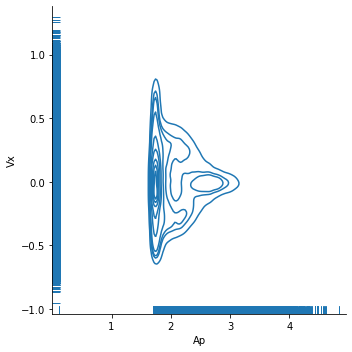

In [6]:
import seaborn as sns

plt.figure(figsize=(16, 6))
g = sns.displot(df_clean[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean.index.levels[0].values[0])

In [7]:
df_i = df_clean.copy()

In [8]:
%%time
print('Train and evaluate model for ' + df_i.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()

Train and evaluate model for 04714B601096
2020-12-22T13:41:23.314 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-22T13:41:23.315 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-22T13:41:23.316 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-22T13:41:23.317 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-22T13:41:23.318 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201222124123
2020-12-22T13:41:23.318 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-22T13:41:23.319 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-22T13:41:23.320 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-22T13:41:23.321 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

<ipython-input-8-ebaa636e8370>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "print('Train and evaluate model for ' + df_i.index.levels[0].values[0])\n# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi = VIAnomalyScore(['Ap'], ['Vx'])\net = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi._entity_type = et\ndf_i = spsi.execute(df=df_i)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i.describe()\n")


Ap             Vx   predicted_Vx    pred_dev_Vx
count  430290.000000  430290.000000  430290.000000  430290.000000
mean        1.921440      -0.006829      -0.005975       0.779265
std         0.324419       0.236620       0.000699       0.095900
min         0.115600      -0.956100      -0.015145       0.082666
25%         1.732000      -0.146500      -0.006131       0.770269
50%         1.758800      -0.016600      -0.005618       0.791205
75%         1.982000       0.123000      -0.005556       0.819832
max         4.836800       1.297900      -0.005503       0.906836

2020-12-22T13:41:24.399 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-22T13:41:24.400 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.
2020-12-22T13:41:25.107 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B601096 - plain scatterplot')

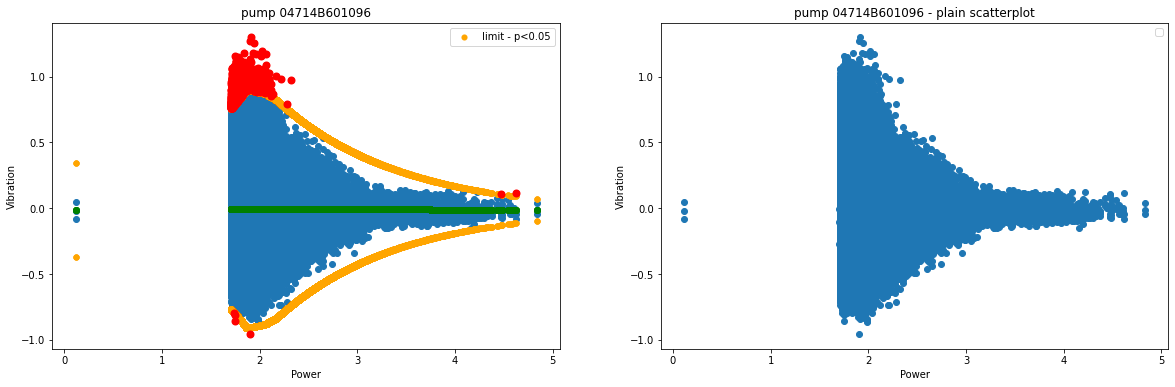

In [9]:
df_1 = df_i.loc[df_i.index.levels[0].values[0]].copy()

arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Power')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

ax[0,1].scatter(df_i['Ap'], df_clean['Vx'])
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + df_i.index.levels[0].values[0] + ' - plain scatterplot')


#plt.fill_between(df_1['Ap'], - df_1['pred_dev_Vx'], df_1['pred_dev_Vx'], alpha=0.2)

Text(0.5, 1.0, 'pump 04714B601096')

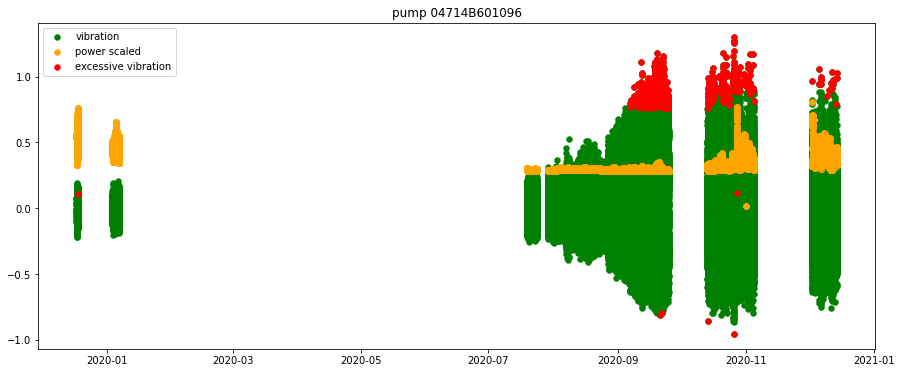

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/6, lw=0.4, color='orange', zorder=5, label='power scaled')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

In [12]:
def load_data_short(filename):
    # load data
    df_input = pd.read_csv(filename, parse_dates=['RCV_TIMESTAMP_UTC'], comment='#')
    #df_input = df_input.asfreq('H')
    df_input = df_input.sort_values(by='RCV_TIMESTAMP_UTC').\
                    rename(columns={'RCV_TIMESTAMP_UTC':'timestamp', 'DEVICEID': 'entity'}).\
                    drop(columns=['DEVICETYPE', 'FORMAT','UPDATED_UTC','LOGICALINTERFACE_ID','DEVICE_ID']).\
                    drop(columns=['RMS_X','RMS_Y','RMS_Z'])
    #df_input = df_input[df_input['VERSION'] != 0].drop(columns=['VERSION'])
       
    return df_input
    
def prep_data_short(df_input):
    entity = df_input['entity'].values[0]
    
    list_ac_vx = []
    cnt = 0
    for idx,row in df_input[['timestamp','VIBRATIONS_XAXIS','ACCEL_SPEED']].iterrows():
        if isinstance(row['timestamp'], str):
            ts = datetime.datetime.strptime(row['timestamp'], '%Y-%m-%d-%H.%M.%S.%f')
        else:
            ts = row['timestamp']
            
        rvibs = row['VIBRATIONS_XAXIS']
        racc = row['ACCEL_SPEED']
        
        if isinstance(racc, str):
            racc = eval(racc)

        if not isinstance(racc, list) and math.isnan(racc):
            continue
            
        if isinstance(rvibs, str):
            list_ac = []
           
            for ac in racc:
                #print(ac)
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                #print (list_ac)

            list_vx = []
            for vx in eval(rvibs):
                list_vx.append(vx)
                #print (list_vx)

            #print(list_ac, list_vx)
            cnt2 = 0
            for p in zip(list_ac, list_vx):
                #print(ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1])
                list_ac_vx.append([ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1]])
                cnt2 += 1
        cnt += 1

    df_clean = pd.DataFrame(list_ac_vx, columns=['timestamp','Ap','Vx'])
    df_clean['Ap'] = df_clean['Ap']/1000
    df_clean['entity'] = entity
    
    return df_clean.set_index(['entity','timestamp'])
    

In [13]:
#df_clean2 = prep_data(load_data('./IOT_PUMP_DE_GEN5_202012151526.csv'))
df_clean2 = prep_data_short(load_data_short('./04714B603408.csv'))
#df_clean2.describe()
df_clean2.head(2)
df_clean2.index.levels[0].values[0]

'04714B603408'

In [14]:
df_clean2.describe()

Ap            Vx
count  1.371300e+06  1.371300e+06
mean   1.501744e+00 -2.946143e-02
std    1.482848e+00  1.308858e-01
min    0.000000e+00 -1.039100e+00
25%    0.000000e+00 -4.390000e-02
50%    1.281000e+00 -2.730000e-02
75%    3.099000e+00 -8.800000e-03
max    3.780000e+00  1.035200e+00

<Figure size 1152x432 with 0 Axes>

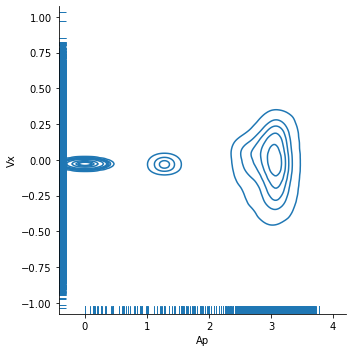

In [15]:

plt.figure(figsize=(16, 6))
g = sns.displot(df_clean2[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean2.index.levels[0].values[0])

In [16]:
df_i2 = df_clean2.copy()


In [17]:
%%time
print('Train and evaluate model for ' + df_i2.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi2 = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi2._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi2._entity_type = et
spsi2.epochs = 300   # 1500 takes ages
df_i2 = spsi.execute(df=df_i2)

EngineLogging.configure_console_logging(logging.INFO)
df_i2.describe()

Train and evaluate model for 04714B603408
2020-12-22T13:57:10.081 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-22T13:57:10.082 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-22T13:57:10.083 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-22T13:57:10.084 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-22T13:57:10.084 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201222125710
2020-12-22T13:57:10.084 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-22T13:57:10.085 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-22T13:57:10.085 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-22T13:57:10.085 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

2020-12-22T14:09:25.001 DEBUG mmfunctions.anomaly.execute Epoch: 720, Loss: 0.5140376091003418
2020-12-22T14:09:35.230 DEBUG mmfunctions.anomaly.execute Epoch: 730, Loss: 0.5148692727088928
2020-12-22T14:09:45.743 DEBUG mmfunctions.anomaly.execute Epoch: 740, Loss: 0.513357400894165
2020-12-22T14:09:56.328 DEBUG mmfunctions.anomaly.execute Epoch: 750, Loss: 0.5140331387519836
2020-12-22T14:10:06.852 DEBUG mmfunctions.anomaly.execute Epoch: 760, Loss: 0.5143701434135437
2020-12-22T14:10:17.249 DEBUG mmfunctions.anomaly.execute Epoch: 770, Loss: 0.5141509175300598
2020-12-22T14:10:27.786 DEBUG mmfunctions.anomaly.execute Epoch: 780, Loss: 0.5143022537231445
2020-12-22T14:10:38.410 DEBUG mmfunctions.anomaly.execute Epoch: 790, Loss: 0.5142222046852112
2020-12-22T14:10:49.238 DEBUG mmfunctions.anomaly.execute Epoch: 800, Loss: 0.5146180987358093
2020-12-22T14:11:00.254 DEBUG mmfunctions.anomaly.execute Epoch: 810, Loss: 0.5139776468276978
2020-12-22T14:11:11.208 DEBUG mmfunctions.anomaly.e

<ipython-input-17-bb9e9a5bbb29>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "print('Train and evaluate model for ' + df_i2.index.levels[0].values[0])\n# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi2 = VIAnomalyScore(['Ap'], ['Vx'])\net = spsi2._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi2._entity_type = et\nspsi2.epochs = 300   # 1500 takes ages\ndf_i2 = spsi.execute(df=df_i2)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i2.describe()\n")


CPU times: user 1h 59min 6s, sys: 30min 21s, total: 2h 29min 27s
Wall time: 26min 37s


Ap            Vx  predicted_Vx   pred_dev_Vx
count  1.371300e+06  1.371300e+06  1.371300e+06  1.371300e+06
mean   1.501744e+00 -2.946143e-02 -2.734308e-02  4.044737e-01
std    1.482848e+00  1.308858e-01  1.372179e-03  2.715333e-01
min    0.000000e+00 -1.039100e+00 -3.356946e-02  1.361498e-01
25%    0.000000e+00 -4.390000e-02 -2.845207e-02  1.361498e-01
50%    1.281000e+00 -2.730000e-02 -2.845207e-02  2.858738e-01
75%    3.099000e+00 -8.800000e-03 -2.569535e-02  6.752676e-01
max    3.780000e+00  1.035200e+00 -1.292527e-03  8.986392e-01

2020-12-22T14:50:14.011 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B603408 - plain scatterplot')

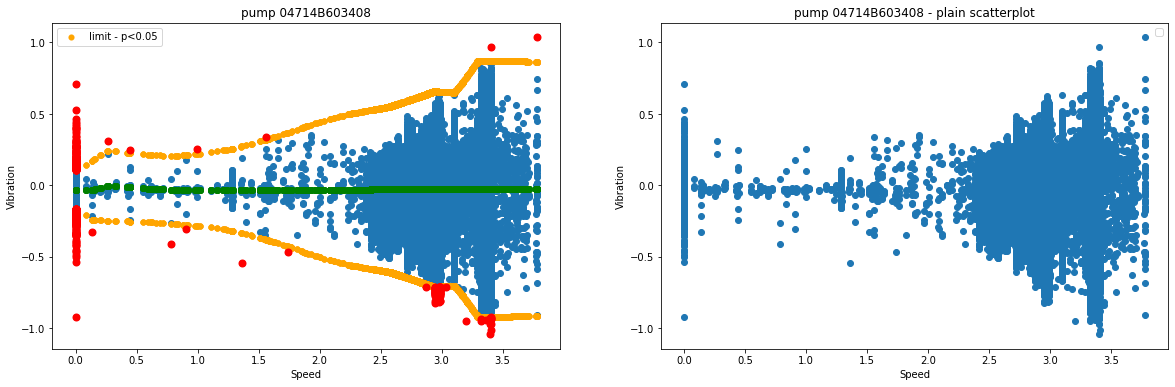

In [26]:
entity = df_i2.index.levels[0].values[0]

df_1 = df_i2.loc[entity].copy()


arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Speed')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + entity)

ax[0,1].scatter(df_i2['Ap'], df_i2['Vx'])
ax[0,1].set_xlabel('Speed')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + entity + ' - plain scatterplot')


In [27]:
df_1[df_1['Ap'] < 2.0]['Anomaly'] = np.nan
df_1[np.abs(df_1['Vx']) < 0.7]['Anomaly'] = np.nan

<ipython-input-27-11cbb9c58f70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[df_1['Ap'] < 2.0]['Anomaly'] = np.nan
<ipython-input-27-11cbb9c58f70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[np.abs(df_1['Vx']) < 0.7]['Anomaly'] = np.nan


Text(0.5, 1.0, 'pump 04714B603408')

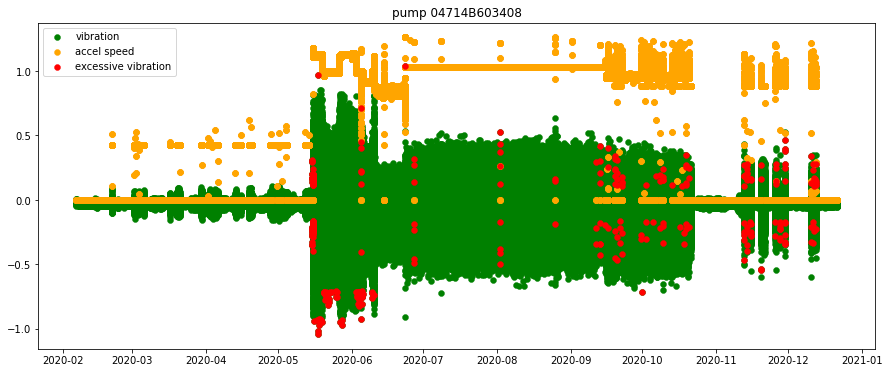

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/3, lw=0.4, color='orange', zorder=5, label='accel speed')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i2.index.levels[0].values[0])

In [29]:
df_clean3 = prep_data_short(load_data_short('./04714B6036B1.csv'))
df_clean3.head(2)
df_clean3.index.levels[0].values[0]

'04714B6036B1'

<Figure size 1152x432 with 0 Axes>

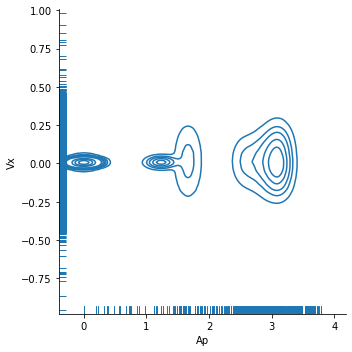

In [30]:
plt.figure(figsize=(16, 6))
g = sns.displot(df_clean3[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean3.index.levels[0].values[0])

In [31]:
df_i3 = df_clean3.copy()

In [32]:
%%time
print('Train and evaluate model for ' + df_i3.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi3 = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi3._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi3._entity_type = et
df_i3 = spsi.execute(df=df_i3)

EngineLogging.configure_console_logging(logging.INFO)
df_i3.describe()

Train and evaluate model for 04714B6036B1
2020-12-22T15:50:44.327 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-22T15:50:44.328 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-22T15:50:44.328 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-22T15:50:44.329 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-22T15:50:44.330 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201222145044
2020-12-22T15:50:44.330 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-22T15:50:44.331 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-22T15:50:44.331 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-22T15:50:44.332 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

2020-12-22T16:08:27.718 DEBUG mmfunctions.anomaly.execute Epoch: 710, Loss: 0.4861690402030945
2020-12-22T16:08:48.223 DEBUG mmfunctions.anomaly.execute Epoch: 720, Loss: 0.4854114055633545
2020-12-22T16:09:10.729 DEBUG mmfunctions.anomaly.execute Epoch: 730, Loss: 0.48605582118034363
2020-12-22T16:09:31.181 DEBUG mmfunctions.anomaly.execute Epoch: 740, Loss: 0.48728975653648376
2020-12-22T16:09:41.966 DEBUG mmfunctions.anomaly.execute Epoch: 750, Loss: 0.4858241081237793
2020-12-22T16:09:52.462 DEBUG mmfunctions.anomaly.execute Epoch: 760, Loss: 0.4855801463127136
2020-12-22T16:10:02.648 DEBUG mmfunctions.anomaly.execute Epoch: 770, Loss: 0.48650646209716797
2020-12-22T16:10:13.460 DEBUG mmfunctions.anomaly.execute Epoch: 780, Loss: 0.4863134026527405
2020-12-22T16:10:24.221 DEBUG mmfunctions.anomaly.execute Epoch: 790, Loss: 0.48651033639907837
2020-12-22T16:10:34.580 DEBUG mmfunctions.anomaly.execute Epoch: 800, Loss: 0.48592084646224976
2020-12-22T16:10:45.270 DEBUG mmfunctions.ano

<ipython-input-32-c9f26aead716>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "print('Train and evaluate model for ' + df_i3.index.levels[0].values[0])\n# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi3 = VIAnomalyScore(['Ap'], ['Vx'])\net = spsi3._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi3._entity_type = et\ndf_i3 = spsi.execute(df=df_i3)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i3.describe()\n")


CPU times: user 2h 33min 9s, sys: 41min 20s, total: 3h 14min 30s
Wall time: 35min 1s


Ap            Vx  predicted_Vx   pred_dev_Vx
count  1.368975e+06  1.368975e+06  1.368975e+06  1.368975e+06
mean   1.400429e+00  9.770501e-03  8.359868e-03  3.902670e-01
std    1.396439e+00  8.449316e-02  2.403382e-03  1.797408e-01
min    0.000000e+00 -9.580000e-01  6.013222e-03  2.128958e-01
25%    0.000000e+00 -1.370000e-02  6.013222e-03  2.128958e-01
50%    1.234000e+00  6.800000e-03  7.152006e-03  2.514825e-01
75%    3.099000e+00  2.930000e-02  1.133477e-02  5.796511e-01
max    3.780000e+00  9.834000e-01  1.609729e-02  6.654118e-01

2020-12-22T16:26:02.429 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B6036B1 - plain scatterplot')

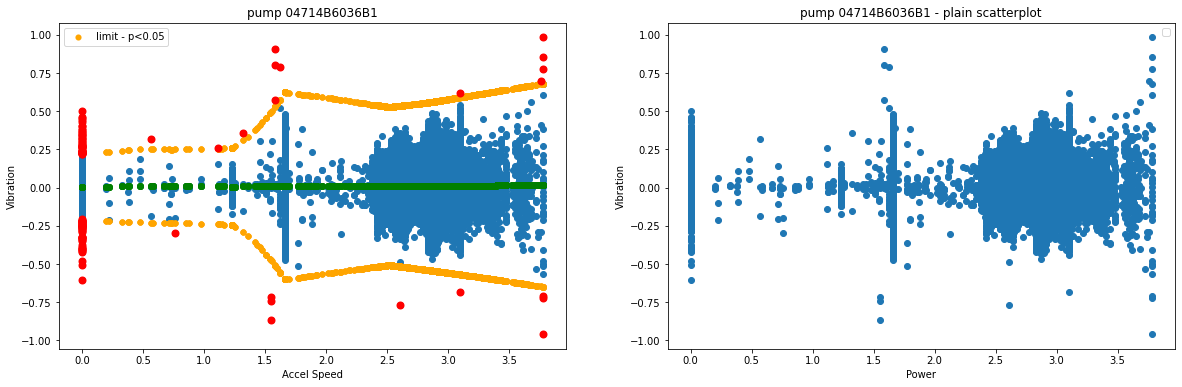

In [33]:
entity = df_i3.index.levels[0].values[0]

df_1 = df_i3.loc[entity].copy()


arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Accel Speed')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + entity)

ax[0,1].scatter(df_i3['Ap'], df_i3['Vx'])
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + entity + ' - plain scatterplot')


In [34]:
df_1[df_1['Ap'] < 0.5]['Anomaly'] = np.nan
df_1[np.abs(df_1['Vx']) < 0.5]['Anomaly'] = np.nan

<ipython-input-34-dac41d32ec2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[df_1['Ap'] < 0.5]['Anomaly'] = np.nan
<ipython-input-34-dac41d32ec2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[np.abs(df_1['Vx']) < 0.5]['Anomaly'] = np.nan


Text(0.5, 1.0, 'pump 04714B6036B1')

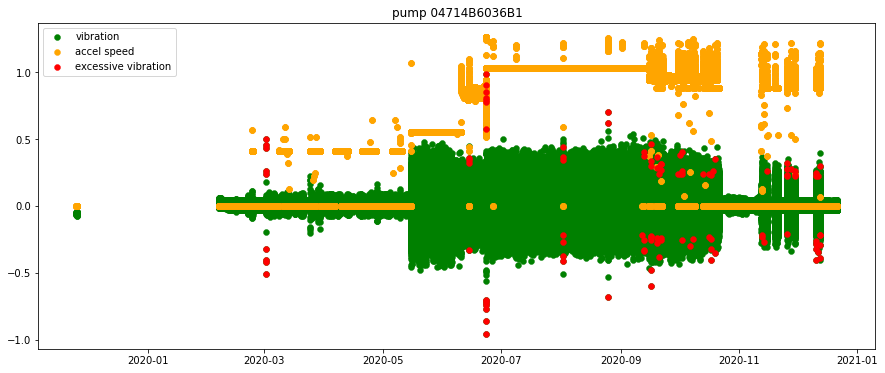

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/3, lw=0.4, color='orange', zorder=5, label='accel speed')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i3.index.levels[0].values[0])

In [1]:
df_clean4 = prep_data(load_data('./04714B603408.csv'))
df_clean4.head(2)
df_clean4.index.levels[0].values[0]

NameError: name 'prep_data' is not defined

In [ ]:
plt.figure(figsize=(16, 6))
g = sns.displot(df_clean2[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean2.index.levels[0].values[0])

#### Approximate with Gaussian

major contribution: gaussian along x/y coordinates, start with diagonal covariance matrix:

likelihood:

$e^{\frac{ {(\mu_0 - x)}^2}{\sigma_0} \frac{ {(\mu_1 - y)}^2}{\sigma_1}  }$


ModuleNotFoundError: No module named 'tensorflow.contrib'

In [ ]:
# theta_0, theta_1 = mu_0/mu_1, theta_2/theta_3 = sigma_0/ sigma_1
def log_likelihood(theta, F, e):
    
    
    return np.sum(theta[0]
        
        np.log(2 * np.pi * (theta[1] ** 2 + theta[2] ** 2))
                         + (theta[0]) ** 2 / (theta[1] ** 2 + theta[2] ** 2))



def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)